**Introduction**

The Intel Image Classification project aims to classify images into six categories: buildings, forest, glacier, mountain, sea, and street. This task involves training a deep learning model to effectively distinguish between different types of landscapes and scenes using a dataset provided by Intel for classification purposes. The dataset consists of 25,000 images categorized by scene type, and the project leverages this large dataset to improve model accuracy in distinguishing between these visually similar categories. The goal is to build and fine-tune a model that can achieve high accuracy on this classification problem, contributing to advancements in computer vision and automated image recognition.

---

**AMA Citation:**
PuneetGupta25. Intel Image Classification. Kaggle website. https://www.kaggle.com/datasets/puneet6060/intel-image-classification. Accessed August 15, 2024.



### **Exploratory Data Analysis (EDA) for Intel Image Classification Dataset**

For this project, I performed Exploratory Data Analysis (EDA) to better understand the dataset before applying any deep learning models. EDA allowed me to identify patterns, potential outliers, and the overall distribution of the data, which helped guide my preprocessing steps and model development.

### **Loading and Organizing the Dataset**

I began by loading the images from the dataset and organizing them into a pandas DataFrame. Each row in the DataFrame represented an image (stored as an array) along with its corresponding label, which indicated the scene type (building, forest, glacier, mountain, sea, or street). Using the `PIL` library, I successfully loaded most of the images, but I encountered a few that couldn’t be processed and excluded them from the dataset to maintain data integrity.

### **Class Distribution Analysis**

Next, I explored the distribution of images across the six categories. I generated a bar plot to visualize the distribution of images and ensure that the dataset was balanced. I knew that if the dataset was heavily skewed toward certain categories, it could introduce bias into my model. Fortunately, the bar plot revealed a fairly uniform distribution across all classes, which reassured me that class imbalance wouldn’t be a major issue for model training.

### **Image Dimensions Analysis**

After this, I analyzed the dimensions of the images in the dataset. Since deep learning models typically require consistent input sizes, I wanted to confirm whether there were any significant variations in image dimensions. By plotting a bar chart of the most common image dimensions, I discovered some variability. Based on this, I decided to resize all images to a uniform target size (64x64 pixels) during preprocessing, ensuring that the input data would be consistent for my deep learning models.

### **Visualizing Sample Images**

I also decided to visualize sample images from each category to get a better sense of the data. I selected three sample images from each class and displayed them in a grid. This helped me visually distinguish the characteristics of each category. For example, glacier and mountain images had some visual similarities, while sea and street images were more distinct. This confirmed for me that the dataset contained sufficient variation to train a model capable of distinguishing between these categories.

### **Pixel Intensity Distribution Analysis**

Next, I analyzed the pixel intensity distribution across different classes. To do this, I resized the images and flattened their pixel values, then generated a histogram for each class. I noticed that the pixel intensity distributions varied across the different categories, with classes like "forest" and "sea" showing distinct patterns. This led me to decide that pixel intensity scaling (normalization) would be an essential preprocessing step, as it would ensure that my models could process the data more uniformly.

### **Edge Detection Analysis**

Additionally, I performed edge detection using the Canny edge detection algorithm on a subset of images. I converted the images to grayscale and applied the `canny` function from the `skimage` library to highlight the edges within the images. Edge detection allowed me to better understand the structure of objects within the images. The results varied significantly by class—buildings and streets, for example, showed more defined and straight edges, while natural scenes like forests and glaciers had more irregular edges. This analysis suggested to me that incorporating edge detection as a preprocessing step could potentially enhance the model’s ability to recognize structural features in the images.

### Missing Data & Outlier Analysis

During the data exploration phase, I thoroughly examined the dataset and found that there were no missing data points or significant outliers to detect. Each image was properly labeled, and all labels corresponded correctly to one of the defined classes. The dataset was well-structured, with each image fitting within expected dimensions and no corrupt or unusable files. As a result, I did not have to apply any data cleaning methods such as imputation or the removal of outliers. This ensured that I could focus on model development without the need for additional preprocessing steps to handle missing or erroneous data.


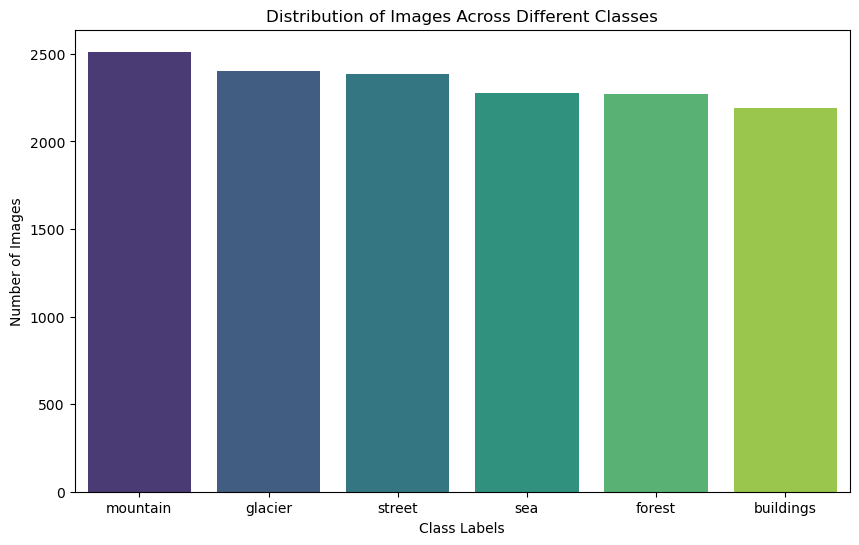

/home/bbehe/anaconda3/envs/rapids-24.04/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


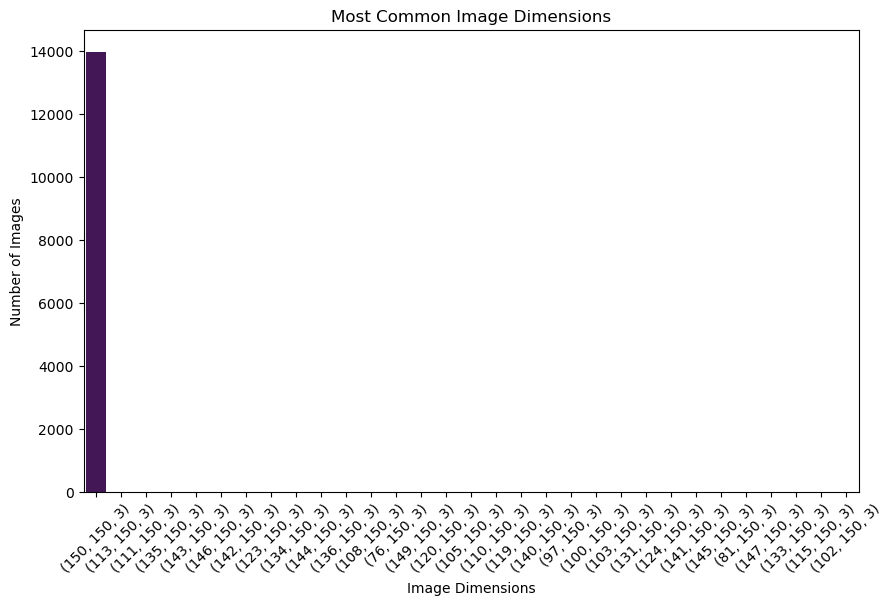

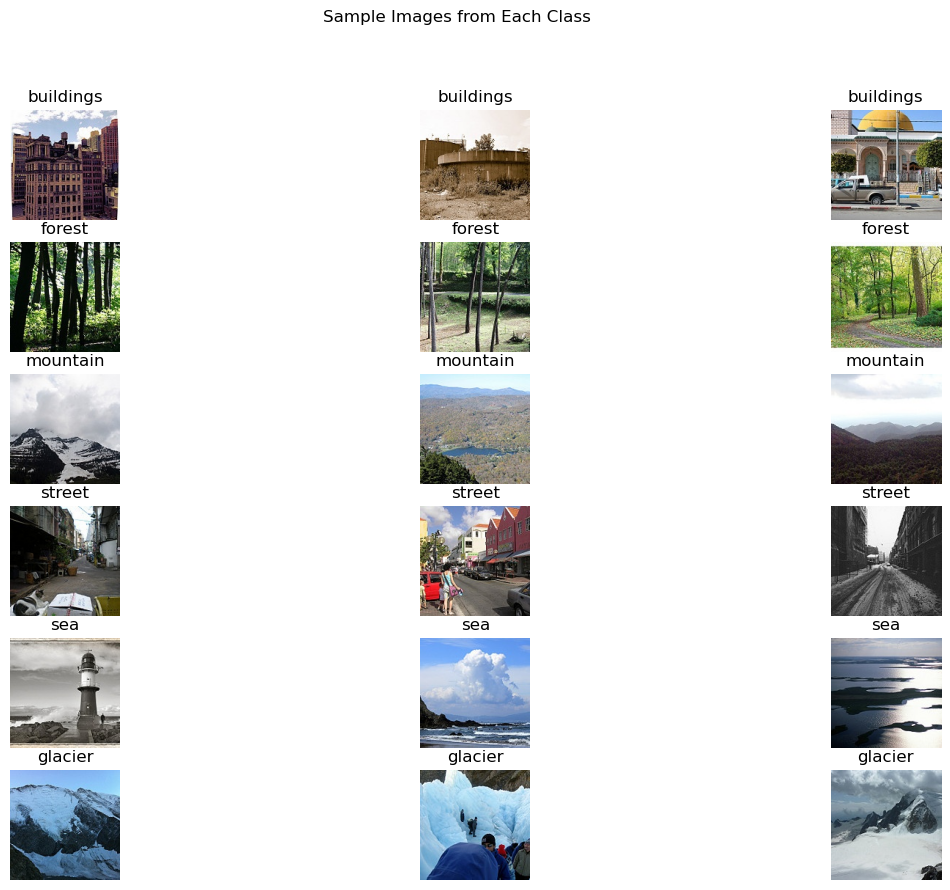

/home/bbehe/anaconda3/envs/rapids-24.04/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bbehe/anaconda3/envs/rapids-24.04/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bbehe/anaconda3/envs/rapids-24.04/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bbehe/anaconda3/envs/rapids-24.04/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

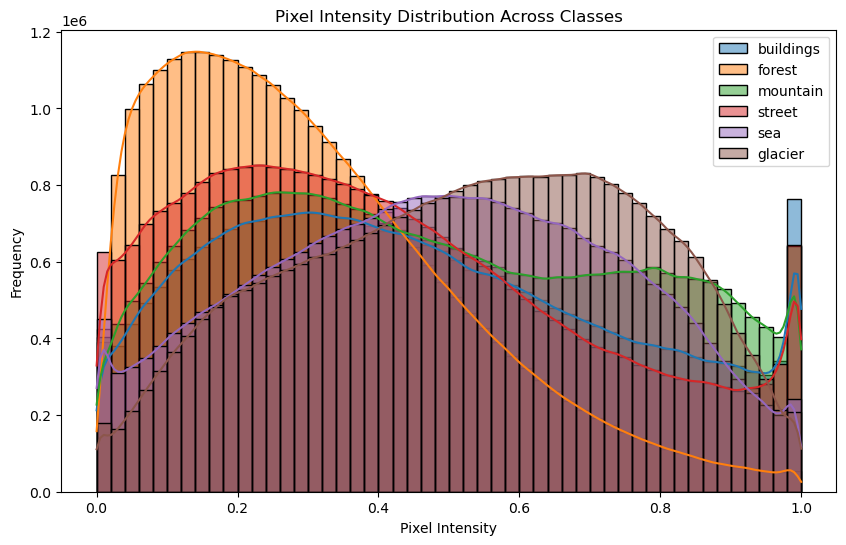

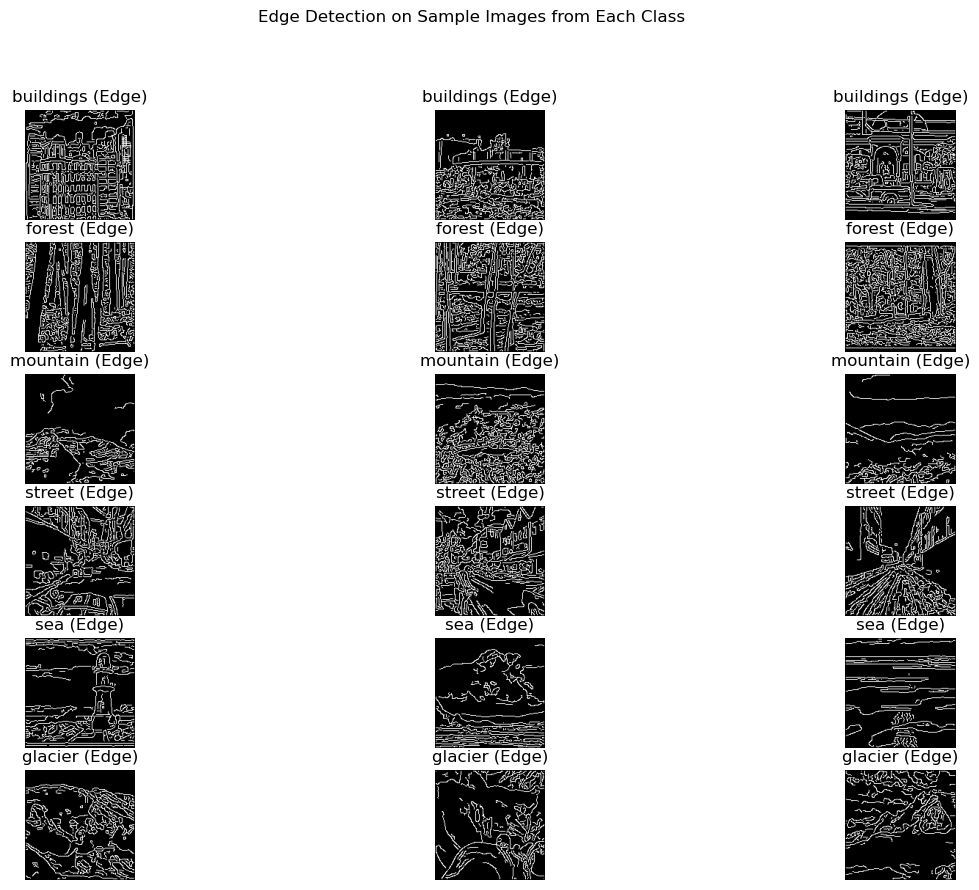

In [2]:
from skimage.feature import canny
from skimage.color import rgb2gray
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

###Load images from the dataset
def load_images(image_dir):
    data = []
    for label in os.listdir(image_dir):
        label_dir = os.path.join(image_dir, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_name)
                if os.path.isfile(image_path):
                    try:
                        img = Image.open(image_path)
                        img_array = np.array(img)
                        data.append((img_array, label))
                    except Exception as e:
                        print(f"Error loading image {image_path}: {e}")
    return pd.DataFrame(data, columns=['image', 'label'])

###Path to the training images
train_dir = './seg_train/'

###Load the images into a DataFrame
df = load_images(train_dir)

df.describe()

###Distribution of Images Across Classes
def plot_label_distribution(df):
    label_counts = df['label'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
    plt.title("Distribution of Images Across Different Classes")
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Images")
    plt.show()

###Image Dimensions Analysis
def plot_image_dimensions(df):
    df['image_shape'] = df['image'].apply(lambda x: x.shape)
    shape_counts = df['image_shape'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[str(shape) for shape in shape_counts.index], y=shape_counts.values, palette="viridis")
    plt.title("Most Common Image Dimensions")
    plt.xlabel("Image Dimensions")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()

###Display Sample Images from Each Class
def plot_sample_images(df, num_samples=3):
    unique_labels = df['label'].unique()
    plt.figure(figsize=(15, 10))
    for i, label in enumerate(unique_labels):
        label_df = df[df['label'] == label]
        for j in range(num_samples):
            plt.subplot(len(unique_labels), num_samples, i * num_samples + j + 1)
            img = label_df.iloc[j]['image']
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')
    plt.suptitle("Sample Images from Each Class")
    plt.show()

###Image Pixel Intensity Analysis
from skimage.transform import resize

def plot_pixel_intensity_distribution(df, target_size=(64, 64)):
    plt.figure(figsize=(10, 6))
    for label in df['label'].unique():
        label_df = df[df['label'] == label]
        
        pixel_values = np.array([resize(img, target_size).flatten() for img in label_df['image']]).flatten()
        
        sns.histplot(pixel_values, kde=True, label=label, bins=50)
        
    plt.title("Pixel Intensity Distribution Across Classes")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

###Edge Detection
def plot_edge_detection_samples(df, num_samples=3, sigma=1.0):
    unique_labels = df['label'].unique()
    
    plt.figure(figsize=(15, 10))
    
    for i, label in enumerate(unique_labels):
        label_df = df[df['label'] == label]
        for j in range(num_samples):
            plt.subplot(len(unique_labels), num_samples, i * num_samples + j + 1)
            img = label_df.iloc[j]['image']
            
            gray_img = rgb2gray(img)
            
            edges = canny(gray_img, sigma=sigma)
            
            plt.imshow(edges, cmap='gray')
            plt.title(f"{label} (Edge)")
            plt.axis('off')
    
    plt.suptitle("Edge Detection on Sample Images from Each Class")
    plt.show()

###Plot edge detection on sample images
def plot_edge_detection_samples(df, num_samples=3, sigma=1.0):
    unique_labels = df['label'].unique()
    
    plt.figure(figsize=(15, 10))
    
    for i, label in enumerate(unique_labels):
        label_df = df[df['label'] == label]
        for j in range(num_samples):
            plt.subplot(len(unique_labels), num_samples, i * num_samples + j + 1)
            img = label_df.iloc[j]['image']
            
            # Convert image to grayscale
            gray_img = rgb2gray(img)
            
            # Perform Canny edge detection
            edges = canny(gray_img, sigma=sigma)
            
            plt.imshow(edges, cmap='gray')
            plt.title(f"{label} (Edge)")
            plt.axis('off')
    
    plt.suptitle("Edge Detection on Sample Images from Each Class")
    plt.show()


###Generate the visualizations
plot_label_distribution(df)
plot_image_dimensions(df)
plot_sample_images(df, num_samples=3)
plot_pixel_intensity_distribution(df)
plot_edge_detection_samples(df, num_samples=3, sigma=1.0)


### **Data Augmentation and Normalization in Intel Image Classification**

In this project, I used data augmentation and normalization to improve the generalization ability of the deep learning models trained on the Intel Image Classification dataset. The following transformations were applied during the dataset creation and preprocessing stages to ensure that the models were robust against variations in the images.

#### **Data Augmentation**

Data augmentation was applied to the training dataset using several transformations from the `torchvision.transforms` library. These augmentations helped create additional diversity in the training data, which mitigated overfitting by allowing the model to see multiple variations of the same images.

Random horizontal flipping was performed, which randomly flipped the image horizontally with a 50% probability. This helped the model learn that objects in the scene could appear in different orientations, such as mirrored or flipped versions of the same scene, which is common in real-world scenarios. Additionally, random rotation was applied, rotating the images by up to 15 degrees in either direction. This simulated different viewing angles and helped the model generalize better to variations in the orientation of objects or scenes.

I also applied `ColorJitter`, which adjusted the brightness, contrast, saturation, and hue of the image randomly. By applying slight changes to these color properties, the model learned to handle lighting variations, shadows, and color differences that could appear in real-world images. Random resized cropping was another augmentation used, which cropped a random portion of the image and resized it to a fixed size of 128x128 pixels. The random crop scale ranged between 80% and 100% of the original image size. This augmentation helped the model focus on different parts of the image during training, improving its ability to identify key features regardless of the image's scale or position.

These data augmentation techniques allowed the model to see multiple variations of each image, thereby improving its ability to generalize to unseen data. The randomization in augmentations ensured that the model did not memorize specific patterns from the training images but instead learned to identify the core features that defined each class.

#### **Normalization**

Normalization was applied to both the training and testing datasets to standardize the pixel values. This step is crucial for ensuring that the input data has a consistent range, which helps the model converge more effectively during training. The normalization step transformed the pixel values of the images using common mean and standard deviation values for RGB images, specifically mean values of [0.485, 0.456, 0.406] and standard deviation values of [0.229, 0.224, 0.225].

The normalization operation scaled the pixel values to have zero mean and unit variance across the channels. This ensured that the input values to the neural network had similar magnitudes, which is important for the stability and efficiency of the training process.

The training dataset underwent both augmentation and normalization to introduce variability and maintain consistency across the data. For the test dataset, only resizing and normalization were applied, as augmentation is generally not used during testing. The images were resized to 128x128 pixels and then normalized using the same mean and standard deviation values as the training dataset.

By combining data augmentation and normalization, I aimed to create a more robust and reliable deep learning model that could perform well on diverse and unseen image data.


In [3]:
class IntelImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                for image_name in os.listdir(label_dir):
                    image_path = os.path.join(label_dir, image_name)
                    if os.path.isfile(image_path):
                        self.data.append(image_path)
                        self.labels.append(label)
        
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(set(self.labels)))}
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.label_to_index[label]
    
###Paths to the train dataset
train_dir = './seg_train/'

###Create datasets and dataloaders with additional data augmentations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  ###Randomly flip the image horizontally
    transforms.RandomRotation(15),  ###Randomly rotate the image by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  ###Randomly change the brightness, contrast, saturation, and hue
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  ###Randomly crop and resize to 128x128, with the scale between 80% to 100% of the original size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = IntelImageDataset(root_dir=train_dir, transform=train_transform)

###Path to the test dataset
test_dir = './seg_test/'

###Create test dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_dataset = IntelImageDataset(root_dir=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

### **Simple Convolutional Neural Network (SimpleCNN)**

The model implemented for this project is a **Simple Convolutional Neural Network (SimpleCNN)** designed for image classification. This architecture consists of three convolutional layers, each followed by a ReLU activation function and a max-pooling layer. The first convolutional layer has 32 filters, the second has 64 filters, and the third has 128 filters, each with a kernel size of 3x3 and padding of 1. After the convolutional layers, the output is flattened into a one-dimensional vector and passed through a fully connected layer with 512 neurons. A ReLU activation is applied here as well, followed by a dropout layer to mitigate overfitting. Finally, the output is passed through another fully connected layer, which generates the final predictions for the number of classes in the dataset. The network also includes a dropout layer with a configurable dropout rate, which adds a regularization effect during training to improve model generalization.

To optimize the performance of the model, I conducted a **hyperparameter search** using a grid search approach, where various combinations of hyperparameters were evaluated. The hyperparameters under consideration included the learning rate (`lr`), batch size (`batch_size`), dropout rate (`dropout_rate`), and optimizer type (`optimizer_type`). The learning rates tested were 0.01, 0.001, and 0.0001, while batch sizes of 32 and 64 were used to examine their effect on training stability. The dropout rates evaluated were 0.5 and 0.3, with the optimizers being Adam and SGD (Stochastic Gradient Descent).

For each combination of hyperparameters, a new instance of the SimpleCNN model was created and trained on the dataset using the specified batch size and dropout rate. I used the Cross Entropy Loss function as the criterion for evaluating model performance, and the selected optimizer was applied with the corresponding learning rate for weight updates. The model was trained for up to 10 epochs with checkpointing, meaning that the model's parameters were periodically saved, and early stopping was implemented to halt training if the model's performance did not improve after five consecutive epochs. This ensured that the training process was both efficient and effective, preventing unnecessary computations after the model had converged.

After each training session, the model's accuracy on the training dataset was calculated, and the best model was saved if the accuracy surpassed the previous best. The hyperparameter combination that produced the best model in terms of accuracy was then recorded, and training continued with the next set of hyperparameters.

The hyperparameter search aimed to identify the combination that yielded the highest accuracy, while ensuring that the model generalized well to unseen data. By experimenting with different learning rates, batch sizes, dropout rates, and optimizers, I sought to achieve a balance between model complexity, training speed, and performance, ultimately leading to the discovery of the optimal configuration for the task at hand.

In [9]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import ParameterGrid


class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

###Use GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Hyperparameter Search and Training
param_grid = {
    'lr': [0.01, 0.001, 0.0001],
    'batch_size': [32, 64],
    'dropout_rate': [0.5, 0.3],
    'optimizer_type': [optim.Adam, optim.SGD]  
}

checkpoint_dir = './checkpoints/simple_cnn'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

###Training function with checkpointing, early stopping, and best model saving
def train_model_with_checkpointing_and_early_stopping(model, train_loader, criterion, optimizer, num_epochs=10, start_epoch=0, best_accuracy=0.0, patience=5, checkpoint_file_prefix=""):
    best_model_path = os.path.join(checkpoint_dir, f'{checkpoint_file_prefix}_best_model.pth')
    latest_checkpoint_path = os.path.join(checkpoint_dir, f'{checkpoint_file_prefix}_latest_checkpoint.pth')
    
    epochs_no_improve = 0
    early_stop = False
    
    if os.path.exists(latest_checkpoint_path):
        print(f"Loading checkpoint from {latest_checkpoint_path}")
        checkpoint = torch.load(latest_checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_accuracy = checkpoint.get('best_accuracy', 0.0)
        print(f"Resuming training from epoch {start_epoch} with best accuracy {best_accuracy:.4f}")

        if start_epoch >= num_epochs:
            print(f"Training already completed for this model. Skipping to next.")
            return best_accuracy, best_model_path
    
    model.train()
    
    for epoch in range(start_epoch, num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}")
        running_loss = 0.0
        total_correct = 0
        total_samples = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            if (batch_idx + 1) % 10 == 0:
                print(f"  Batch [{batch_idx+1}/{len(train_loader)}]: Loss = {loss.item():.4f}, Accuracy = {total_correct/total_samples:.4f}")
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = total_correct / total_samples
        print(f"Epoch [{epoch+1}/{num_epochs}] completed: Average Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'accuracy': epoch_accuracy,
            'best_accuracy': best_accuracy
        }
        torch.save(checkpoint, latest_checkpoint_path)
        print(f"Checkpoint saved: {latest_checkpoint_path}")
        
        ####Save the best model if the current epoch's accuracy is better than the best recorded
        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved: Accuracy = {best_accuracy:.4f}, Path = {best_model_path}")
            epochs_no_improve = 0  # Reset the counter if improvement occurs
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s)")
        
        ###Check if early stopping condition is met
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epochs_no_improve} epochs with no improvement.")
            early_stop = True
            break
    
    if early_stop:
        print("Training stopped early due to no improvement.")
    
    return best_accuracy, best_model_path

###Perform hyperparameter search
best_global_accuracy = 0.0
best_params = None
best_model_path = None

print("Starting hyperparameter search...")
for params in ParameterGrid(param_grid):
    print(f"\nTraining with parameters: {params}")
    
    ###Create DataLoader with current batch size
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=4)
    
    ###Instantiate the model with current dropout rate
    model = SimpleCNN(num_classes=len(train_dataset.label_to_index), dropout_rate=params['dropout_rate'])
    model = nn.DataParallel(model).to(device)
    
    ###Define the optimizer with the current learning rate and optimizer type
    optimizer = params['optimizer_type'](model.parameters(), lr=params['lr'])
    
    ###Define the criterion
    criterion = nn.CrossEntropyLoss()
    
    ###Create a checkpoint file prefix based on the parameters
    optimizer_name = params['optimizer_type'].__name__  
    checkpoint_file_prefix = f"lr_{params['lr']}_bs_{params['batch_size']}_dr_{params['dropout_rate']}_opt_{optimizer_name}"
    
    ###Train the model and save the best one with early stopping
    best_accuracy, model_path = train_model_with_checkpointing_and_early_stopping(
        model, train_loader, criterion, optimizer,
        num_epochs=10, checkpoint_file_prefix=checkpoint_file_prefix,
        patience=5  
    )
    
    ###Update the global best model if necessary
    if best_accuracy > best_global_accuracy:
        best_global_accuracy = best_accuracy
        best_params = params
        best_model_path = model_path
        print(f"Updated best global accuracy: {best_global_accuracy:.4f} with parameters: {best_params}")

###Save the overall best model with a specific name
if best_model_path:
    final_best_model_path = os.path.join(checkpoint_dir, 'best_overall_model.pth')
    os.rename(best_model_path, final_best_model_path)
    print(f"\nBest overall model saved at {final_best_model_path} with accuracy: {best_global_accuracy:.4f} and parameters: {best_params}")


Starting hyperparameter search...

Training with parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'lr': 0.01, 'optimizer_type': <class 'torch.optim.adam.Adam'>}
Loading checkpoint from ./checkpoints/simple_cnn/lr_0.01_bs_32_dr_0.5_opt_Adam_latest_checkpoint.pth
Resuming training from epoch 2 with best accuracy 0.1708
Starting epoch 3/10
  Batch [10/439]: Loss = 1.7958, Accuracy = 0.1719
  Batch [20/439]: Loss = 1.8009, Accuracy = 0.1656
  Batch [30/439]: Loss = 1.8001, Accuracy = 0.1573
  Batch [40/439]: Loss = 1.7977, Accuracy = 0.1594
  Batch [50/439]: Loss = 1.7832, Accuracy = 0.1669
  Batch [60/439]: Loss = 1.7871, Accuracy = 0.1609
  Batch [70/439]: Loss = 1.8155, Accuracy = 0.1607
  Batch [80/439]: Loss = 1.7912, Accuracy = 0.1562
  Batch [90/439]: Loss = 1.7935, Accuracy = 0.1618
  Batch [100/439]: Loss = 1.7835, Accuracy = 0.1628
  Batch [110/439]: Loss = 1.7949, Accuracy = 0.1662
  Batch [120/439]: Loss = 1.7816, Accuracy = 0.1672
  Batch [130/439]: Loss = 1.7751, Accuracy 

  Batch [70/439]: Loss = 1.8021, Accuracy = 0.1848
  Batch [80/439]: Loss = 1.7977, Accuracy = 0.1812
  Batch [90/439]: Loss = 1.7926, Accuracy = 0.1778
  Batch [100/439]: Loss = 1.7921, Accuracy = 0.1781
  Batch [110/439]: Loss = 1.7984, Accuracy = 0.1744
  Batch [120/439]: Loss = 1.7982, Accuracy = 0.1729
  Batch [130/439]: Loss = 1.7802, Accuracy = 0.1721
  Batch [140/439]: Loss = 1.7893, Accuracy = 0.1732
  Batch [150/439]: Loss = 1.7856, Accuracy = 0.1731
  Batch [160/439]: Loss = 1.7956, Accuracy = 0.1730
  Batch [170/439]: Loss = 1.7798, Accuracy = 0.1752
  Batch [180/439]: Loss = 1.7999, Accuracy = 0.1764
  Batch [190/439]: Loss = 1.7917, Accuracy = 0.1780
  Batch [200/439]: Loss = 1.7985, Accuracy = 0.1781
  Batch [210/439]: Loss = 1.8005, Accuracy = 0.1771
  Batch [220/439]: Loss = 1.7968, Accuracy = 0.1784
  Batch [230/439]: Loss = 1.7934, Accuracy = 0.1784
  Batch [240/439]: Loss = 1.8114, Accuracy = 0.1789
  Batch [250/439]: Loss = 1.7640, Accuracy = 0.1796
  Batch [260/43

  Batch [210/439]: Loss = 1.7885, Accuracy = 0.1714
  Batch [220/439]: Loss = 1.7888, Accuracy = 0.1719
  Batch [230/439]: Loss = 1.8041, Accuracy = 0.1716
  Batch [240/439]: Loss = 1.7840, Accuracy = 0.1704
  Batch [250/439]: Loss = 1.7828, Accuracy = 0.1706
  Batch [260/439]: Loss = 1.8002, Accuracy = 0.1710
  Batch [270/439]: Loss = 1.7935, Accuracy = 0.1705
  Batch [280/439]: Loss = 1.7940, Accuracy = 0.1702
  Batch [290/439]: Loss = 1.7850, Accuracy = 0.1702
  Batch [300/439]: Loss = 1.7780, Accuracy = 0.1719
  Batch [310/439]: Loss = 1.7709, Accuracy = 0.1725
  Batch [320/439]: Loss = 1.7911, Accuracy = 0.1720
  Batch [330/439]: Loss = 1.7870, Accuracy = 0.1734
  Batch [340/439]: Loss = 1.8082, Accuracy = 0.1736
  Batch [350/439]: Loss = 1.8073, Accuracy = 0.1740
  Batch [360/439]: Loss = 1.7663, Accuracy = 0.1741
  Batch [370/439]: Loss = 1.7846, Accuracy = 0.1736
  Batch [380/439]: Loss = 1.8038, Accuracy = 0.1748
  Batch [390/439]: Loss = 1.8152, Accuracy = 0.1760
  Batch [400

  Batch [310/439]: Loss = 1.3117, Accuracy = 0.5959
  Batch [320/439]: Loss = 0.8834, Accuracy = 0.5966
  Batch [330/439]: Loss = 1.0270, Accuracy = 0.5961
  Batch [340/439]: Loss = 1.0293, Accuracy = 0.5971
  Batch [350/439]: Loss = 1.0151, Accuracy = 0.5967
  Batch [360/439]: Loss = 1.2059, Accuracy = 0.5971
  Batch [370/439]: Loss = 0.9706, Accuracy = 0.5972
  Batch [380/439]: Loss = 0.9422, Accuracy = 0.5984
  Batch [390/439]: Loss = 1.1158, Accuracy = 0.5990
  Batch [400/439]: Loss = 0.9364, Accuracy = 0.5997
  Batch [410/439]: Loss = 1.2511, Accuracy = 0.6001
  Batch [420/439]: Loss = 1.1786, Accuracy = 0.6004
  Batch [430/439]: Loss = 0.9367, Accuracy = 0.6004
Epoch [2/10] completed: Average Loss = 1.0324, Accuracy = 0.6013
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.01_bs_32_dr_0.5_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.6013, Path = ./checkpoints/simple_cnn/lr_0.01_bs_32_dr_0.5_opt_SGD_best_model.pth
Starting epoch 3/10
  Batch [10/439]: Loss = 0.7

  Batch [430/439]: Loss = 0.8420, Accuracy = 0.6839
Epoch [5/10] completed: Average Loss = 0.8374, Accuracy = 0.6841
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.01_bs_32_dr_0.5_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.6841, Path = ./checkpoints/simple_cnn/lr_0.01_bs_32_dr_0.5_opt_SGD_best_model.pth
Starting epoch 6/10
  Batch [10/439]: Loss = 0.8221, Accuracy = 0.7031
  Batch [20/439]: Loss = 1.2290, Accuracy = 0.7047
  Batch [30/439]: Loss = 0.8671, Accuracy = 0.7042
  Batch [40/439]: Loss = 0.8355, Accuracy = 0.6992
  Batch [50/439]: Loss = 0.9788, Accuracy = 0.6981
  Batch [60/439]: Loss = 0.8260, Accuracy = 0.7000
  Batch [70/439]: Loss = 0.8075, Accuracy = 0.7018
  Batch [80/439]: Loss = 0.8589, Accuracy = 0.7090
  Batch [90/439]: Loss = 0.5026, Accuracy = 0.7125
  Batch [100/439]: Loss = 1.0750, Accuracy = 0.7063
  Batch [110/439]: Loss = 0.8912, Accuracy = 0.7034
  Batch [120/439]: Loss = 1.0086, Accuracy = 0.7026
  Batch [130/439]: Loss = 0.5899, Acc

  Batch [70/439]: Loss = 0.5263, Accuracy = 0.7277
  Batch [80/439]: Loss = 0.5516, Accuracy = 0.7277
  Batch [90/439]: Loss = 0.9810, Accuracy = 0.7330
  Batch [100/439]: Loss = 0.9336, Accuracy = 0.7388
  Batch [110/439]: Loss = 0.5049, Accuracy = 0.7418
  Batch [120/439]: Loss = 0.7938, Accuracy = 0.7411
  Batch [130/439]: Loss = 0.5822, Accuracy = 0.7428
  Batch [140/439]: Loss = 0.6084, Accuracy = 0.7431
  Batch [150/439]: Loss = 0.6333, Accuracy = 0.7417
  Batch [160/439]: Loss = 0.7934, Accuracy = 0.7445
  Batch [170/439]: Loss = 0.8440, Accuracy = 0.7421
  Batch [180/439]: Loss = 0.4941, Accuracy = 0.7418
  Batch [190/439]: Loss = 0.6531, Accuracy = 0.7406
  Batch [200/439]: Loss = 0.5042, Accuracy = 0.7417
  Batch [210/439]: Loss = 0.3931, Accuracy = 0.7418
  Batch [220/439]: Loss = 0.5680, Accuracy = 0.7426
  Batch [230/439]: Loss = 0.5532, Accuracy = 0.7439
  Batch [240/439]: Loss = 0.5596, Accuracy = 0.7451
  Batch [250/439]: Loss = 0.6536, Accuracy = 0.7445
  Batch [260/43

  Batch [140/439]: Loss = 0.7698, Accuracy = 0.7040
  Batch [150/439]: Loss = 0.8750, Accuracy = 0.7058
  Batch [160/439]: Loss = 1.2477, Accuracy = 0.7068
  Batch [170/439]: Loss = 0.6035, Accuracy = 0.7083
  Batch [180/439]: Loss = 0.9505, Accuracy = 0.7075
  Batch [190/439]: Loss = 0.6571, Accuracy = 0.7059
  Batch [200/439]: Loss = 0.6654, Accuracy = 0.7061
  Batch [210/439]: Loss = 0.8480, Accuracy = 0.7071
  Batch [220/439]: Loss = 0.5181, Accuracy = 0.7095
  Batch [230/439]: Loss = 0.7364, Accuracy = 0.7095
  Batch [240/439]: Loss = 0.6539, Accuracy = 0.7091
  Batch [250/439]: Loss = 0.8536, Accuracy = 0.7107
  Batch [260/439]: Loss = 0.8994, Accuracy = 0.7097
  Batch [270/439]: Loss = 0.4834, Accuracy = 0.7112
  Batch [280/439]: Loss = 0.9402, Accuracy = 0.7116
  Batch [290/439]: Loss = 0.7491, Accuracy = 0.7143
  Batch [300/439]: Loss = 0.8096, Accuracy = 0.7152
  Batch [310/439]: Loss = 0.7057, Accuracy = 0.7161
  Batch [320/439]: Loss = 1.0091, Accuracy = 0.7171
  Batch [330

  Batch [260/439]: Loss = 0.5561, Accuracy = 0.8020
  Batch [270/439]: Loss = 0.2670, Accuracy = 0.8017
  Batch [280/439]: Loss = 1.2262, Accuracy = 0.8011
  Batch [290/439]: Loss = 0.9150, Accuracy = 0.8010
  Batch [300/439]: Loss = 0.5047, Accuracy = 0.8004
  Batch [310/439]: Loss = 0.6573, Accuracy = 0.7998
  Batch [320/439]: Loss = 0.3220, Accuracy = 0.8000
  Batch [330/439]: Loss = 0.4692, Accuracy = 0.8013
  Batch [340/439]: Loss = 0.4777, Accuracy = 0.8018
  Batch [350/439]: Loss = 0.3503, Accuracy = 0.8009
  Batch [360/439]: Loss = 0.4025, Accuracy = 0.8015
  Batch [370/439]: Loss = 0.4427, Accuracy = 0.8011
  Batch [380/439]: Loss = 0.4399, Accuracy = 0.8016
  Batch [390/439]: Loss = 0.5441, Accuracy = 0.8023
  Batch [400/439]: Loss = 0.7310, Accuracy = 0.8023
  Batch [410/439]: Loss = 0.5594, Accuracy = 0.8014
  Batch [420/439]: Loss = 0.9968, Accuracy = 0.8013
  Batch [430/439]: Loss = 0.4046, Accuracy = 0.8017
Epoch [5/10] completed: Average Loss = 0.5544, Accuracy = 0.8021

  Batch [380/439]: Loss = 0.4729, Accuracy = 0.8282
  Batch [390/439]: Loss = 0.6618, Accuracy = 0.8284
  Batch [400/439]: Loss = 0.5503, Accuracy = 0.8281
  Batch [410/439]: Loss = 0.8567, Accuracy = 0.8269
  Batch [420/439]: Loss = 0.4528, Accuracy = 0.8263
  Batch [430/439]: Loss = 0.4810, Accuracy = 0.8264
Epoch [8/10] completed: Average Loss = 0.4824, Accuracy = 0.8264
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.001_bs_32_dr_0.5_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.8264, Path = ./checkpoints/simple_cnn/lr_0.001_bs_32_dr_0.5_opt_Adam_best_model.pth
Starting epoch 9/10
  Batch [10/439]: Loss = 0.4512, Accuracy = 0.8219
  Batch [20/439]: Loss = 0.6287, Accuracy = 0.8094
  Batch [30/439]: Loss = 0.3839, Accuracy = 0.8177
  Batch [40/439]: Loss = 0.6004, Accuracy = 0.8195
  Batch [50/439]: Loss = 0.8598, Accuracy = 0.8275
  Batch [60/439]: Loss = 0.2702, Accuracy = 0.8292
  Batch [70/439]: Loss = 0.3028, Accuracy = 0.8326
  Batch [80/439]: Loss = 0.4864

  Batch [10/439]: Loss = 1.4778, Accuracy = 0.4969
  Batch [20/439]: Loss = 1.5744, Accuracy = 0.4391
  Batch [30/439]: Loss = 1.4004, Accuracy = 0.4313
  Batch [40/439]: Loss = 1.5656, Accuracy = 0.4336
  Batch [50/439]: Loss = 1.5233, Accuracy = 0.4313
  Batch [60/439]: Loss = 1.5721, Accuracy = 0.4286
  Batch [70/439]: Loss = 1.4323, Accuracy = 0.4286
  Batch [80/439]: Loss = 1.5001, Accuracy = 0.4328
  Batch [90/439]: Loss = 1.4376, Accuracy = 0.4323
  Batch [100/439]: Loss = 1.4928, Accuracy = 0.4294
  Batch [110/439]: Loss = 1.3497, Accuracy = 0.4344
  Batch [120/439]: Loss = 1.5508, Accuracy = 0.4344
  Batch [130/439]: Loss = 1.3949, Accuracy = 0.4344
  Batch [140/439]: Loss = 1.4186, Accuracy = 0.4391
  Batch [150/439]: Loss = 1.5002, Accuracy = 0.4396
  Batch [160/439]: Loss = 1.4742, Accuracy = 0.4447
  Batch [170/439]: Loss = 1.4516, Accuracy = 0.4439
  Batch [180/439]: Loss = 1.3740, Accuracy = 0.4465
  Batch [190/439]: Loss = 1.5693, Accuracy = 0.4461
  Batch [200/439]: Lo

  Batch [140/439]: Loss = 1.1819, Accuracy = 0.5531
  Batch [150/439]: Loss = 1.0733, Accuracy = 0.5529
  Batch [160/439]: Loss = 1.4811, Accuracy = 0.5531
  Batch [170/439]: Loss = 0.9981, Accuracy = 0.5517
  Batch [180/439]: Loss = 1.1755, Accuracy = 0.5545
  Batch [190/439]: Loss = 1.0788, Accuracy = 0.5561
  Batch [200/439]: Loss = 1.0928, Accuracy = 0.5552
  Batch [210/439]: Loss = 1.1121, Accuracy = 0.5558
  Batch [220/439]: Loss = 1.0220, Accuracy = 0.5557
  Batch [230/439]: Loss = 0.8869, Accuracy = 0.5561
  Batch [240/439]: Loss = 1.5253, Accuracy = 0.5573
  Batch [250/439]: Loss = 1.0669, Accuracy = 0.5585
  Batch [260/439]: Loss = 1.1022, Accuracy = 0.5579
  Batch [270/439]: Loss = 1.3425, Accuracy = 0.5579
  Batch [280/439]: Loss = 1.0652, Accuracy = 0.5596
  Batch [290/439]: Loss = 1.0008, Accuracy = 0.5608
  Batch [300/439]: Loss = 1.1220, Accuracy = 0.5616
  Batch [310/439]: Loss = 1.2650, Accuracy = 0.5615
  Batch [320/439]: Loss = 1.1371, Accuracy = 0.5624
  Batch [330

  Batch [260/439]: Loss = 1.0470, Accuracy = 0.5942
  Batch [270/439]: Loss = 0.9954, Accuracy = 0.5948
  Batch [280/439]: Loss = 0.9759, Accuracy = 0.5944
  Batch [290/439]: Loss = 0.9612, Accuracy = 0.5964
  Batch [300/439]: Loss = 1.0978, Accuracy = 0.5967
  Batch [310/439]: Loss = 1.2339, Accuracy = 0.5963
  Batch [320/439]: Loss = 1.1237, Accuracy = 0.5965
  Batch [330/439]: Loss = 0.9187, Accuracy = 0.5971
  Batch [340/439]: Loss = 0.9013, Accuracy = 0.5979
  Batch [350/439]: Loss = 0.9799, Accuracy = 0.5989
  Batch [360/439]: Loss = 1.1110, Accuracy = 0.5992
  Batch [370/439]: Loss = 1.0481, Accuracy = 0.5986
  Batch [380/439]: Loss = 1.2751, Accuracy = 0.5991
  Batch [390/439]: Loss = 1.0500, Accuracy = 0.5993
  Batch [400/439]: Loss = 1.0239, Accuracy = 0.5992
  Batch [410/439]: Loss = 1.1691, Accuracy = 0.5996
  Batch [420/439]: Loss = 1.1665, Accuracy = 0.5999
  Batch [430/439]: Loss = 0.7267, Accuracy = 0.5996
Epoch [8/10] completed: Average Loss = 1.0430, Accuracy = 0.5993

  Batch [360/439]: Loss = 0.8706, Accuracy = 0.5709
  Batch [370/439]: Loss = 0.8081, Accuracy = 0.5724
  Batch [380/439]: Loss = 0.8671, Accuracy = 0.5738
  Batch [390/439]: Loss = 0.8322, Accuracy = 0.5753
  Batch [400/439]: Loss = 1.2514, Accuracy = 0.5766
  Batch [410/439]: Loss = 1.0296, Accuracy = 0.5792
  Batch [420/439]: Loss = 1.1028, Accuracy = 0.5812
  Batch [430/439]: Loss = 0.6195, Accuracy = 0.5818
Epoch [1/10] completed: Average Loss = 1.0897, Accuracy = 0.5831
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.0001_bs_32_dr_0.5_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.5831, Path = ./checkpoints/simple_cnn/lr_0.0001_bs_32_dr_0.5_opt_Adam_best_model.pth
Starting epoch 2/10
  Batch [10/439]: Loss = 0.9362, Accuracy = 0.6937
  Batch [20/439]: Loss = 0.7073, Accuracy = 0.7141
  Batch [30/439]: Loss = 0.8756, Accuracy = 0.7135
  Batch [40/439]: Loss = 1.3829, Accuracy = 0.7000
  Batch [50/439]: Loss = 0.8912, Accuracy = 0.6787
  Batch [60/439]: Loss = 0.

  Batch [10/439]: Loss = 0.3923, Accuracy = 0.7375
  Batch [20/439]: Loss = 0.8116, Accuracy = 0.7328
  Batch [30/439]: Loss = 0.6784, Accuracy = 0.7333
  Batch [40/439]: Loss = 0.7058, Accuracy = 0.7367
  Batch [50/439]: Loss = 0.8026, Accuracy = 0.7362
  Batch [60/439]: Loss = 0.6963, Accuracy = 0.7401
  Batch [70/439]: Loss = 0.8186, Accuracy = 0.7464
  Batch [80/439]: Loss = 0.7078, Accuracy = 0.7473
  Batch [90/439]: Loss = 0.4742, Accuracy = 0.7490
  Batch [100/439]: Loss = 0.5449, Accuracy = 0.7469
  Batch [110/439]: Loss = 0.8419, Accuracy = 0.7460
  Batch [120/439]: Loss = 0.7737, Accuracy = 0.7503
  Batch [130/439]: Loss = 0.7981, Accuracy = 0.7500
  Batch [140/439]: Loss = 0.3509, Accuracy = 0.7513
  Batch [150/439]: Loss = 0.4830, Accuracy = 0.7510
  Batch [160/439]: Loss = 0.5557, Accuracy = 0.7521
  Batch [170/439]: Loss = 0.7940, Accuracy = 0.7529
  Batch [180/439]: Loss = 0.4728, Accuracy = 0.7526
  Batch [190/439]: Loss = 0.5501, Accuracy = 0.7521
  Batch [200/439]: Lo

  Batch [130/439]: Loss = 0.4333, Accuracy = 0.7798
  Batch [140/439]: Loss = 0.5101, Accuracy = 0.7806
  Batch [150/439]: Loss = 0.5269, Accuracy = 0.7790
  Batch [160/439]: Loss = 0.8318, Accuracy = 0.7807
  Batch [170/439]: Loss = 0.4261, Accuracy = 0.7816
  Batch [180/439]: Loss = 0.3654, Accuracy = 0.7814
  Batch [190/439]: Loss = 0.5012, Accuracy = 0.7822
  Batch [200/439]: Loss = 0.3807, Accuracy = 0.7845
  Batch [210/439]: Loss = 0.5595, Accuracy = 0.7841
  Batch [220/439]: Loss = 0.4857, Accuracy = 0.7854
  Batch [230/439]: Loss = 0.5287, Accuracy = 0.7855
  Batch [240/439]: Loss = 0.6928, Accuracy = 0.7848
  Batch [250/439]: Loss = 0.5147, Accuracy = 0.7863
  Batch [260/439]: Loss = 0.4000, Accuracy = 0.7865
  Batch [270/439]: Loss = 0.4241, Accuracy = 0.7867
  Batch [280/439]: Loss = 0.3339, Accuracy = 0.7875
  Batch [290/439]: Loss = 0.4046, Accuracy = 0.7874
  Batch [300/439]: Loss = 0.8872, Accuracy = 0.7875
  Batch [310/439]: Loss = 0.6206, Accuracy = 0.7868
  Batch [320

  Batch [230/439]: Loss = 1.7754, Accuracy = 0.1935
  Batch [240/439]: Loss = 1.7808, Accuracy = 0.1943
  Batch [250/439]: Loss = 1.7849, Accuracy = 0.1959
  Batch [260/439]: Loss = 1.7918, Accuracy = 0.1968
  Batch [270/439]: Loss = 1.7807, Accuracy = 0.2001
  Batch [280/439]: Loss = 1.7782, Accuracy = 0.2026
  Batch [290/439]: Loss = 1.7725, Accuracy = 0.2032
  Batch [300/439]: Loss = 1.7717, Accuracy = 0.2046
  Batch [310/439]: Loss = 1.7827, Accuracy = 0.2039
  Batch [320/439]: Loss = 1.7641, Accuracy = 0.2043
  Batch [330/439]: Loss = 1.7851, Accuracy = 0.2051
  Batch [340/439]: Loss = 1.7786, Accuracy = 0.2074
  Batch [350/439]: Loss = 1.7674, Accuracy = 0.2082
  Batch [360/439]: Loss = 1.7827, Accuracy = 0.2097
  Batch [370/439]: Loss = 1.7750, Accuracy = 0.2110
  Batch [380/439]: Loss = 1.7805, Accuracy = 0.2127
  Batch [390/439]: Loss = 1.7749, Accuracy = 0.2140
  Batch [400/439]: Loss = 1.7650, Accuracy = 0.2162
  Batch [410/439]: Loss = 1.7734, Accuracy = 0.2177
  Batch [420

  Batch [350/439]: Loss = 1.7378, Accuracy = 0.3956
  Batch [360/439]: Loss = 1.7014, Accuracy = 0.3959
  Batch [370/439]: Loss = 1.7351, Accuracy = 0.3972
  Batch [380/439]: Loss = 1.7222, Accuracy = 0.3972
  Batch [390/439]: Loss = 1.7418, Accuracy = 0.3970
  Batch [400/439]: Loss = 1.7136, Accuracy = 0.3970
  Batch [410/439]: Loss = 1.7105, Accuracy = 0.3968
  Batch [420/439]: Loss = 1.7547, Accuracy = 0.3972
  Batch [430/439]: Loss = 1.7173, Accuracy = 0.3960
Epoch [4/10] completed: Average Loss = 1.7309, Accuracy = 0.3953
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.0001_bs_32_dr_0.5_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.3953, Path = ./checkpoints/simple_cnn/lr_0.0001_bs_32_dr_0.5_opt_SGD_best_model.pth
Starting epoch 5/10
  Batch [10/439]: Loss = 1.6946, Accuracy = 0.4031
  Batch [20/439]: Loss = 1.7187, Accuracy = 0.4062
  Batch [30/439]: Loss = 1.7214, Accuracy = 0.4208
  Batch [40/439]: Loss = 1.7619, Accuracy = 0.4180
  Batch [50/439]: Loss = 1.6

New best model saved: Accuracy = 0.4212, Path = ./checkpoints/simple_cnn/lr_0.0001_bs_32_dr_0.5_opt_SGD_best_model.pth
Starting epoch 8/10
  Batch [10/439]: Loss = 1.6415, Accuracy = 0.4094
  Batch [20/439]: Loss = 1.6099, Accuracy = 0.4141
  Batch [30/439]: Loss = 1.5654, Accuracy = 0.4188
  Batch [40/439]: Loss = 1.6029, Accuracy = 0.4148
  Batch [50/439]: Loss = 1.5068, Accuracy = 0.4263
  Batch [60/439]: Loss = 1.6456, Accuracy = 0.4224
  Batch [70/439]: Loss = 1.5589, Accuracy = 0.4214
  Batch [80/439]: Loss = 1.5679, Accuracy = 0.4215
  Batch [90/439]: Loss = 1.5500, Accuracy = 0.4271
  Batch [100/439]: Loss = 1.5653, Accuracy = 0.4281
  Batch [110/439]: Loss = 1.6061, Accuracy = 0.4315
  Batch [120/439]: Loss = 1.5563, Accuracy = 0.4341
  Batch [130/439]: Loss = 1.6429, Accuracy = 0.4346
  Batch [140/439]: Loss = 1.5465, Accuracy = 0.4350
  Batch [150/439]: Loss = 1.5855, Accuracy = 0.4333
  Batch [160/439]: Loss = 1.6223, Accuracy = 0.4311
  Batch [170/439]: Loss = 1.6354, Accu

  Batch [80/439]: Loss = 1.7889, Accuracy = 0.1969
  Batch [90/439]: Loss = 1.7964, Accuracy = 0.1958
  Batch [100/439]: Loss = 1.7982, Accuracy = 0.1925
  Batch [110/439]: Loss = 1.8115, Accuracy = 0.1903
  Batch [120/439]: Loss = 1.7929, Accuracy = 0.1878
  Batch [130/439]: Loss = 1.7784, Accuracy = 0.1863
  Batch [140/439]: Loss = 1.7914, Accuracy = 0.1850
  Batch [150/439]: Loss = 1.7570, Accuracy = 0.1869
  Batch [160/439]: Loss = 1.7846, Accuracy = 0.1854
  Batch [170/439]: Loss = 1.7824, Accuracy = 0.1862
  Batch [180/439]: Loss = 1.7918, Accuracy = 0.1851
  Batch [190/439]: Loss = 1.7851, Accuracy = 0.1854
  Batch [200/439]: Loss = 1.7793, Accuracy = 0.1858
  Batch [210/439]: Loss = 1.7890, Accuracy = 0.1859
  Batch [220/439]: Loss = 1.8158, Accuracy = 0.1849
  Batch [230/439]: Loss = 1.7835, Accuracy = 0.1844
  Batch [240/439]: Loss = 1.8040, Accuracy = 0.1831
  Batch [250/439]: Loss = 1.7778, Accuracy = 0.1822
  Batch [260/439]: Loss = 1.7870, Accuracy = 0.1812
  Batch [270/4

  Batch [220/439]: Loss = 1.7860, Accuracy = 0.1705
  Batch [230/439]: Loss = 1.7804, Accuracy = 0.1705
  Batch [240/439]: Loss = 1.7962, Accuracy = 0.1695
  Batch [250/439]: Loss = 1.7851, Accuracy = 0.1705
  Batch [260/439]: Loss = 1.7978, Accuracy = 0.1701
  Batch [270/439]: Loss = 1.7958, Accuracy = 0.1719
  Batch [280/439]: Loss = 1.7935, Accuracy = 0.1728
  Batch [290/439]: Loss = 1.7844, Accuracy = 0.1739
  Batch [300/439]: Loss = 1.7972, Accuracy = 0.1736
  Batch [310/439]: Loss = 1.7899, Accuracy = 0.1747
  Batch [320/439]: Loss = 1.7566, Accuracy = 0.1751
  Batch [330/439]: Loss = 1.7807, Accuracy = 0.1752
  Batch [340/439]: Loss = 1.7854, Accuracy = 0.1750
  Batch [350/439]: Loss = 1.7826, Accuracy = 0.1753
  Batch [360/439]: Loss = 1.7928, Accuracy = 0.1753
  Batch [370/439]: Loss = 1.7556, Accuracy = 0.1751
  Batch [380/439]: Loss = 1.8046, Accuracy = 0.1754
  Batch [390/439]: Loss = 1.8190, Accuracy = 0.1764
  Batch [400/439]: Loss = 1.8179, Accuracy = 0.1760
  Batch [410

  Batch [390/439]: Loss = 1.7937, Accuracy = 0.1774
  Batch [400/439]: Loss = 1.8013, Accuracy = 0.1765
  Batch [410/439]: Loss = 1.7821, Accuracy = 0.1762
  Batch [420/439]: Loss = 1.7975, Accuracy = 0.1759
  Batch [430/439]: Loss = 1.7900, Accuracy = 0.1754
Epoch [7/10] completed: Average Loss = 1.7919, Accuracy = 0.1754
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.01_bs_32_dr_0.3_opt_Adam_latest_checkpoint.pth
No improvement for 4 epoch(s)
Starting epoch 8/10
  Batch [10/439]: Loss = 1.7871, Accuracy = 0.2125
  Batch [20/439]: Loss = 1.8045, Accuracy = 0.2047
  Batch [30/439]: Loss = 1.8119, Accuracy = 0.1875
  Batch [40/439]: Loss = 1.7792, Accuracy = 0.1836
  Batch [50/439]: Loss = 1.7817, Accuracy = 0.1787
  Batch [60/439]: Loss = 1.7929, Accuracy = 0.1776
  Batch [70/439]: Loss = 1.8050, Accuracy = 0.1781
  Batch [80/439]: Loss = 1.7991, Accuracy = 0.1820
  Batch [90/439]: Loss = 1.8012, Accuracy = 0.1795
  Batch [100/439]: Loss = 1.8015, Accuracy = 0.1778
  Batch [110/439]: 

  Batch [20/439]: Loss = 0.7496, Accuracy = 0.6109
  Batch [30/439]: Loss = 1.1755, Accuracy = 0.6146
  Batch [40/439]: Loss = 0.7068, Accuracy = 0.6227
  Batch [50/439]: Loss = 0.7439, Accuracy = 0.6288
  Batch [60/439]: Loss = 1.0210, Accuracy = 0.6240
  Batch [70/439]: Loss = 0.9576, Accuracy = 0.6348
  Batch [80/439]: Loss = 0.8099, Accuracy = 0.6320
  Batch [90/439]: Loss = 0.9493, Accuracy = 0.6306
  Batch [100/439]: Loss = 1.2331, Accuracy = 0.6350
  Batch [110/439]: Loss = 0.9252, Accuracy = 0.6355
  Batch [120/439]: Loss = 0.9155, Accuracy = 0.6326
  Batch [130/439]: Loss = 1.2276, Accuracy = 0.6315
  Batch [140/439]: Loss = 1.0138, Accuracy = 0.6350
  Batch [150/439]: Loss = 1.3870, Accuracy = 0.6348
  Batch [160/439]: Loss = 0.7627, Accuracy = 0.6404
  Batch [170/439]: Loss = 0.7898, Accuracy = 0.6379
  Batch [180/439]: Loss = 0.9275, Accuracy = 0.6401
  Batch [190/439]: Loss = 0.9997, Accuracy = 0.6413
  Batch [200/439]: Loss = 1.0585, Accuracy = 0.6411
  Batch [210/439]: L

  Batch [150/439]: Loss = 0.6770, Accuracy = 0.7275
  Batch [160/439]: Loss = 0.8204, Accuracy = 0.7258
  Batch [170/439]: Loss = 0.6982, Accuracy = 0.7268
  Batch [180/439]: Loss = 0.6150, Accuracy = 0.7245
  Batch [190/439]: Loss = 0.6460, Accuracy = 0.7247
  Batch [200/439]: Loss = 0.9337, Accuracy = 0.7255
  Batch [210/439]: Loss = 0.8958, Accuracy = 0.7243
  Batch [220/439]: Loss = 0.7967, Accuracy = 0.7253
  Batch [230/439]: Loss = 0.7502, Accuracy = 0.7277
  Batch [240/439]: Loss = 1.1825, Accuracy = 0.7285
  Batch [250/439]: Loss = 0.5060, Accuracy = 0.7291
  Batch [260/439]: Loss = 0.6113, Accuracy = 0.7287
  Batch [270/439]: Loss = 0.7153, Accuracy = 0.7285
  Batch [280/439]: Loss = 0.5269, Accuracy = 0.7282
  Batch [290/439]: Loss = 1.0271, Accuracy = 0.7281
  Batch [300/439]: Loss = 0.7012, Accuracy = 0.7297
  Batch [310/439]: Loss = 0.4690, Accuracy = 0.7292
  Batch [320/439]: Loss = 0.7742, Accuracy = 0.7282
  Batch [330/439]: Loss = 0.7649, Accuracy = 0.7284
  Batch [340

  Batch [270/439]: Loss = 0.5148, Accuracy = 0.7735
  Batch [280/439]: Loss = 0.4605, Accuracy = 0.7729
  Batch [290/439]: Loss = 0.5501, Accuracy = 0.7722
  Batch [300/439]: Loss = 0.6415, Accuracy = 0.7738
  Batch [310/439]: Loss = 0.8431, Accuracy = 0.7729
  Batch [320/439]: Loss = 0.7927, Accuracy = 0.7736
  Batch [330/439]: Loss = 0.5461, Accuracy = 0.7728
  Batch [340/439]: Loss = 0.5163, Accuracy = 0.7727
  Batch [350/439]: Loss = 0.7750, Accuracy = 0.7738
  Batch [360/439]: Loss = 0.5292, Accuracy = 0.7740
  Batch [370/439]: Loss = 0.6990, Accuracy = 0.7743
  Batch [380/439]: Loss = 0.6752, Accuracy = 0.7735
  Batch [390/439]: Loss = 0.5363, Accuracy = 0.7721
  Batch [400/439]: Loss = 0.6714, Accuracy = 0.7727
  Batch [410/439]: Loss = 0.3708, Accuracy = 0.7726
  Batch [420/439]: Loss = 0.6997, Accuracy = 0.7719
  Batch [430/439]: Loss = 0.9453, Accuracy = 0.7724
Epoch [9/10] completed: Average Loss = 0.6310, Accuracy = 0.7714
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.01_

  Batch [370/439]: Loss = 0.6359, Accuracy = 0.7236
  Batch [380/439]: Loss = 0.8726, Accuracy = 0.7237
  Batch [390/439]: Loss = 0.6644, Accuracy = 0.7242
  Batch [400/439]: Loss = 0.8255, Accuracy = 0.7262
  Batch [410/439]: Loss = 0.8682, Accuracy = 0.7274
  Batch [420/439]: Loss = 0.7736, Accuracy = 0.7278
  Batch [430/439]: Loss = 1.0663, Accuracy = 0.7289
Epoch [2/10] completed: Average Loss = 0.7308, Accuracy = 0.7298
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.001_bs_32_dr_0.3_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.7298, Path = ./checkpoints/simple_cnn/lr_0.001_bs_32_dr_0.3_opt_Adam_best_model.pth
Starting epoch 3/10
  Batch [10/439]: Loss = 0.3542, Accuracy = 0.7844
  Batch [20/439]: Loss = 0.5011, Accuracy = 0.7797
  Batch [30/439]: Loss = 0.5405, Accuracy = 0.7771
  Batch [40/439]: Loss = 0.8305, Accuracy = 0.7766
  Batch [50/439]: Loss = 0.4157, Accuracy = 0.7738
  Batch [60/439]: Loss = 0.3085, Accuracy = 0.7786
  Batch [70/439]: Loss = 0.633

  Batch [10/439]: Loss = 0.6436, Accuracy = 0.8375
  Batch [20/439]: Loss = 0.5196, Accuracy = 0.8266
  Batch [30/439]: Loss = 0.7729, Accuracy = 0.8302
  Batch [40/439]: Loss = 0.3987, Accuracy = 0.8281
  Batch [50/439]: Loss = 0.5560, Accuracy = 0.8287
  Batch [60/439]: Loss = 0.3438, Accuracy = 0.8276
  Batch [70/439]: Loss = 0.3238, Accuracy = 0.8241
  Batch [80/439]: Loss = 0.5887, Accuracy = 0.8203
  Batch [90/439]: Loss = 0.4573, Accuracy = 0.8233
  Batch [100/439]: Loss = 0.3955, Accuracy = 0.8194
  Batch [110/439]: Loss = 0.4090, Accuracy = 0.8222
  Batch [120/439]: Loss = 0.6434, Accuracy = 0.8219
  Batch [130/439]: Loss = 0.4676, Accuracy = 0.8233
  Batch [140/439]: Loss = 0.4733, Accuracy = 0.8230
  Batch [150/439]: Loss = 0.3369, Accuracy = 0.8215
  Batch [160/439]: Loss = 0.6936, Accuracy = 0.8213
  Batch [170/439]: Loss = 0.4839, Accuracy = 0.8221
  Batch [180/439]: Loss = 0.6213, Accuracy = 0.8212
  Batch [190/439]: Loss = 0.5483, Accuracy = 0.8197
  Batch [200/439]: Lo

  Batch [130/439]: Loss = 0.4517, Accuracy = 0.8589
  Batch [140/439]: Loss = 0.3643, Accuracy = 0.8607
  Batch [150/439]: Loss = 0.4123, Accuracy = 0.8585
  Batch [160/439]: Loss = 0.3311, Accuracy = 0.8596
  Batch [170/439]: Loss = 0.5525, Accuracy = 0.8592
  Batch [180/439]: Loss = 0.4184, Accuracy = 0.8587
  Batch [190/439]: Loss = 0.2363, Accuracy = 0.8607
  Batch [200/439]: Loss = 0.3227, Accuracy = 0.8592
  Batch [210/439]: Loss = 0.2089, Accuracy = 0.8576
  Batch [220/439]: Loss = 0.2274, Accuracy = 0.8558
  Batch [230/439]: Loss = 0.6104, Accuracy = 0.8568
  Batch [240/439]: Loss = 0.3513, Accuracy = 0.8562
  Batch [250/439]: Loss = 0.3695, Accuracy = 0.8561
  Batch [260/439]: Loss = 0.4351, Accuracy = 0.8552
  Batch [270/439]: Loss = 0.3776, Accuracy = 0.8560
  Batch [280/439]: Loss = 0.2684, Accuracy = 0.8565
  Batch [290/439]: Loss = 0.4572, Accuracy = 0.8562
  Batch [300/439]: Loss = 0.2599, Accuracy = 0.8561
  Batch [310/439]: Loss = 0.3367, Accuracy = 0.8556
  Batch [320

  Batch [210/439]: Loss = 1.5174, Accuracy = 0.4549
  Batch [220/439]: Loss = 1.5078, Accuracy = 0.4553
  Batch [230/439]: Loss = 1.3506, Accuracy = 0.4567
  Batch [240/439]: Loss = 1.5191, Accuracy = 0.4578
  Batch [250/439]: Loss = 1.3673, Accuracy = 0.4577
  Batch [260/439]: Loss = 1.4602, Accuracy = 0.4554
  Batch [270/439]: Loss = 1.4050, Accuracy = 0.4557
  Batch [280/439]: Loss = 1.3491, Accuracy = 0.4571
  Batch [290/439]: Loss = 1.4293, Accuracy = 0.4579
  Batch [300/439]: Loss = 1.4427, Accuracy = 0.4587
  Batch [310/439]: Loss = 1.2759, Accuracy = 0.4588
  Batch [320/439]: Loss = 1.4047, Accuracy = 0.4587
  Batch [330/439]: Loss = 1.3718, Accuracy = 0.4597
  Batch [340/439]: Loss = 1.2917, Accuracy = 0.4615
  Batch [350/439]: Loss = 1.3386, Accuracy = 0.4629
  Batch [360/439]: Loss = 1.3832, Accuracy = 0.4647
  Batch [370/439]: Loss = 1.6714, Accuracy = 0.4654
  Batch [380/439]: Loss = 1.4055, Accuracy = 0.4655
  Batch [390/439]: Loss = 1.5444, Accuracy = 0.4662
  Batch [400

  Batch [330/439]: Loss = 0.9297, Accuracy = 0.5634
  Batch [340/439]: Loss = 1.2542, Accuracy = 0.5630
  Batch [350/439]: Loss = 1.0151, Accuracy = 0.5638
  Batch [360/439]: Loss = 1.1275, Accuracy = 0.5647
  Batch [370/439]: Loss = 0.9068, Accuracy = 0.5646
  Batch [380/439]: Loss = 1.0037, Accuracy = 0.5654
  Batch [390/439]: Loss = 1.1777, Accuracy = 0.5660
  Batch [400/439]: Loss = 0.6966, Accuracy = 0.5654
  Batch [410/439]: Loss = 1.0567, Accuracy = 0.5658
  Batch [420/439]: Loss = 1.0374, Accuracy = 0.5655
  Batch [430/439]: Loss = 1.1112, Accuracy = 0.5651
Epoch [5/10] completed: Average Loss = 1.1266, Accuracy = 0.5661
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.001_bs_32_dr_0.3_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.5661, Path = ./checkpoints/simple_cnn/lr_0.001_bs_32_dr_0.3_opt_SGD_best_model.pth
Starting epoch 6/10
  Batch [10/439]: Loss = 1.1795, Accuracy = 0.5781
  Batch [20/439]: Loss = 1.0122, Accuracy = 0.5859
  Batch [30/439]: Loss = 1.2

New best model saved: Accuracy = 0.6101, Path = ./checkpoints/simple_cnn/lr_0.001_bs_32_dr_0.3_opt_SGD_best_model.pth
Starting epoch 9/10
  Batch [10/439]: Loss = 1.0210, Accuracy = 0.6125
  Batch [20/439]: Loss = 0.9137, Accuracy = 0.5984
  Batch [30/439]: Loss = 0.9432, Accuracy = 0.5854
  Batch [40/439]: Loss = 0.9653, Accuracy = 0.5867
  Batch [50/439]: Loss = 1.2103, Accuracy = 0.5944
  Batch [60/439]: Loss = 0.9088, Accuracy = 0.6021
  Batch [70/439]: Loss = 0.9096, Accuracy = 0.6009
  Batch [80/439]: Loss = 0.7889, Accuracy = 0.6051
  Batch [90/439]: Loss = 1.0820, Accuracy = 0.6045
  Batch [100/439]: Loss = 1.1591, Accuracy = 0.6050
  Batch [110/439]: Loss = 1.0624, Accuracy = 0.6065
  Batch [120/439]: Loss = 1.0492, Accuracy = 0.6010
  Batch [130/439]: Loss = 1.1872, Accuracy = 0.5988
  Batch [140/439]: Loss = 0.7831, Accuracy = 0.6049
  Batch [150/439]: Loss = 0.8948, Accuracy = 0.6085
  Batch [160/439]: Loss = 1.1361, Accuracy = 0.6090
  Batch [170/439]: Loss = 0.9941, Accur

  Batch [80/439]: Loss = 0.7678, Accuracy = 0.6707
  Batch [90/439]: Loss = 0.8612, Accuracy = 0.6726
  Batch [100/439]: Loss = 0.6374, Accuracy = 0.6713
  Batch [110/439]: Loss = 0.8645, Accuracy = 0.6724
  Batch [120/439]: Loss = 1.0816, Accuracy = 0.6693
  Batch [130/439]: Loss = 1.0289, Accuracy = 0.6673
  Batch [140/439]: Loss = 0.5821, Accuracy = 0.6692
  Batch [150/439]: Loss = 0.8818, Accuracy = 0.6696
  Batch [160/439]: Loss = 1.1257, Accuracy = 0.6691
  Batch [170/439]: Loss = 0.7712, Accuracy = 0.6693
  Batch [180/439]: Loss = 0.8840, Accuracy = 0.6693
  Batch [190/439]: Loss = 0.5837, Accuracy = 0.6701
  Batch [200/439]: Loss = 1.3306, Accuracy = 0.6705
  Batch [210/439]: Loss = 1.0188, Accuracy = 0.6698
  Batch [220/439]: Loss = 0.8751, Accuracy = 0.6707
  Batch [230/439]: Loss = 0.8215, Accuracy = 0.6698
  Batch [240/439]: Loss = 0.7447, Accuracy = 0.6716
  Batch [250/439]: Loss = 0.9123, Accuracy = 0.6724
  Batch [260/439]: Loss = 0.7524, Accuracy = 0.6727
  Batch [270/4

  Batch [200/439]: Loss = 0.7888, Accuracy = 0.7609
  Batch [210/439]: Loss = 0.4256, Accuracy = 0.7626
  Batch [220/439]: Loss = 0.6195, Accuracy = 0.7624
  Batch [230/439]: Loss = 0.6962, Accuracy = 0.7633
  Batch [240/439]: Loss = 0.4848, Accuracy = 0.7639
  Batch [250/439]: Loss = 0.5818, Accuracy = 0.7640
  Batch [260/439]: Loss = 0.7501, Accuracy = 0.7644
  Batch [270/439]: Loss = 0.7745, Accuracy = 0.7639
  Batch [280/439]: Loss = 0.5459, Accuracy = 0.7641
  Batch [290/439]: Loss = 0.6620, Accuracy = 0.7641
  Batch [300/439]: Loss = 0.6240, Accuracy = 0.7640
  Batch [310/439]: Loss = 0.6256, Accuracy = 0.7637
  Batch [320/439]: Loss = 0.8977, Accuracy = 0.7645
  Batch [330/439]: Loss = 0.6349, Accuracy = 0.7640
  Batch [340/439]: Loss = 0.5217, Accuracy = 0.7646
  Batch [350/439]: Loss = 0.7036, Accuracy = 0.7644
  Batch [360/439]: Loss = 0.4922, Accuracy = 0.7655
  Batch [370/439]: Loss = 0.5437, Accuracy = 0.7651
  Batch [380/439]: Loss = 0.3374, Accuracy = 0.7668
  Batch [390

  Batch [320/439]: Loss = 0.3488, Accuracy = 0.8058
  Batch [330/439]: Loss = 0.3475, Accuracy = 0.8060
  Batch [340/439]: Loss = 0.5774, Accuracy = 0.8058
  Batch [350/439]: Loss = 0.3497, Accuracy = 0.8062
  Batch [360/439]: Loss = 0.3814, Accuracy = 0.8069
  Batch [370/439]: Loss = 0.3640, Accuracy = 0.8081
  Batch [380/439]: Loss = 0.5140, Accuracy = 0.8068
  Batch [390/439]: Loss = 0.7571, Accuracy = 0.8058
  Batch [400/439]: Loss = 0.5205, Accuracy = 0.8053
  Batch [410/439]: Loss = 0.4683, Accuracy = 0.8055
  Batch [420/439]: Loss = 0.4823, Accuracy = 0.8060
  Batch [430/439]: Loss = 0.5325, Accuracy = 0.8059
Epoch [8/10] completed: Average Loss = 0.5437, Accuracy = 0.8060
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.0001_bs_32_dr_0.3_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.8060, Path = ./checkpoints/simple_cnn/lr_0.0001_bs_32_dr_0.3_opt_Adam_best_model.pth
Starting epoch 9/10
  Batch [10/439]: Loss = 0.8699, Accuracy = 0.8031
  Batch [20/439]: Loss 

  Batch [420/439]: Loss = 1.7402, Accuracy = 0.2282
  Batch [430/439]: Loss = 1.7660, Accuracy = 0.2290
Epoch [1/10] completed: Average Loss = 1.7802, Accuracy = 0.2291
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.0001_bs_32_dr_0.3_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.2291, Path = ./checkpoints/simple_cnn/lr_0.0001_bs_32_dr_0.3_opt_SGD_best_model.pth
Starting epoch 2/10
  Batch [10/439]: Loss = 1.7652, Accuracy = 0.2750
  Batch [20/439]: Loss = 1.7666, Accuracy = 0.2859
  Batch [30/439]: Loss = 1.7702, Accuracy = 0.2885
  Batch [40/439]: Loss = 1.7736, Accuracy = 0.2797
  Batch [50/439]: Loss = 1.7648, Accuracy = 0.2787
  Batch [60/439]: Loss = 1.7522, Accuracy = 0.2719
  Batch [70/439]: Loss = 1.7705, Accuracy = 0.2719
  Batch [80/439]: Loss = 1.7694, Accuracy = 0.2684
  Batch [90/439]: Loss = 1.7565, Accuracy = 0.2691
  Batch [100/439]: Loss = 1.7747, Accuracy = 0.2725
  Batch [110/439]: Loss = 1.7651, Accuracy = 0.2741
  Batch [120/439]: Loss = 1.7965,

  Batch [60/439]: Loss = 1.6707, Accuracy = 0.3635
  Batch [70/439]: Loss = 1.7322, Accuracy = 0.3576
  Batch [80/439]: Loss = 1.7170, Accuracy = 0.3613
  Batch [90/439]: Loss = 1.7441, Accuracy = 0.3649
  Batch [100/439]: Loss = 1.6935, Accuracy = 0.3688
  Batch [110/439]: Loss = 1.7170, Accuracy = 0.3705
  Batch [120/439]: Loss = 1.6796, Accuracy = 0.3724
  Batch [130/439]: Loss = 1.6831, Accuracy = 0.3712
  Batch [140/439]: Loss = 1.6820, Accuracy = 0.3725
  Batch [150/439]: Loss = 1.7371, Accuracy = 0.3704
  Batch [160/439]: Loss = 1.7159, Accuracy = 0.3695
  Batch [170/439]: Loss = 1.7254, Accuracy = 0.3689
  Batch [180/439]: Loss = 1.7159, Accuracy = 0.3686
  Batch [190/439]: Loss = 1.7423, Accuracy = 0.3697
  Batch [200/439]: Loss = 1.7014, Accuracy = 0.3731
  Batch [210/439]: Loss = 1.7030, Accuracy = 0.3743
  Batch [220/439]: Loss = 1.7362, Accuracy = 0.3751
  Batch [230/439]: Loss = 1.7432, Accuracy = 0.3772
  Batch [240/439]: Loss = 1.6947, Accuracy = 0.3781
  Batch [250/439

  Batch [180/439]: Loss = 1.6409, Accuracy = 0.4127
  Batch [190/439]: Loss = 1.5383, Accuracy = 0.4133
  Batch [200/439]: Loss = 1.6408, Accuracy = 0.4141
  Batch [210/439]: Loss = 1.5662, Accuracy = 0.4176
  Batch [220/439]: Loss = 1.4943, Accuracy = 0.4202
  Batch [230/439]: Loss = 1.5987, Accuracy = 0.4208
  Batch [240/439]: Loss = 1.5770, Accuracy = 0.4208
  Batch [250/439]: Loss = 1.6328, Accuracy = 0.4201
  Batch [260/439]: Loss = 1.5548, Accuracy = 0.4189
  Batch [270/439]: Loss = 1.5150, Accuracy = 0.4193
  Batch [280/439]: Loss = 1.6160, Accuracy = 0.4180
  Batch [290/439]: Loss = 1.5785, Accuracy = 0.4176
  Batch [300/439]: Loss = 1.4921, Accuracy = 0.4177
  Batch [310/439]: Loss = 1.5828, Accuracy = 0.4176
  Batch [320/439]: Loss = 1.5882, Accuracy = 0.4185
  Batch [330/439]: Loss = 1.5544, Accuracy = 0.4175
  Batch [340/439]: Loss = 1.5941, Accuracy = 0.4176
  Batch [350/439]: Loss = 1.5966, Accuracy = 0.4168
  Batch [360/439]: Loss = 1.6425, Accuracy = 0.4163
  Batch [370

  Batch [10/220]: Loss = 1.7922, Accuracy = 0.1797
  Batch [20/220]: Loss = 1.7912, Accuracy = 0.1742
  Batch [30/220]: Loss = 1.7894, Accuracy = 0.1703
  Batch [40/220]: Loss = 1.7962, Accuracy = 0.1668
  Batch [50/220]: Loss = 1.8000, Accuracy = 0.1675
  Batch [60/220]: Loss = 1.7953, Accuracy = 0.1698
  Batch [70/220]: Loss = 1.7955, Accuracy = 0.1712
  Batch [80/220]: Loss = 1.7948, Accuracy = 0.1721
  Batch [90/220]: Loss = 1.7908, Accuracy = 0.1753
  Batch [100/220]: Loss = 1.7792, Accuracy = 0.1773
  Batch [110/220]: Loss = 1.7822, Accuracy = 0.1778
  Batch [120/220]: Loss = 1.7749, Accuracy = 0.1779
  Batch [130/220]: Loss = 1.7875, Accuracy = 0.1775
  Batch [140/220]: Loss = 1.7878, Accuracy = 0.1766
  Batch [150/220]: Loss = 1.7834, Accuracy = 0.1775
  Batch [160/220]: Loss = 1.7763, Accuracy = 0.1768
  Batch [170/220]: Loss = 1.7892, Accuracy = 0.1771
  Batch [180/220]: Loss = 1.7825, Accuracy = 0.1779
  Batch [190/220]: Loss = 1.7835, Accuracy = 0.1783
  Batch [200/220]: Lo

  Batch [10/220]: Loss = 1.7823, Accuracy = 0.2156
  Batch [20/220]: Loss = 1.7252, Accuracy = 0.2711
  Batch [30/220]: Loss = 1.6442, Accuracy = 0.3010
  Batch [40/220]: Loss = 1.6404, Accuracy = 0.3219
  Batch [50/220]: Loss = 1.5366, Accuracy = 0.3425
  Batch [60/220]: Loss = 1.4627, Accuracy = 0.3609
  Batch [70/220]: Loss = 1.2489, Accuracy = 0.3770
  Batch [80/220]: Loss = 1.3374, Accuracy = 0.3902
  Batch [90/220]: Loss = 1.3057, Accuracy = 0.3990
  Batch [100/220]: Loss = 1.3484, Accuracy = 0.4083
  Batch [110/220]: Loss = 1.1913, Accuracy = 0.4165
  Batch [120/220]: Loss = 1.3646, Accuracy = 0.4230
  Batch [130/220]: Loss = 1.2626, Accuracy = 0.4302
  Batch [140/220]: Loss = 1.1122, Accuracy = 0.4345
  Batch [150/220]: Loss = 1.1398, Accuracy = 0.4389
  Batch [160/220]: Loss = 1.1081, Accuracy = 0.4443
  Batch [170/220]: Loss = 1.2615, Accuracy = 0.4491
  Batch [180/220]: Loss = 1.2553, Accuracy = 0.4538
  Batch [190/220]: Loss = 1.1263, Accuracy = 0.4588
  Batch [200/220]: Lo

  Batch [220/220]: Loss = 1.1210, Accuracy = 0.6699
Epoch [6/10] completed: Average Loss = 0.8736, Accuracy = 0.6699
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.01_bs_64_dr_0.5_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.6699, Path = ./checkpoints/simple_cnn/lr_0.01_bs_64_dr_0.5_opt_SGD_best_model.pth
Starting epoch 7/10
  Batch [10/220]: Loss = 0.7827, Accuracy = 0.6422
  Batch [20/220]: Loss = 0.8459, Accuracy = 0.6641
  Batch [30/220]: Loss = 0.6216, Accuracy = 0.6724
  Batch [40/220]: Loss = 0.8520, Accuracy = 0.6762
  Batch [50/220]: Loss = 0.9654, Accuracy = 0.6813
  Batch [60/220]: Loss = 0.8239, Accuracy = 0.6833
  Batch [70/220]: Loss = 0.8401, Accuracy = 0.6779
  Batch [80/220]: Loss = 0.7674, Accuracy = 0.6822
  Batch [90/220]: Loss = 0.7934, Accuracy = 0.6842
  Batch [100/220]: Loss = 0.7269, Accuracy = 0.6805
  Batch [110/220]: Loss = 0.8721, Accuracy = 0.6814
  Batch [120/220]: Loss = 0.8836, Accuracy = 0.6790
  Batch [130/220]: Loss = 0.6963, Acc

  Batch [120/220]: Loss = 0.8755, Accuracy = 0.6986
  Batch [130/220]: Loss = 0.8108, Accuracy = 0.7006
  Batch [140/220]: Loss = 0.8507, Accuracy = 0.7035
  Batch [150/220]: Loss = 0.6980, Accuracy = 0.7060
  Batch [160/220]: Loss = 0.8325, Accuracy = 0.7093
  Batch [170/220]: Loss = 0.6843, Accuracy = 0.7123
  Batch [180/220]: Loss = 0.6705, Accuracy = 0.7124
  Batch [190/220]: Loss = 0.9212, Accuracy = 0.7121
  Batch [200/220]: Loss = 0.5750, Accuracy = 0.7143
  Batch [210/220]: Loss = 0.8972, Accuracy = 0.7147
  Batch [220/220]: Loss = 0.4777, Accuracy = 0.7171
Epoch [2/10] completed: Average Loss = 0.7683, Accuracy = 0.7171
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.001_bs_64_dr_0.5_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.7171, Path = ./checkpoints/simple_cnn/lr_0.001_bs_64_dr_0.5_opt_Adam_best_model.pth
Starting epoch 3/10
  Batch [10/220]: Loss = 0.5955, Accuracy = 0.7469
  Batch [20/220]: Loss = 0.5869, Accuracy = 0.7570
  Batch [30/220]: Loss = 0

  Batch [40/220]: Loss = 0.3671, Accuracy = 0.8363
  Batch [50/220]: Loss = 0.4752, Accuracy = 0.8359
  Batch [60/220]: Loss = 0.3325, Accuracy = 0.8385
  Batch [70/220]: Loss = 0.4323, Accuracy = 0.8373
  Batch [80/220]: Loss = 0.3780, Accuracy = 0.8359
  Batch [90/220]: Loss = 0.4730, Accuracy = 0.8392
  Batch [100/220]: Loss = 0.3769, Accuracy = 0.8403
  Batch [110/220]: Loss = 0.5305, Accuracy = 0.8406
  Batch [120/220]: Loss = 0.4256, Accuracy = 0.8396
  Batch [130/220]: Loss = 0.4606, Accuracy = 0.8400
  Batch [140/220]: Loss = 0.4152, Accuracy = 0.8408
  Batch [150/220]: Loss = 0.5149, Accuracy = 0.8401
  Batch [160/220]: Loss = 0.4278, Accuracy = 0.8408
  Batch [170/220]: Loss = 0.4166, Accuracy = 0.8416
  Batch [180/220]: Loss = 0.4113, Accuracy = 0.8421
  Batch [190/220]: Loss = 0.4909, Accuracy = 0.8424
  Batch [200/220]: Loss = 0.4908, Accuracy = 0.8412
  Batch [210/220]: Loss = 0.4836, Accuracy = 0.8418
  Batch [220/220]: Loss = 0.5405, Accuracy = 0.8417
Epoch [8/10] compl

  Batch [220/220]: Loss = 1.5165, Accuracy = 0.4559
Epoch [3/10] completed: Average Loss = 1.4124, Accuracy = 0.4559
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.001_bs_64_dr_0.5_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.4559, Path = ./checkpoints/simple_cnn/lr_0.001_bs_64_dr_0.5_opt_SGD_best_model.pth
Starting epoch 4/10
  Batch [10/220]: Loss = 1.4190, Accuracy = 0.4547
  Batch [20/220]: Loss = 1.4413, Accuracy = 0.4492
  Batch [30/220]: Loss = 1.3092, Accuracy = 0.4604
  Batch [40/220]: Loss = 1.4679, Accuracy = 0.4574
  Batch [50/220]: Loss = 1.4161, Accuracy = 0.4591
  Batch [60/220]: Loss = 1.3225, Accuracy = 0.4599
  Batch [70/220]: Loss = 1.3138, Accuracy = 0.4650
  Batch [80/220]: Loss = 1.4857, Accuracy = 0.4629
  Batch [90/220]: Loss = 1.4054, Accuracy = 0.4675
  Batch [100/220]: Loss = 1.2443, Accuracy = 0.4713
  Batch [110/220]: Loss = 1.1993, Accuracy = 0.4736
  Batch [120/220]: Loss = 1.3896, Accuracy = 0.4740
  Batch [130/220]: Loss = 1.4353, A

  Batch [150/220]: Loss = 1.1767, Accuracy = 0.5620
  Batch [160/220]: Loss = 1.3008, Accuracy = 0.5588
  Batch [170/220]: Loss = 1.1521, Accuracy = 0.5591
  Batch [180/220]: Loss = 1.2079, Accuracy = 0.5589
  Batch [190/220]: Loss = 1.0446, Accuracy = 0.5594
  Batch [200/220]: Loss = 1.1650, Accuracy = 0.5595
  Batch [210/220]: Loss = 1.1936, Accuracy = 0.5598
  Batch [220/220]: Loss = 1.0672, Accuracy = 0.5599
Epoch [9/10] completed: Average Loss = 1.1498, Accuracy = 0.5599
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.001_bs_64_dr_0.5_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.5599, Path = ./checkpoints/simple_cnn/lr_0.001_bs_64_dr_0.5_opt_SGD_best_model.pth
Starting epoch 10/10
  Batch [10/220]: Loss = 1.1864, Accuracy = 0.5297
  Batch [20/220]: Loss = 1.0578, Accuracy = 0.5523
  Batch [30/220]: Loss = 1.2112, Accuracy = 0.5609
  Batch [40/220]: Loss = 1.0835, Accuracy = 0.5633
  Batch [50/220]: Loss = 1.1264, Accuracy = 0.5650
  Batch [60/220]: Loss = 1.142

  Batch [50/220]: Loss = 0.9244, Accuracy = 0.7303
  Batch [60/220]: Loss = 0.8066, Accuracy = 0.7281
  Batch [70/220]: Loss = 0.8552, Accuracy = 0.7275
  Batch [80/220]: Loss = 0.8498, Accuracy = 0.7293
  Batch [90/220]: Loss = 0.8435, Accuracy = 0.7288
  Batch [100/220]: Loss = 0.6245, Accuracy = 0.7308
  Batch [110/220]: Loss = 0.7061, Accuracy = 0.7300
  Batch [120/220]: Loss = 0.7545, Accuracy = 0.7309
  Batch [130/220]: Loss = 0.7245, Accuracy = 0.7280
  Batch [140/220]: Loss = 0.9767, Accuracy = 0.7276
  Batch [150/220]: Loss = 0.6633, Accuracy = 0.7281
  Batch [160/220]: Loss = 0.6233, Accuracy = 0.7290
  Batch [170/220]: Loss = 0.9490, Accuracy = 0.7278
  Batch [180/220]: Loss = 0.8101, Accuracy = 0.7291
  Batch [190/220]: Loss = 0.6344, Accuracy = 0.7299
  Batch [200/220]: Loss = 0.5679, Accuracy = 0.7305
  Batch [210/220]: Loss = 0.6327, Accuracy = 0.7318
  Batch [220/220]: Loss = 0.7208, Accuracy = 0.7322
Epoch [5/10] completed: Average Loss = 0.7355, Accuracy = 0.7322
Chec

  Batch [10/220]: Loss = 1.8021, Accuracy = 0.1875
  Batch [20/220]: Loss = 1.7905, Accuracy = 0.1750
  Batch [30/220]: Loss = 1.7975, Accuracy = 0.1802
  Batch [40/220]: Loss = 1.7925, Accuracy = 0.1805
  Batch [50/220]: Loss = 1.7873, Accuracy = 0.1825
  Batch [60/220]: Loss = 1.7908, Accuracy = 0.1828
  Batch [70/220]: Loss = 1.7959, Accuracy = 0.1835
  Batch [80/220]: Loss = 1.7865, Accuracy = 0.1855
  Batch [90/220]: Loss = 1.7869, Accuracy = 0.1859
  Batch [100/220]: Loss = 1.7889, Accuracy = 0.1864
  Batch [110/220]: Loss = 1.7807, Accuracy = 0.1901
  Batch [120/220]: Loss = 1.7840, Accuracy = 0.1909
  Batch [130/220]: Loss = 1.7879, Accuracy = 0.1915
  Batch [140/220]: Loss = 1.7815, Accuracy = 0.1917
  Batch [150/220]: Loss = 1.7826, Accuracy = 0.1941
  Batch [160/220]: Loss = 1.7870, Accuracy = 0.1935
  Batch [170/220]: Loss = 1.7857, Accuracy = 0.1936
  Batch [180/220]: Loss = 1.7900, Accuracy = 0.1954
  Batch [190/220]: Loss = 1.7878, Accuracy = 0.1948
  Batch [200/220]: Lo

  Batch [210/220]: Loss = 1.7600, Accuracy = 0.3611
  Batch [220/220]: Loss = 1.7327, Accuracy = 0.3617
Epoch [6/10] completed: Average Loss = 1.7527, Accuracy = 0.3617
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.0001_bs_64_dr_0.5_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.3617, Path = ./checkpoints/simple_cnn/lr_0.0001_bs_64_dr_0.5_opt_SGD_best_model.pth
Starting epoch 7/10
  Batch [10/220]: Loss = 1.7461, Accuracy = 0.3750
  Batch [20/220]: Loss = 1.7448, Accuracy = 0.3555
  Batch [30/220]: Loss = 1.7547, Accuracy = 0.3656
  Batch [40/220]: Loss = 1.7578, Accuracy = 0.3660
  Batch [50/220]: Loss = 1.7493, Accuracy = 0.3700
  Batch [60/220]: Loss = 1.7531, Accuracy = 0.3643
  Batch [70/220]: Loss = 1.7420, Accuracy = 0.3688
  Batch [80/220]: Loss = 1.7349, Accuracy = 0.3697
  Batch [90/220]: Loss = 1.7295, Accuracy = 0.3701
  Batch [100/220]: Loss = 1.7625, Accuracy = 0.3691
  Batch [110/220]: Loss = 1.7564, Accuracy = 0.3680
  Batch [120/220]: Loss = 1.7394,

  Batch [110/220]: Loss = 1.1347, Accuracy = 0.5652
  Batch [120/220]: Loss = 1.1822, Accuracy = 0.5654
  Batch [130/220]: Loss = 1.2144, Accuracy = 0.5655
  Batch [140/220]: Loss = 0.9404, Accuracy = 0.5698
  Batch [150/220]: Loss = 1.1143, Accuracy = 0.5726
  Batch [160/220]: Loss = 1.0618, Accuracy = 0.5754
  Batch [170/220]: Loss = 1.1534, Accuracy = 0.5783
  Batch [180/220]: Loss = 1.0001, Accuracy = 0.5788
  Batch [190/220]: Loss = 1.1753, Accuracy = 0.5788
  Batch [200/220]: Loss = 0.9884, Accuracy = 0.5787
  Batch [210/220]: Loss = 1.0448, Accuracy = 0.5807
  Batch [220/220]: Loss = 1.1262, Accuracy = 0.5807
Epoch [2/10] completed: Average Loss = 1.0688, Accuracy = 0.5807
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.01_bs_64_dr_0.3_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.5807, Path = ./checkpoints/simple_cnn/lr_0.01_bs_64_dr_0.3_opt_Adam_best_model.pth
Starting epoch 3/10
  Batch [10/220]: Loss = 1.1370, Accuracy = 0.6000
  Batch [20/220]: Loss = 1.

  Batch [40/220]: Loss = 0.9463, Accuracy = 0.6391
  Batch [50/220]: Loss = 0.9651, Accuracy = 0.6388
  Batch [60/220]: Loss = 1.0574, Accuracy = 0.6380
  Batch [70/220]: Loss = 0.7977, Accuracy = 0.6384
  Batch [80/220]: Loss = 1.0972, Accuracy = 0.6373
  Batch [90/220]: Loss = 0.9414, Accuracy = 0.6363
  Batch [100/220]: Loss = 0.9253, Accuracy = 0.6381
  Batch [110/220]: Loss = 0.9587, Accuracy = 0.6364
  Batch [120/220]: Loss = 0.8717, Accuracy = 0.6354
  Batch [130/220]: Loss = 0.9585, Accuracy = 0.6376
  Batch [140/220]: Loss = 0.8451, Accuracy = 0.6359
  Batch [150/220]: Loss = 0.8606, Accuracy = 0.6347
  Batch [160/220]: Loss = 0.6465, Accuracy = 0.6370
  Batch [170/220]: Loss = 0.8289, Accuracy = 0.6378
  Batch [180/220]: Loss = 1.0117, Accuracy = 0.6382
  Batch [190/220]: Loss = 1.0231, Accuracy = 0.6381
  Batch [200/220]: Loss = 1.0282, Accuracy = 0.6380
  Batch [210/220]: Loss = 1.0609, Accuracy = 0.6395
  Batch [220/220]: Loss = 0.5876, Accuracy = 0.6394
Epoch [8/10] compl

  Batch [10/220]: Loss = 0.8862, Accuracy = 0.6438
  Batch [20/220]: Loss = 1.0561, Accuracy = 0.6344
  Batch [30/220]: Loss = 1.1106, Accuracy = 0.6443
  Batch [40/220]: Loss = 0.9687, Accuracy = 0.6410
  Batch [50/220]: Loss = 1.0378, Accuracy = 0.6406
  Batch [60/220]: Loss = 0.8200, Accuracy = 0.6359
  Batch [70/220]: Loss = 1.0575, Accuracy = 0.6368
  Batch [80/220]: Loss = 1.0946, Accuracy = 0.6352
  Batch [90/220]: Loss = 1.0220, Accuracy = 0.6387
  Batch [100/220]: Loss = 1.0389, Accuracy = 0.6367
  Batch [110/220]: Loss = 1.0170, Accuracy = 0.6372
  Batch [120/220]: Loss = 0.7118, Accuracy = 0.6376
  Batch [130/220]: Loss = 0.9668, Accuracy = 0.6377
  Batch [140/220]: Loss = 0.9923, Accuracy = 0.6387
  Batch [150/220]: Loss = 0.7138, Accuracy = 0.6399
  Batch [160/220]: Loss = 1.1340, Accuracy = 0.6396
  Batch [170/220]: Loss = 0.8220, Accuracy = 0.6394
  Batch [180/220]: Loss = 0.9143, Accuracy = 0.6387
  Batch [190/220]: Loss = 0.9716, Accuracy = 0.6396
  Batch [200/220]: Lo

  Batch [220/220]: Loss = 0.7096, Accuracy = 0.7163
Epoch [9/10] completed: Average Loss = 0.7623, Accuracy = 0.7163
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.01_bs_64_dr_0.3_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.7163, Path = ./checkpoints/simple_cnn/lr_0.01_bs_64_dr_0.3_opt_SGD_best_model.pth
Starting epoch 10/10
  Batch [10/220]: Loss = 0.7104, Accuracy = 0.7422
  Batch [20/220]: Loss = 0.7937, Accuracy = 0.7141
  Batch [30/220]: Loss = 0.6214, Accuracy = 0.7089
  Batch [40/220]: Loss = 0.6455, Accuracy = 0.7156
  Batch [50/220]: Loss = 0.7389, Accuracy = 0.7188
  Batch [60/220]: Loss = 1.1423, Accuracy = 0.7120
  Batch [70/220]: Loss = 0.7058, Accuracy = 0.7134
  Batch [80/220]: Loss = 0.6900, Accuracy = 0.7158
  Batch [90/220]: Loss = 0.5836, Accuracy = 0.7191
  Batch [100/220]: Loss = 0.6267, Accuracy = 0.7227
  Batch [110/220]: Loss = 0.6959, Accuracy = 0.7217
  Batch [120/220]: Loss = 1.0223, Accuracy = 0.7207
  Batch [130/220]: Loss = 0.9283, Ac

  Batch [120/220]: Loss = 0.4642, Accuracy = 0.8120
  Batch [130/220]: Loss = 0.4388, Accuracy = 0.8137
  Batch [140/220]: Loss = 0.5372, Accuracy = 0.8133
  Batch [150/220]: Loss = 0.6356, Accuracy = 0.8132
  Batch [160/220]: Loss = 0.7422, Accuracy = 0.8121
  Batch [170/220]: Loss = 0.5870, Accuracy = 0.8112
  Batch [180/220]: Loss = 0.6362, Accuracy = 0.8117
  Batch [190/220]: Loss = 0.4665, Accuracy = 0.8116
  Batch [200/220]: Loss = 0.5671, Accuracy = 0.8117
  Batch [210/220]: Loss = 0.5631, Accuracy = 0.8129
  Batch [220/220]: Loss = 0.4003, Accuracy = 0.8123
Epoch [5/10] completed: Average Loss = 0.5223, Accuracy = 0.8123
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.001_bs_64_dr_0.3_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.8123, Path = ./checkpoints/simple_cnn/lr_0.001_bs_64_dr_0.3_opt_Adam_best_model.pth
Starting epoch 6/10
  Batch [10/220]: Loss = 0.5003, Accuracy = 0.8359
  Batch [20/220]: Loss = 0.4957, Accuracy = 0.8305
  Batch [30/220]: Loss = 0

  Batch [50/220]: Loss = 1.7819, Accuracy = 0.2319
  Batch [60/220]: Loss = 1.7868, Accuracy = 0.2435
  Batch [70/220]: Loss = 1.7737, Accuracy = 0.2507
  Batch [80/220]: Loss = 1.7725, Accuracy = 0.2551
  Batch [90/220]: Loss = 1.7610, Accuracy = 0.2585
  Batch [100/220]: Loss = 1.7554, Accuracy = 0.2637
  Batch [110/220]: Loss = 1.7441, Accuracy = 0.2736
  Batch [120/220]: Loss = 1.7585, Accuracy = 0.2805
  Batch [130/220]: Loss = 1.7478, Accuracy = 0.2891
  Batch [140/220]: Loss = 1.7440, Accuracy = 0.2964
  Batch [150/220]: Loss = 1.7375, Accuracy = 0.3043
  Batch [160/220]: Loss = 1.7241, Accuracy = 0.3108
  Batch [170/220]: Loss = 1.7134, Accuracy = 0.3174
  Batch [180/220]: Loss = 1.7130, Accuracy = 0.3241
  Batch [190/220]: Loss = 1.7213, Accuracy = 0.3285
  Batch [200/220]: Loss = 1.7303, Accuracy = 0.3341
  Batch [210/220]: Loss = 1.7015, Accuracy = 0.3387
  Batch [220/220]: Loss = 1.6344, Accuracy = 0.3414
Epoch [1/10] completed: Average Loss = 1.7519, Accuracy = 0.3414
Chec

  Batch [10/220]: Loss = 1.3436, Accuracy = 0.5578
  Batch [20/220]: Loss = 1.1976, Accuracy = 0.5398
  Batch [30/220]: Loss = 1.3750, Accuracy = 0.5375
  Batch [40/220]: Loss = 0.9921, Accuracy = 0.5445
  Batch [50/220]: Loss = 1.1003, Accuracy = 0.5431
  Batch [60/220]: Loss = 1.2549, Accuracy = 0.5427
  Batch [70/220]: Loss = 1.2110, Accuracy = 0.5395
  Batch [80/220]: Loss = 1.1537, Accuracy = 0.5414
  Batch [90/220]: Loss = 1.0882, Accuracy = 0.5453
  Batch [100/220]: Loss = 1.1445, Accuracy = 0.5430
  Batch [110/220]: Loss = 1.1026, Accuracy = 0.5459
  Batch [120/220]: Loss = 1.1922, Accuracy = 0.5487
  Batch [130/220]: Loss = 1.1165, Accuracy = 0.5489
  Batch [140/220]: Loss = 1.2326, Accuracy = 0.5469
  Batch [150/220]: Loss = 1.2737, Accuracy = 0.5491
  Batch [160/220]: Loss = 1.0174, Accuracy = 0.5506
  Batch [170/220]: Loss = 1.0880, Accuracy = 0.5526
  Batch [180/220]: Loss = 1.1991, Accuracy = 0.5525
  Batch [190/220]: Loss = 1.1554, Accuracy = 0.5510
  Batch [200/220]: Lo

  Batch [190/220]: Loss = 0.7099, Accuracy = 0.6766
  Batch [200/220]: Loss = 1.0622, Accuracy = 0.6767
  Batch [210/220]: Loss = 0.7747, Accuracy = 0.6770
  Batch [220/220]: Loss = 1.1448, Accuracy = 0.6774
Epoch [2/10] completed: Average Loss = 0.8658, Accuracy = 0.6774
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.0001_bs_64_dr_0.3_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.6774, Path = ./checkpoints/simple_cnn/lr_0.0001_bs_64_dr_0.3_opt_Adam_best_model.pth
Starting epoch 3/10
  Batch [10/220]: Loss = 0.9387, Accuracy = 0.6828
  Batch [20/220]: Loss = 0.8110, Accuracy = 0.6883
  Batch [30/220]: Loss = 0.8123, Accuracy = 0.6922
  Batch [40/220]: Loss = 0.6217, Accuracy = 0.6969
  Batch [50/220]: Loss = 0.5556, Accuracy = 0.7053
  Batch [60/220]: Loss = 0.8035, Accuracy = 0.7003
  Batch [70/220]: Loss = 0.8005, Accuracy = 0.7042
  Batch [80/220]: Loss = 0.8015, Accuracy = 0.7045
  Batch [90/220]: Loss = 0.6822, Accuracy = 0.7078
  Batch [100/220]: Loss = 0.694

  Batch [110/220]: Loss = 0.3934, Accuracy = 0.7898
  Batch [120/220]: Loss = 0.7756, Accuracy = 0.7888
  Batch [130/220]: Loss = 0.5920, Accuracy = 0.7892
  Batch [140/220]: Loss = 0.4952, Accuracy = 0.7891
  Batch [150/220]: Loss = 0.6679, Accuracy = 0.7874
  Batch [160/220]: Loss = 0.4704, Accuracy = 0.7885
  Batch [170/220]: Loss = 0.5704, Accuracy = 0.7884
  Batch [180/220]: Loss = 0.6618, Accuracy = 0.7867
  Batch [190/220]: Loss = 0.6705, Accuracy = 0.7868
  Batch [200/220]: Loss = 0.5370, Accuracy = 0.7866
  Batch [210/220]: Loss = 0.4895, Accuracy = 0.7868
  Batch [220/220]: Loss = 0.5271, Accuracy = 0.7879
Epoch [8/10] completed: Average Loss = 0.5861, Accuracy = 0.7879
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.0001_bs_64_dr_0.3_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.7879, Path = ./checkpoints/simple_cnn/lr_0.0001_bs_64_dr_0.3_opt_Adam_best_model.pth
Starting epoch 9/10
  Batch [10/220]: Loss = 0.6581, Accuracy = 0.7984
  Batch [20/220]: Loss 

  Batch [10/220]: Loss = 1.7769, Accuracy = 0.2437
  Batch [20/220]: Loss = 1.7741, Accuracy = 0.2680
  Batch [30/220]: Loss = 1.7736, Accuracy = 0.2615
  Batch [40/220]: Loss = 1.7632, Accuracy = 0.2633
  Batch [50/220]: Loss = 1.7446, Accuracy = 0.2712
  Batch [60/220]: Loss = 1.7641, Accuracy = 0.2724
  Batch [70/220]: Loss = 1.7659, Accuracy = 0.2775
  Batch [80/220]: Loss = 1.7697, Accuracy = 0.2791
  Batch [90/220]: Loss = 1.7588, Accuracy = 0.2792
  Batch [100/220]: Loss = 1.7489, Accuracy = 0.2803
  Batch [110/220]: Loss = 1.7660, Accuracy = 0.2787
  Batch [120/220]: Loss = 1.7794, Accuracy = 0.2802
  Batch [130/220]: Loss = 1.7582, Accuracy = 0.2827
  Batch [140/220]: Loss = 1.7573, Accuracy = 0.2831
  Batch [150/220]: Loss = 1.7608, Accuracy = 0.2853
  Batch [160/220]: Loss = 1.7681, Accuracy = 0.2850
  Batch [170/220]: Loss = 1.7455, Accuracy = 0.2853
  Batch [180/220]: Loss = 1.7682, Accuracy = 0.2859
  Batch [190/220]: Loss = 1.7601, Accuracy = 0.2848
  Batch [200/220]: Lo

  Batch [210/220]: Loss = 1.6966, Accuracy = 0.3908
  Batch [220/220]: Loss = 1.6845, Accuracy = 0.3909
Epoch [9/10] completed: Average Loss = 1.7020, Accuracy = 0.3909
Checkpoint saved: ./checkpoints/simple_cnn/lr_0.0001_bs_64_dr_0.3_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.3909, Path = ./checkpoints/simple_cnn/lr_0.0001_bs_64_dr_0.3_opt_SGD_best_model.pth
Starting epoch 10/10
  Batch [10/220]: Loss = 1.6837, Accuracy = 0.4047
  Batch [20/220]: Loss = 1.6999, Accuracy = 0.4078
  Batch [30/220]: Loss = 1.6916, Accuracy = 0.4052
  Batch [40/220]: Loss = 1.7272, Accuracy = 0.4035
  Batch [50/220]: Loss = 1.7272, Accuracy = 0.3981
  Batch [60/220]: Loss = 1.6897, Accuracy = 0.3966
  Batch [70/220]: Loss = 1.7051, Accuracy = 0.4020
  Batch [80/220]: Loss = 1.6987, Accuracy = 0.4045
  Batch [90/220]: Loss = 1.7121, Accuracy = 0.4059
  Batch [100/220]: Loss = 1.6574, Accuracy = 0.4116
  Batch [110/220]: Loss = 1.7333, Accuracy = 0.4119
  Batch [120/220]: Loss = 1.7200

In [10]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

###Function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()  ###Set the model to evaluation mode
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad(): 
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    
    accuracy = total_correct / total_samples
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

###Load the best overall model
best_model_path = './checkpoints/simple_cnn/best_overall_model.pth'
if os.path.exists(best_model_path):
    print(f"Loading the best model from {best_model_path}")
    
    ###Instantiate the model
    num_classes = len(test_dataset.label_to_index)
    model = SimpleCNN(num_classes=num_classes)
    model = nn.DataParallel(model).to(device)
    
    ###Load the best model weights
    model.load_state_dict(torch.load(best_model_path))
    
    ###Evaluate the model on the test set
    test_accuracy = evaluate_model(model, test_loader)
else:
    print("Best model not found. Ensure the best model is saved at the expected path.")

Loading the best model from ./checkpoints/simple_cnn/best_overall_model.pth
Test Accuracy: 0.8347


### **Advanced Convolutional Neural Network (AdvancedCNN)**

The **AdvancedCNN** model implemented for this project is a deeper and more complex convolutional neural network designed to improve performance on image classification tasks. The architecture consists of four convolutional blocks, each followed by batch normalization and ReLU activations to stabilize training and accelerate convergence. Each block contains two convolutional layers: the first block has 64 filters, the second block has 128 filters, the third block has 256 filters, and the fourth block has 512 filters. Each convolutional layer uses a kernel size of 3x3 with padding of 1 to maintain spatial dimensions across layers.

Max pooling layers follow the first three convolutional blocks, which reduces the spatial dimensions and helps capture hierarchical features in the image data. The final convolutional block does not use pooling but is instead followed by a global average pooling layer, which ensures that the model can handle variations in input sizes while still extracting high-level features. The global average pooling layer reduces the feature maps to a fixed size of 1x1, which is then flattened into a one-dimensional vector.

The fully connected layer portion of the network consists of three dense layers: the first with 1024 neurons, the second with 512 neurons, and the final layer with output neurons corresponding to the number of classes in the dataset. Dropout is applied after the first two fully connected layers to reduce overfitting by randomly disabling neurons during training. This architecture is designed to capture complex patterns in the data while maintaining the flexibility to generalize well to unseen samples.

### **Hyperparameter Search Strategy**

To optimize the AdvancedCNN model, I conducted a hyperparameter search using a grid search approach. Several combinations of hyperparameters were tested to determine the best configuration for training the model. The key hyperparameters considered in this search included learning rate (`lr`), batch size (`batch_size`), dropout rate (`dropout_rate`), and optimizer type (`optimizer_type`).

The learning rates tested were 0.01, 0.001, and 0.0001, covering a broad range to explore how fast the model learns during training. The batch sizes tested were 32 and 64, which allowed for experimentation between smaller and larger batches, potentially impacting model convergence and stability. Dropout rates of 0.5 and 0.3 were evaluated to determine the optimal balance between regularization and model complexity. The optimizers tested were Adam and Stochastic Gradient Descent (SGD), as they are widely used in deep learning and have different behaviors with respect to convergence and performance.

For each set of hyperparameters, I trained the AdvancedCNN model using a DataLoader that fed the data into the model in batches according to the specified batch size. The model was trained using the specified learning rate and optimizer, with the Cross Entropy Loss function used as the criterion to compute the loss between the predicted and actual labels. During training, the model weights were updated using backpropagation and gradient descent.

To ensure that training was efficient and effective, I implemented checkpointing, early stopping, and best model saving. Checkpoints were saved at the end of each epoch, storing the current model weights, optimizer state, and performance metrics. If a model achieved a new best accuracy during training, it was saved as the best model, ensuring that the best-performing model was retained even if performance deteriorated in subsequent epochs. Early stopping was used to halt training if the model's performance did not improve after five consecutive epochs, preventing overfitting and unnecessary computations.

After training with each set of hyperparameters, I recorded the best accuracy achieved and compared it to the global best accuracy from all previous experiments. If a new best accuracy was found, the corresponding hyperparameters and model weights were saved as the new best configuration.

The goal of this hyperparameter search was to identify the optimal combination that maximized the model's accuracy while ensuring generalization to unseen data. By experimenting with different learning rates, batch sizes, dropout rates, and optimizers, I aimed to fine-tune the model and achieve the best possible performance on the image classification task.

In [10]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import ParameterGrid

###AdvancedCNN Model
class AdvancedCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(AdvancedCNN, self).__init__()
        ###First Convolutional Block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        ###Second Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        ###Third Convolutional Block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        ###Fourth Convolutional Block
        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        

        ###Global Average Pooling Layer to avoid dimensionality issues
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        ###Fully Connected Layers
        self.fc1 = nn.Linear(512 * 1 * 1, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        ###Apply first convolutional block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        
        ###Apply second convolutional block
        x = self.pool2(F.relu(self.bn3(self.conv3(x))))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))
        
        ###Apply third convolutional block
        x = self.pool3(F.relu(self.bn5(self.conv5(x))))
        x = self.pool3(F.relu(self.bn6(self.conv6(x))))
        
        ###Apply fourth convolutional block without pooling
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))

        ###Global average pooling
        x = self.global_pool(x)
        
        ###Flatten the tensor
        x = x.view(-1, 512 * 1 * 1)  
        
        ###Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

###Use GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###Hyperparameter Search and Training
param_grid = {
    'lr': [0.01, 0.001, 0.0001],
    'batch_size': [32, 64],
    'dropout_rate': [0.5, 0.3],
    'optimizer_type': [optim.Adam, optim.SGD]  
}

checkpoint_dir = './checkpoints/advanced_cnn'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

###Training function with checkpointing, early stopping, and best model saving
def train_model_with_checkpointing_and_early_stopping(model, train_loader, criterion, optimizer, num_epochs=10, start_epoch=0, best_accuracy=0.0, patience=5, checkpoint_file_prefix=""):
    best_model_path = os.path.join(checkpoint_dir, f'{checkpoint_file_prefix}_best_model.pth')
    latest_checkpoint_path = os.path.join(checkpoint_dir, f'{checkpoint_file_prefix}_latest_checkpoint.pth')
    
    ###Early stopping variables
    epochs_no_improve = 0
    early_stop = False
    
    ###Check if the checkpoint exists and load it
    if os.path.exists(latest_checkpoint_path):
        print(f"Loading checkpoint from {latest_checkpoint_path}")
        checkpoint = torch.load(latest_checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_accuracy = checkpoint.get('best_accuracy', 0.0)
        print(f"Resuming training from epoch {start_epoch} with best accuracy {best_accuracy:.4f}")

        ###If the checkpoint indicates training is already complete, skip this model
        if start_epoch >= num_epochs:
            print(f"Training already completed for this model. Skipping to next.")
            return best_accuracy, best_model_path
    
    model.train()
    
    for epoch in range(start_epoch, num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}")
        running_loss = 0.0
        total_correct = 0
        total_samples = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            if (batch_idx + 1) % 10 == 0:
                print(f"  Batch [{batch_idx+1}/{len(train_loader)}]: Loss = {loss.item():.4f}, Accuracy = {total_correct/total_samples:.4f}")
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = total_correct / total_samples
        print(f"Epoch [{epoch+1}/{num_epochs}] completed: Average Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")
        
        ###Save the latest checkpoint (overwrite the file each epoch)
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'accuracy': epoch_accuracy,
            'best_accuracy': best_accuracy
        }
        torch.save(checkpoint, latest_checkpoint_path)
        print(f"Checkpoint saved: {latest_checkpoint_path}")
        
        ###Save the best model if the current epoch's accuracy is better than the best recorded
        if epoch_accuracy > best_accuracy:
            best_accuracy = epoch_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved: Accuracy = {best_accuracy:.4f}, Path = {best_model_path}")
            epochs_no_improve = 0  ###Reset the counter if improvement occurs
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s)")
        
        ###Check if early stopping condition is met
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epochs_no_improve} epochs with no improvement.")
            early_stop = True
            break
    
    if early_stop:
        print("Training stopped early due to no improvement.")
    
    return best_accuracy, best_model_path

###Perform hyperparameter search
best_global_accuracy = 0.0
best_params = None
best_model_path = None

print("Starting hyperparameter search...")
for params in ParameterGrid(param_grid):
    print(f"\nTraining with parameters: {params}")
    
    ###Create DataLoader with current batch size
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=4)
    
    ###Instantiate the model with current dropout rate
    model = AdvancedCNN(num_classes=len(train_dataset.label_to_index), dropout_rate=params['dropout_rate'])
    model = nn.DataParallel(model).to(device)
    
    ###Define the optimizer with the current learning rate and optimizer type
    optimizer = params['optimizer_type'](model.parameters(), lr=params['lr'])
    
    ###Define the criterion
    criterion = nn.CrossEntropyLoss()
    
    ###Create a checkpoint file prefix based on the parameters
    optimizer_name = params['optimizer_type'].__name__  # Get optimizer name as a string
    checkpoint_file_prefix = f"lr_{params['lr']}_bs_{params['batch_size']}_dr_{params['dropout_rate']}_opt_{optimizer_name}"
    
    ###Train the model and save the best one with early stopping
    best_accuracy, model_path = train_model_with_checkpointing_and_early_stopping(
        model, train_loader, criterion, optimizer,
        num_epochs=10, checkpoint_file_prefix=checkpoint_file_prefix,
        patience=5  ###Set the patience for early stopping
    )
    
    ###Update the global best model if necessary
    if best_accuracy > best_global_accuracy:
        best_global_accuracy = best_accuracy
        best_params = params
        best_model_path = model_path
        print(f"Updated best global accuracy: {best_global_accuracy:.4f} with parameters: {best_params}")

####Save the overall best model with a specific name
if best_model_path:
    final_best_model_path = os.path.join(checkpoint_dir, 'best_overall_model.pth')
    os.rename(best_model_path, final_best_model_path)
    print(f"\nBest overall model saved at {final_best_model_path} with accuracy: {best_global_accuracy:.4f} and parameters: {best_params}")


Starting hyperparameter search...

Training with parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'lr': 0.01, 'optimizer_type': <class 'torch.optim.adam.Adam'>}
Starting epoch 1/10
  Batch [10/439]: Loss = 1.6744, Accuracy = 0.1750
  Batch [20/439]: Loss = 2.0020, Accuracy = 0.2016
  Batch [30/439]: Loss = 1.7822, Accuracy = 0.2240
  Batch [40/439]: Loss = 1.6523, Accuracy = 0.2297
  Batch [50/439]: Loss = 1.7016, Accuracy = 0.2369
  Batch [60/439]: Loss = 1.7996, Accuracy = 0.2318
  Batch [70/439]: Loss = 1.6683, Accuracy = 0.2308
  Batch [80/439]: Loss = 1.7084, Accuracy = 0.2320
  Batch [90/439]: Loss = 1.5742, Accuracy = 0.2326
  Batch [100/439]: Loss = 1.7623, Accuracy = 0.2369
  Batch [110/439]: Loss = 1.6412, Accuracy = 0.2372
  Batch [120/439]: Loss = 1.6098, Accuracy = 0.2406
  Batch [130/439]: Loss = 1.7194, Accuracy = 0.2421
  Batch [140/439]: Loss = 1.5465, Accuracy = 0.2433
  Batch [150/439]: Loss = 1.6703, Accuracy = 0.2452
  Batch [160/439]: Loss = 1.5473, Accuracy = 

  Batch [100/439]: Loss = 1.3490, Accuracy = 0.4294
  Batch [110/439]: Loss = 1.1909, Accuracy = 0.4270
  Batch [120/439]: Loss = 1.2969, Accuracy = 0.4245
  Batch [130/439]: Loss = 1.3181, Accuracy = 0.4233
  Batch [140/439]: Loss = 1.2666, Accuracy = 0.4205
  Batch [150/439]: Loss = 1.3297, Accuracy = 0.4210
  Batch [160/439]: Loss = 1.2737, Accuracy = 0.4248
  Batch [170/439]: Loss = 1.4817, Accuracy = 0.4230
  Batch [180/439]: Loss = 1.1880, Accuracy = 0.4227
  Batch [190/439]: Loss = 1.2904, Accuracy = 0.4201
  Batch [200/439]: Loss = 1.1965, Accuracy = 0.4202
  Batch [210/439]: Loss = 1.2832, Accuracy = 0.4225
  Batch [220/439]: Loss = 1.3256, Accuracy = 0.4260
  Batch [230/439]: Loss = 1.0518, Accuracy = 0.4270
  Batch [240/439]: Loss = 1.3689, Accuracy = 0.4293
  Batch [250/439]: Loss = 1.0881, Accuracy = 0.4321
  Batch [260/439]: Loss = 0.9228, Accuracy = 0.4343
  Batch [270/439]: Loss = 1.1854, Accuracy = 0.4345
  Batch [280/439]: Loss = 1.2478, Accuracy = 0.4363
  Batch [290

  Batch [220/439]: Loss = 1.0803, Accuracy = 0.4892
  Batch [230/439]: Loss = 0.9431, Accuracy = 0.4897
  Batch [240/439]: Loss = 1.0094, Accuracy = 0.4904
  Batch [250/439]: Loss = 1.2398, Accuracy = 0.4896
  Batch [260/439]: Loss = 1.2278, Accuracy = 0.4900
  Batch [270/439]: Loss = 1.2505, Accuracy = 0.4911
  Batch [280/439]: Loss = 0.8236, Accuracy = 0.4922
  Batch [290/439]: Loss = 1.1355, Accuracy = 0.4921
  Batch [300/439]: Loss = 1.2436, Accuracy = 0.4920
  Batch [310/439]: Loss = 0.8870, Accuracy = 0.4945
  Batch [320/439]: Loss = 1.0493, Accuracy = 0.4957
  Batch [330/439]: Loss = 0.9734, Accuracy = 0.4946
  Batch [340/439]: Loss = 1.6156, Accuracy = 0.4959
  Batch [350/439]: Loss = 0.8496, Accuracy = 0.4954
  Batch [360/439]: Loss = 0.9437, Accuracy = 0.4960
  Batch [370/439]: Loss = 1.1261, Accuracy = 0.4962
  Batch [380/439]: Loss = 0.8535, Accuracy = 0.4969
  Batch [390/439]: Loss = 1.0729, Accuracy = 0.4977
  Batch [400/439]: Loss = 0.7408, Accuracy = 0.4977
  Batch [410

  Batch [340/439]: Loss = 1.1682, Accuracy = 0.5309
  Batch [350/439]: Loss = 0.8704, Accuracy = 0.5300
  Batch [360/439]: Loss = 1.3035, Accuracy = 0.5289
  Batch [370/439]: Loss = 0.8901, Accuracy = 0.5291
  Batch [380/439]: Loss = 0.9181, Accuracy = 0.5287
  Batch [390/439]: Loss = 0.8477, Accuracy = 0.5279
  Batch [400/439]: Loss = 1.1405, Accuracy = 0.5274
  Batch [410/439]: Loss = 1.1375, Accuracy = 0.5277
  Batch [420/439]: Loss = 1.0860, Accuracy = 0.5266
  Batch [430/439]: Loss = 0.9406, Accuracy = 0.5262
Epoch [10/10] completed: Average Loss = 1.0477, Accuracy = 0.5271
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.01_bs_32_dr_0.5_opt_Adam_latest_checkpoint.pth
No improvement for 1 epoch(s)
Updated best global accuracy: 0.5272 with parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'lr': 0.01, 'optimizer_type': <class 'torch.optim.adam.Adam'>}

Training with parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'lr': 0.01, 'optimizer_type': <class 'torch.optim.sgd.SGD'>}
St

  Batch [420/439]: Loss = 0.7544, Accuracy = 0.7459
  Batch [430/439]: Loss = 0.5533, Accuracy = 0.7465
Epoch [3/10] completed: Average Loss = 0.7089, Accuracy = 0.7467
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.01_bs_32_dr_0.5_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.7467, Path = ./checkpoints/advanced_cnn/lr_0.01_bs_32_dr_0.5_opt_SGD_best_model.pth
Starting epoch 4/10
  Batch [10/439]: Loss = 0.5874, Accuracy = 0.7594
  Batch [20/439]: Loss = 0.6111, Accuracy = 0.7781
  Batch [30/439]: Loss = 0.8038, Accuracy = 0.7594
  Batch [40/439]: Loss = 1.1702, Accuracy = 0.7586
  Batch [50/439]: Loss = 0.5524, Accuracy = 0.7662
  Batch [60/439]: Loss = 0.6391, Accuracy = 0.7651
  Batch [70/439]: Loss = 0.7820, Accuracy = 0.7562
  Batch [80/439]: Loss = 0.8333, Accuracy = 0.7578
  Batch [90/439]: Loss = 0.5767, Accuracy = 0.7601
  Batch [100/439]: Loss = 0.7317, Accuracy = 0.7616
  Batch [110/439]: Loss = 0.7496, Accuracy = 0.7639
  Batch [120/439]: Loss = 0.4991,

  Batch [60/439]: Loss = 0.6442, Accuracy = 0.8094
  Batch [70/439]: Loss = 0.4572, Accuracy = 0.8107
  Batch [80/439]: Loss = 0.5557, Accuracy = 0.8117
  Batch [90/439]: Loss = 0.4729, Accuracy = 0.8139
  Batch [100/439]: Loss = 0.4951, Accuracy = 0.8109
  Batch [110/439]: Loss = 0.4439, Accuracy = 0.8111
  Batch [120/439]: Loss = 0.6395, Accuracy = 0.8122
  Batch [130/439]: Loss = 0.3826, Accuracy = 0.8123
  Batch [140/439]: Loss = 0.3490, Accuracy = 0.8105
  Batch [150/439]: Loss = 0.9391, Accuracy = 0.8069
  Batch [160/439]: Loss = 0.6055, Accuracy = 0.8049
  Batch [170/439]: Loss = 0.5226, Accuracy = 0.8048
  Batch [180/439]: Loss = 0.3433, Accuracy = 0.8069
  Batch [190/439]: Loss = 1.1089, Accuracy = 0.8071
  Batch [200/439]: Loss = 0.3815, Accuracy = 0.8066
  Batch [210/439]: Loss = 0.4808, Accuracy = 0.8073
  Batch [220/439]: Loss = 0.3507, Accuracy = 0.8075
  Batch [230/439]: Loss = 0.6535, Accuracy = 0.8068
  Batch [240/439]: Loss = 0.6282, Accuracy = 0.8070
  Batch [250/439

  Batch [180/439]: Loss = 1.0003, Accuracy = 0.8422
  Batch [190/439]: Loss = 0.2629, Accuracy = 0.8403
  Batch [200/439]: Loss = 0.2731, Accuracy = 0.8389
  Batch [210/439]: Loss = 0.3055, Accuracy = 0.8391
  Batch [220/439]: Loss = 0.2261, Accuracy = 0.8406
  Batch [230/439]: Loss = 0.2624, Accuracy = 0.8410
  Batch [240/439]: Loss = 0.3443, Accuracy = 0.8415
  Batch [250/439]: Loss = 0.4097, Accuracy = 0.8427
  Batch [260/439]: Loss = 0.5093, Accuracy = 0.8424
  Batch [270/439]: Loss = 0.3954, Accuracy = 0.8426
  Batch [280/439]: Loss = 0.7337, Accuracy = 0.8412
  Batch [290/439]: Loss = 0.3495, Accuracy = 0.8411
  Batch [300/439]: Loss = 0.3931, Accuracy = 0.8418
  Batch [310/439]: Loss = 0.6185, Accuracy = 0.8420
  Batch [320/439]: Loss = 0.4665, Accuracy = 0.8414
  Batch [330/439]: Loss = 0.4953, Accuracy = 0.8412
  Batch [340/439]: Loss = 0.3565, Accuracy = 0.8412
  Batch [350/439]: Loss = 0.4341, Accuracy = 0.8401
  Batch [360/439]: Loss = 0.2755, Accuracy = 0.8391
  Batch [370

  Batch [250/439]: Loss = 0.8363, Accuracy = 0.7094
  Batch [260/439]: Loss = 0.5727, Accuracy = 0.7111
  Batch [270/439]: Loss = 0.6017, Accuracy = 0.7115
  Batch [280/439]: Loss = 0.9629, Accuracy = 0.7109
  Batch [290/439]: Loss = 0.6987, Accuracy = 0.7120
  Batch [300/439]: Loss = 0.4550, Accuracy = 0.7136
  Batch [310/439]: Loss = 0.8432, Accuracy = 0.7139
  Batch [320/439]: Loss = 0.5813, Accuracy = 0.7142
  Batch [330/439]: Loss = 0.9230, Accuracy = 0.7166
  Batch [340/439]: Loss = 0.8090, Accuracy = 0.7167
  Batch [350/439]: Loss = 0.8836, Accuracy = 0.7171
  Batch [360/439]: Loss = 1.0037, Accuracy = 0.7184
  Batch [370/439]: Loss = 1.0911, Accuracy = 0.7190
  Batch [380/439]: Loss = 0.8986, Accuracy = 0.7192
  Batch [390/439]: Loss = 0.9845, Accuracy = 0.7200
  Batch [400/439]: Loss = 0.9019, Accuracy = 0.7209
  Batch [410/439]: Loss = 0.7165, Accuracy = 0.7207
  Batch [420/439]: Loss = 0.7350, Accuracy = 0.7214
  Batch [430/439]: Loss = 1.0179, Accuracy = 0.7209
Epoch [3/10]

  Batch [370/439]: Loss = 0.5184, Accuracy = 0.7888
  Batch [380/439]: Loss = 0.8259, Accuracy = 0.7874
  Batch [390/439]: Loss = 0.2443, Accuracy = 0.7878
  Batch [400/439]: Loss = 0.4064, Accuracy = 0.7880
  Batch [410/439]: Loss = 0.2677, Accuracy = 0.7882
  Batch [420/439]: Loss = 1.0754, Accuracy = 0.7879
  Batch [430/439]: Loss = 0.7118, Accuracy = 0.7868
Epoch [6/10] completed: Average Loss = 0.6187, Accuracy = 0.7874
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.001_bs_32_dr_0.5_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.7874, Path = ./checkpoints/advanced_cnn/lr_0.001_bs_32_dr_0.5_opt_Adam_best_model.pth
Starting epoch 7/10
  Batch [10/439]: Loss = 0.5734, Accuracy = 0.7781
  Batch [20/439]: Loss = 0.3728, Accuracy = 0.7969
  Batch [30/439]: Loss = 0.8146, Accuracy = 0.8115
  Batch [40/439]: Loss = 0.3982, Accuracy = 0.8195
  Batch [50/439]: Loss = 0.7908, Accuracy = 0.8187
  Batch [60/439]: Loss = 0.4824, Accuracy = 0.8146
  Batch [70/439]: Loss = 0

  Batch [10/439]: Loss = 0.5446, Accuracy = 0.8688
  Batch [20/439]: Loss = 0.4190, Accuracy = 0.8422
  Batch [30/439]: Loss = 0.5724, Accuracy = 0.8385
  Batch [40/439]: Loss = 0.3953, Accuracy = 0.8398
  Batch [50/439]: Loss = 0.4916, Accuracy = 0.8350
  Batch [60/439]: Loss = 0.6798, Accuracy = 0.8333
  Batch [70/439]: Loss = 0.2531, Accuracy = 0.8335
  Batch [80/439]: Loss = 0.4304, Accuracy = 0.8359
  Batch [90/439]: Loss = 0.3613, Accuracy = 0.8375
  Batch [100/439]: Loss = 0.5503, Accuracy = 0.8347
  Batch [110/439]: Loss = 0.5996, Accuracy = 0.8352
  Batch [120/439]: Loss = 0.6195, Accuracy = 0.8372
  Batch [130/439]: Loss = 1.0569, Accuracy = 0.8358
  Batch [140/439]: Loss = 0.6240, Accuracy = 0.8377
  Batch [150/439]: Loss = 0.4075, Accuracy = 0.8369
  Batch [160/439]: Loss = 0.7332, Accuracy = 0.8365
  Batch [170/439]: Loss = 0.6253, Accuracy = 0.8325
  Batch [180/439]: Loss = 0.5279, Accuracy = 0.8326
  Batch [190/439]: Loss = 0.5883, Accuracy = 0.8308
  Batch [200/439]: Lo

  Batch [110/439]: Loss = 1.4537, Accuracy = 0.4173
  Batch [120/439]: Loss = 1.4851, Accuracy = 0.4216
  Batch [130/439]: Loss = 1.5717, Accuracy = 0.4269
  Batch [140/439]: Loss = 1.3787, Accuracy = 0.4279
  Batch [150/439]: Loss = 1.4214, Accuracy = 0.4329
  Batch [160/439]: Loss = 1.4695, Accuracy = 0.4342
  Batch [170/439]: Loss = 1.3323, Accuracy = 0.4346
  Batch [180/439]: Loss = 1.5417, Accuracy = 0.4351
  Batch [190/439]: Loss = 1.3287, Accuracy = 0.4339
  Batch [200/439]: Loss = 1.4024, Accuracy = 0.4317
  Batch [210/439]: Loss = 1.3939, Accuracy = 0.4324
  Batch [220/439]: Loss = 1.5239, Accuracy = 0.4364
  Batch [230/439]: Loss = 1.4717, Accuracy = 0.4378
  Batch [240/439]: Loss = 1.3758, Accuracy = 0.4398
  Batch [250/439]: Loss = 1.4045, Accuracy = 0.4407
  Batch [260/439]: Loss = 1.4937, Accuracy = 0.4429
  Batch [270/439]: Loss = 1.3925, Accuracy = 0.4443
  Batch [280/439]: Loss = 1.3900, Accuracy = 0.4443
  Batch [290/439]: Loss = 1.3466, Accuracy = 0.4449
  Batch [300

  Batch [230/439]: Loss = 1.2184, Accuracy = 0.5724
  Batch [240/439]: Loss = 1.1317, Accuracy = 0.5738
  Batch [250/439]: Loss = 1.0802, Accuracy = 0.5735
  Batch [260/439]: Loss = 0.9794, Accuracy = 0.5749
  Batch [270/439]: Loss = 1.0424, Accuracy = 0.5766
  Batch [280/439]: Loss = 1.0446, Accuracy = 0.5778
  Batch [290/439]: Loss = 1.1181, Accuracy = 0.5779
  Batch [300/439]: Loss = 0.9711, Accuracy = 0.5778
  Batch [310/439]: Loss = 0.9881, Accuracy = 0.5780
  Batch [320/439]: Loss = 1.1275, Accuracy = 0.5790
  Batch [330/439]: Loss = 0.9289, Accuracy = 0.5787
  Batch [340/439]: Loss = 1.1976, Accuracy = 0.5781
  Batch [350/439]: Loss = 1.1616, Accuracy = 0.5781
  Batch [360/439]: Loss = 0.9195, Accuracy = 0.5790
  Batch [370/439]: Loss = 0.9847, Accuracy = 0.5796
  Batch [380/439]: Loss = 1.0867, Accuracy = 0.5785
  Batch [390/439]: Loss = 0.9886, Accuracy = 0.5792
  Batch [400/439]: Loss = 1.0611, Accuracy = 0.5791
  Batch [410/439]: Loss = 0.9596, Accuracy = 0.5780
  Batch [420

  Batch [350/439]: Loss = 0.7202, Accuracy = 0.6663
  Batch [360/439]: Loss = 0.6183, Accuracy = 0.6667
  Batch [370/439]: Loss = 0.7874, Accuracy = 0.6669
  Batch [380/439]: Loss = 0.8159, Accuracy = 0.6666
  Batch [390/439]: Loss = 0.7589, Accuracy = 0.6678
  Batch [400/439]: Loss = 0.9016, Accuracy = 0.6680
  Batch [410/439]: Loss = 1.1035, Accuracy = 0.6682
  Batch [420/439]: Loss = 1.0740, Accuracy = 0.6677
  Batch [430/439]: Loss = 0.8948, Accuracy = 0.6674
Epoch [9/10] completed: Average Loss = 0.8822, Accuracy = 0.6678
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.001_bs_32_dr_0.5_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.6678, Path = ./checkpoints/advanced_cnn/lr_0.001_bs_32_dr_0.5_opt_SGD_best_model.pth
Starting epoch 10/10
  Batch [10/439]: Loss = 0.7442, Accuracy = 0.6656
  Batch [20/439]: Loss = 0.9253, Accuracy = 0.6859
  Batch [30/439]: Loss = 0.8049, Accuracy = 0.6656
  Batch [40/439]: Loss = 0.9279, Accuracy = 0.6695
  Batch [50/439]: Loss = 

Epoch [2/10] completed: Average Loss = 0.7205, Accuracy = 0.7401
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.0001_bs_32_dr_0.5_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.7401, Path = ./checkpoints/advanced_cnn/lr_0.0001_bs_32_dr_0.5_opt_Adam_best_model.pth
Starting epoch 3/10
  Batch [10/439]: Loss = 0.6520, Accuracy = 0.7844
  Batch [20/439]: Loss = 0.6553, Accuracy = 0.7641
  Batch [30/439]: Loss = 0.5624, Accuracy = 0.7625
  Batch [40/439]: Loss = 0.7529, Accuracy = 0.7562
  Batch [50/439]: Loss = 0.7582, Accuracy = 0.7556
  Batch [60/439]: Loss = 0.4869, Accuracy = 0.7542
  Batch [70/439]: Loss = 0.6249, Accuracy = 0.7580
  Batch [80/439]: Loss = 0.6623, Accuracy = 0.7598
  Batch [90/439]: Loss = 1.0411, Accuracy = 0.7604
  Batch [100/439]: Loss = 0.3131, Accuracy = 0.7634
  Batch [110/439]: Loss = 0.4317, Accuracy = 0.7639
  Batch [120/439]: Loss = 0.7170, Accuracy = 0.7659
  Batch [130/439]: Loss = 0.6828, Accuracy = 0.7625
  Batch [140/439]: Loss = 0

  Batch [70/439]: Loss = 0.6799, Accuracy = 0.8179
  Batch [80/439]: Loss = 0.5199, Accuracy = 0.8184
  Batch [90/439]: Loss = 0.6990, Accuracy = 0.8160
  Batch [100/439]: Loss = 0.6229, Accuracy = 0.8169
  Batch [110/439]: Loss = 0.8184, Accuracy = 0.8151
  Batch [120/439]: Loss = 0.4151, Accuracy = 0.8185
  Batch [130/439]: Loss = 0.8256, Accuracy = 0.8207
  Batch [140/439]: Loss = 0.1559, Accuracy = 0.8212
  Batch [150/439]: Loss = 0.5132, Accuracy = 0.8213
  Batch [160/439]: Loss = 0.4125, Accuracy = 0.8211
  Batch [170/439]: Loss = 0.8877, Accuracy = 0.8202
  Batch [180/439]: Loss = 0.4620, Accuracy = 0.8208
  Batch [190/439]: Loss = 0.5235, Accuracy = 0.8211
  Batch [200/439]: Loss = 0.8187, Accuracy = 0.8189
  Batch [210/439]: Loss = 0.6697, Accuracy = 0.8186
  Batch [220/439]: Loss = 0.4681, Accuracy = 0.8183
  Batch [230/439]: Loss = 0.6107, Accuracy = 0.8183
  Batch [240/439]: Loss = 0.5781, Accuracy = 0.8182
  Batch [250/439]: Loss = 0.3828, Accuracy = 0.8180
  Batch [260/43

  Batch [190/439]: Loss = 0.5978, Accuracy = 0.8459
  Batch [200/439]: Loss = 0.5024, Accuracy = 0.8439
  Batch [210/439]: Loss = 0.5045, Accuracy = 0.8429
  Batch [220/439]: Loss = 0.3276, Accuracy = 0.8433
  Batch [230/439]: Loss = 0.3742, Accuracy = 0.8429
  Batch [240/439]: Loss = 0.2458, Accuracy = 0.8417
  Batch [250/439]: Loss = 0.2134, Accuracy = 0.8414
  Batch [260/439]: Loss = 0.2614, Accuracy = 0.8413
  Batch [270/439]: Loss = 0.2226, Accuracy = 0.8416
  Batch [280/439]: Loss = 0.6231, Accuracy = 0.8424
  Batch [290/439]: Loss = 0.2644, Accuracy = 0.8427
  Batch [300/439]: Loss = 0.4961, Accuracy = 0.8420
  Batch [310/439]: Loss = 0.2395, Accuracy = 0.8433
  Batch [320/439]: Loss = 0.2743, Accuracy = 0.8438
  Batch [330/439]: Loss = 0.6307, Accuracy = 0.8433
  Batch [340/439]: Loss = 0.3349, Accuracy = 0.8434
  Batch [350/439]: Loss = 0.6113, Accuracy = 0.8440
  Batch [360/439]: Loss = 0.6089, Accuracy = 0.8438
  Batch [370/439]: Loss = 0.4197, Accuracy = 0.8440
  Batch [380

  Batch [250/439]: Loss = 1.7986, Accuracy = 0.1893
  Batch [260/439]: Loss = 1.7805, Accuracy = 0.1894
  Batch [270/439]: Loss = 1.8078, Accuracy = 0.1903
  Batch [280/439]: Loss = 1.8073, Accuracy = 0.1893
  Batch [290/439]: Loss = 1.7875, Accuracy = 0.1894
  Batch [300/439]: Loss = 1.7633, Accuracy = 0.1926
  Batch [310/439]: Loss = 1.8049, Accuracy = 0.1908
  Batch [320/439]: Loss = 1.7880, Accuracy = 0.1910
  Batch [330/439]: Loss = 1.7702, Accuracy = 0.1908
  Batch [340/439]: Loss = 1.7571, Accuracy = 0.1921
  Batch [350/439]: Loss = 1.8021, Accuracy = 0.1929
  Batch [360/439]: Loss = 1.7541, Accuracy = 0.1938
  Batch [370/439]: Loss = 1.7944, Accuracy = 0.1943
  Batch [380/439]: Loss = 1.7834, Accuracy = 0.1952
  Batch [390/439]: Loss = 1.7716, Accuracy = 0.1949
  Batch [400/439]: Loss = 1.7795, Accuracy = 0.1947
  Batch [410/439]: Loss = 1.7821, Accuracy = 0.1951
  Batch [420/439]: Loss = 1.7734, Accuracy = 0.1950
  Batch [430/439]: Loss = 1.7736, Accuracy = 0.1952
Epoch [2/10]

  Batch [370/439]: Loss = 1.7725, Accuracy = 0.2660
  Batch [380/439]: Loss = 1.7695, Accuracy = 0.2663
  Batch [390/439]: Loss = 1.7642, Accuracy = 0.2652
  Batch [400/439]: Loss = 1.7369, Accuracy = 0.2662
  Batch [410/439]: Loss = 1.7995, Accuracy = 0.2655
  Batch [420/439]: Loss = 1.7691, Accuracy = 0.2653
  Batch [430/439]: Loss = 1.7678, Accuracy = 0.2655
Epoch [5/10] completed: Average Loss = 1.7614, Accuracy = 0.2658
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.0001_bs_32_dr_0.5_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.2658, Path = ./checkpoints/advanced_cnn/lr_0.0001_bs_32_dr_0.5_opt_SGD_best_model.pth
Starting epoch 6/10
  Batch [10/439]: Loss = 1.7679, Accuracy = 0.2719
  Batch [20/439]: Loss = 1.7611, Accuracy = 0.2953
  Batch [30/439]: Loss = 1.7360, Accuracy = 0.3063
  Batch [40/439]: Loss = 1.7442, Accuracy = 0.2938
  Batch [50/439]: Loss = 1.7833, Accuracy = 0.2950
  Batch [60/439]: Loss = 1.7514, Accuracy = 0.2932
  Batch [70/439]: Loss = 1

  Batch [10/439]: Loss = 1.7133, Accuracy = 0.3500
  Batch [20/439]: Loss = 1.7289, Accuracy = 0.3516
  Batch [30/439]: Loss = 1.7228, Accuracy = 0.3490
  Batch [40/439]: Loss = 1.7061, Accuracy = 0.3445
  Batch [50/439]: Loss = 1.7094, Accuracy = 0.3463
  Batch [60/439]: Loss = 1.7538, Accuracy = 0.3448
  Batch [70/439]: Loss = 1.7043, Accuracy = 0.3455
  Batch [80/439]: Loss = 1.7281, Accuracy = 0.3418
  Batch [90/439]: Loss = 1.7038, Accuracy = 0.3427
  Batch [100/439]: Loss = 1.7143, Accuracy = 0.3447
  Batch [110/439]: Loss = 1.7518, Accuracy = 0.3455
  Batch [120/439]: Loss = 1.7036, Accuracy = 0.3443
  Batch [130/439]: Loss = 1.7414, Accuracy = 0.3435
  Batch [140/439]: Loss = 1.7366, Accuracy = 0.3464
  Batch [150/439]: Loss = 1.7360, Accuracy = 0.3456
  Batch [160/439]: Loss = 1.7547, Accuracy = 0.3428
  Batch [170/439]: Loss = 1.7272, Accuracy = 0.3454
  Batch [180/439]: Loss = 1.7009, Accuracy = 0.3455
  Batch [190/439]: Loss = 1.7389, Accuracy = 0.3444
  Batch [200/439]: Lo

  Batch [110/439]: Loss = 1.2793, Accuracy = 0.3480
  Batch [120/439]: Loss = 1.4776, Accuracy = 0.3531
  Batch [130/439]: Loss = 1.3552, Accuracy = 0.3560
  Batch [140/439]: Loss = 1.4476, Accuracy = 0.3509
  Batch [150/439]: Loss = 1.3639, Accuracy = 0.3527
  Batch [160/439]: Loss = 1.5172, Accuracy = 0.3518
  Batch [170/439]: Loss = 1.6377, Accuracy = 0.3533
  Batch [180/439]: Loss = 1.2172, Accuracy = 0.3530
  Batch [190/439]: Loss = 1.3333, Accuracy = 0.3541
  Batch [200/439]: Loss = 1.5555, Accuracy = 0.3531
  Batch [210/439]: Loss = 1.4657, Accuracy = 0.3522
  Batch [220/439]: Loss = 1.6044, Accuracy = 0.3506
  Batch [230/439]: Loss = 1.4029, Accuracy = 0.3497
  Batch [240/439]: Loss = 1.2441, Accuracy = 0.3510
  Batch [250/439]: Loss = 1.2012, Accuracy = 0.3534
  Batch [260/439]: Loss = 1.1698, Accuracy = 0.3523
  Batch [270/439]: Loss = 1.2409, Accuracy = 0.3549
  Batch [280/439]: Loss = 1.4372, Accuracy = 0.3545
  Batch [290/439]: Loss = 1.2458, Accuracy = 0.3573
  Batch [300

  Batch [230/439]: Loss = 1.1557, Accuracy = 0.5467
  Batch [240/439]: Loss = 1.4285, Accuracy = 0.5439
  Batch [250/439]: Loss = 1.2090, Accuracy = 0.5417
  Batch [260/439]: Loss = 1.3306, Accuracy = 0.5393
  Batch [270/439]: Loss = 1.4526, Accuracy = 0.5322
  Batch [280/439]: Loss = 1.3847, Accuracy = 0.5278
  Batch [290/439]: Loss = 1.4722, Accuracy = 0.5241
  Batch [300/439]: Loss = 1.1068, Accuracy = 0.5208
  Batch [310/439]: Loss = 1.4069, Accuracy = 0.5189
  Batch [320/439]: Loss = 1.5863, Accuracy = 0.5163
  Batch [330/439]: Loss = 1.5492, Accuracy = 0.5128
  Batch [340/439]: Loss = 1.2543, Accuracy = 0.5106
  Batch [350/439]: Loss = 1.2841, Accuracy = 0.5088
  Batch [360/439]: Loss = 1.2946, Accuracy = 0.5076
  Batch [370/439]: Loss = 1.2678, Accuracy = 0.5070
  Batch [380/439]: Loss = 1.3436, Accuracy = 0.5058
  Batch [390/439]: Loss = 1.2241, Accuracy = 0.5050
  Batch [400/439]: Loss = 1.1103, Accuracy = 0.5045
  Batch [410/439]: Loss = 1.1264, Accuracy = 0.5046
  Batch [420

  Batch [350/439]: Loss = 0.7712, Accuracy = 0.6255
  Batch [360/439]: Loss = 0.6664, Accuracy = 0.6267
  Batch [370/439]: Loss = 1.1595, Accuracy = 0.6272
  Batch [380/439]: Loss = 0.7469, Accuracy = 0.6280
  Batch [390/439]: Loss = 0.6603, Accuracy = 0.6284
  Batch [400/439]: Loss = 1.1637, Accuracy = 0.6294
  Batch [410/439]: Loss = 0.6769, Accuracy = 0.6303
  Batch [420/439]: Loss = 0.9177, Accuracy = 0.6308
  Batch [430/439]: Loss = 0.8476, Accuracy = 0.6312
Epoch [8/10] completed: Average Loss = 0.9523, Accuracy = 0.6312
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.01_bs_32_dr_0.3_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.6312, Path = ./checkpoints/advanced_cnn/lr_0.01_bs_32_dr_0.3_opt_Adam_best_model.pth
Starting epoch 9/10
  Batch [10/439]: Loss = 0.8286, Accuracy = 0.6312
  Batch [20/439]: Loss = 0.8988, Accuracy = 0.6438
  Batch [30/439]: Loss = 0.8827, Accuracy = 0.6479
  Batch [40/439]: Loss = 1.0124, Accuracy = 0.6406
  Batch [50/439]: Loss = 0

  Batch [10/439]: Loss = 0.8270, Accuracy = 0.6562
  Batch [20/439]: Loss = 0.7530, Accuracy = 0.6484
  Batch [30/439]: Loss = 0.6818, Accuracy = 0.6698
  Batch [40/439]: Loss = 0.7249, Accuracy = 0.6805
  Batch [50/439]: Loss = 0.8343, Accuracy = 0.6787
  Batch [60/439]: Loss = 0.7997, Accuracy = 0.6708
  Batch [70/439]: Loss = 0.9200, Accuracy = 0.6768
  Batch [80/439]: Loss = 0.8420, Accuracy = 0.6766
  Batch [90/439]: Loss = 0.8371, Accuracy = 0.6799
  Batch [100/439]: Loss = 0.8640, Accuracy = 0.6847
  Batch [110/439]: Loss = 0.6935, Accuracy = 0.6892
  Batch [120/439]: Loss = 0.5083, Accuracy = 0.6914
  Batch [130/439]: Loss = 0.8824, Accuracy = 0.6918
  Batch [140/439]: Loss = 0.9003, Accuracy = 0.6882
  Batch [150/439]: Loss = 1.0319, Accuracy = 0.6856
  Batch [160/439]: Loss = 0.7508, Accuracy = 0.6869
  Batch [170/439]: Loss = 0.9944, Accuracy = 0.6877
  Batch [180/439]: Loss = 0.8245, Accuracy = 0.6913
  Batch [190/439]: Loss = 0.9788, Accuracy = 0.6911
  Batch [200/439]: Lo

  Batch [130/439]: Loss = 0.5481, Accuracy = 0.7969
  Batch [140/439]: Loss = 0.4240, Accuracy = 0.7967
  Batch [150/439]: Loss = 0.4559, Accuracy = 0.7971
  Batch [160/439]: Loss = 0.7222, Accuracy = 0.7967
  Batch [170/439]: Loss = 0.5507, Accuracy = 0.7952
  Batch [180/439]: Loss = 0.6828, Accuracy = 0.7943
  Batch [190/439]: Loss = 0.4137, Accuracy = 0.7946
  Batch [200/439]: Loss = 0.9105, Accuracy = 0.7947
  Batch [210/439]: Loss = 0.6141, Accuracy = 0.7975
  Batch [220/439]: Loss = 0.3607, Accuracy = 0.7984
  Batch [230/439]: Loss = 1.0649, Accuracy = 0.7986
  Batch [240/439]: Loss = 0.5755, Accuracy = 0.7987
  Batch [250/439]: Loss = 0.5146, Accuracy = 0.8000
  Batch [260/439]: Loss = 0.5104, Accuracy = 0.7999
  Batch [270/439]: Loss = 0.6901, Accuracy = 0.7998
  Batch [280/439]: Loss = 0.5816, Accuracy = 0.7989
  Batch [290/439]: Loss = 0.5776, Accuracy = 0.7980
  Batch [300/439]: Loss = 0.4404, Accuracy = 0.7977
  Batch [310/439]: Loss = 0.6940, Accuracy = 0.7978
  Batch [320

  Batch [250/439]: Loss = 0.5116, Accuracy = 0.8224
  Batch [260/439]: Loss = 0.7229, Accuracy = 0.8230
  Batch [270/439]: Loss = 0.3576, Accuracy = 0.8227
  Batch [280/439]: Loss = 0.5795, Accuracy = 0.8221
  Batch [290/439]: Loss = 0.5145, Accuracy = 0.8212
  Batch [300/439]: Loss = 0.3081, Accuracy = 0.8231
  Batch [310/439]: Loss = 0.4441, Accuracy = 0.8228
  Batch [320/439]: Loss = 0.2834, Accuracy = 0.8231
  Batch [330/439]: Loss = 0.3892, Accuracy = 0.8232
  Batch [340/439]: Loss = 0.3635, Accuracy = 0.8228
  Batch [350/439]: Loss = 0.3749, Accuracy = 0.8239
  Batch [360/439]: Loss = 0.6911, Accuracy = 0.8235
  Batch [370/439]: Loss = 0.2907, Accuracy = 0.8245
  Batch [380/439]: Loss = 0.5150, Accuracy = 0.8244
  Batch [390/439]: Loss = 0.4653, Accuracy = 0.8238
  Batch [400/439]: Loss = 0.4326, Accuracy = 0.8230
  Batch [410/439]: Loss = 0.4440, Accuracy = 0.8240
  Batch [420/439]: Loss = 0.3423, Accuracy = 0.8242
  Batch [430/439]: Loss = 0.7198, Accuracy = 0.8235
Epoch [8/10]

  Batch [350/439]: Loss = 0.7819, Accuracy = 0.5397
  Batch [360/439]: Loss = 0.9072, Accuracy = 0.5421
  Batch [370/439]: Loss = 1.0719, Accuracy = 0.5453
  Batch [380/439]: Loss = 0.9014, Accuracy = 0.5456
  Batch [390/439]: Loss = 1.1787, Accuracy = 0.5478
  Batch [400/439]: Loss = 1.1185, Accuracy = 0.5500
  Batch [410/439]: Loss = 0.8923, Accuracy = 0.5526
  Batch [420/439]: Loss = 0.7980, Accuracy = 0.5534
  Batch [430/439]: Loss = 1.1225, Accuracy = 0.5547
Epoch [1/10] completed: Average Loss = 1.1123, Accuracy = 0.5559
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.001_bs_32_dr_0.3_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.5559, Path = ./checkpoints/advanced_cnn/lr_0.001_bs_32_dr_0.3_opt_Adam_best_model.pth
Starting epoch 2/10
  Batch [10/439]: Loss = 1.0435, Accuracy = 0.6438
  Batch [20/439]: Loss = 0.5955, Accuracy = 0.6297
  Batch [30/439]: Loss = 0.8470, Accuracy = 0.6323
  Batch [40/439]: Loss = 0.9677, Accuracy = 0.6391
  Batch [50/439]: Loss =

  Batch [10/439]: Loss = 0.4045, Accuracy = 0.7844
  Batch [20/439]: Loss = 0.5352, Accuracy = 0.8078
  Batch [30/439]: Loss = 0.5402, Accuracy = 0.8010
  Batch [40/439]: Loss = 0.2946, Accuracy = 0.8117
  Batch [50/439]: Loss = 0.7179, Accuracy = 0.8019
  Batch [60/439]: Loss = 0.6277, Accuracy = 0.7911
  Batch [70/439]: Loss = 0.7842, Accuracy = 0.7871
  Batch [80/439]: Loss = 0.5470, Accuracy = 0.7832
  Batch [90/439]: Loss = 0.6547, Accuracy = 0.7865
  Batch [100/439]: Loss = 0.9164, Accuracy = 0.7863
  Batch [110/439]: Loss = 0.5017, Accuracy = 0.7884
  Batch [120/439]: Loss = 0.5830, Accuracy = 0.7883
  Batch [130/439]: Loss = 0.7310, Accuracy = 0.7849
  Batch [140/439]: Loss = 0.9996, Accuracy = 0.7842
  Batch [150/439]: Loss = 0.8796, Accuracy = 0.7835
  Batch [160/439]: Loss = 0.5797, Accuracy = 0.7844
  Batch [170/439]: Loss = 0.5627, Accuracy = 0.7836
  Batch [180/439]: Loss = 0.6301, Accuracy = 0.7814
  Batch [190/439]: Loss = 0.4304, Accuracy = 0.7822
  Batch [200/439]: Lo

  Batch [130/439]: Loss = 0.5519, Accuracy = 0.8219
  Batch [140/439]: Loss = 0.3188, Accuracy = 0.8217
  Batch [150/439]: Loss = 0.4391, Accuracy = 0.8190
  Batch [160/439]: Loss = 0.3476, Accuracy = 0.8195
  Batch [170/439]: Loss = 0.4317, Accuracy = 0.8191
  Batch [180/439]: Loss = 0.3509, Accuracy = 0.8212
  Batch [190/439]: Loss = 0.9160, Accuracy = 0.8207
  Batch [200/439]: Loss = 0.8673, Accuracy = 0.8202
  Batch [210/439]: Loss = 0.3667, Accuracy = 0.8202
  Batch [220/439]: Loss = 0.8795, Accuracy = 0.8199
  Batch [230/439]: Loss = 0.3076, Accuracy = 0.8227
  Batch [240/439]: Loss = 0.6875, Accuracy = 0.8219
  Batch [250/439]: Loss = 0.7343, Accuracy = 0.8217
  Batch [260/439]: Loss = 0.4335, Accuracy = 0.8214
  Batch [270/439]: Loss = 0.2409, Accuracy = 0.8205
  Batch [280/439]: Loss = 0.2924, Accuracy = 0.8204
  Batch [290/439]: Loss = 0.2862, Accuracy = 0.8200
  Batch [300/439]: Loss = 0.3648, Accuracy = 0.8199
  Batch [310/439]: Loss = 0.5100, Accuracy = 0.8189
  Batch [320

  Batch [230/439]: Loss = 1.7486, Accuracy = 0.2478
  Batch [240/439]: Loss = 1.7411, Accuracy = 0.2522
  Batch [250/439]: Loss = 1.7604, Accuracy = 0.2572
  Batch [260/439]: Loss = 1.7532, Accuracy = 0.2617
  Batch [270/439]: Loss = 1.7526, Accuracy = 0.2650
  Batch [280/439]: Loss = 1.7408, Accuracy = 0.2694
  Batch [290/439]: Loss = 1.7260, Accuracy = 0.2732
  Batch [300/439]: Loss = 1.7345, Accuracy = 0.2767
  Batch [310/439]: Loss = 1.7524, Accuracy = 0.2803
  Batch [320/439]: Loss = 1.7006, Accuracy = 0.2837
  Batch [330/439]: Loss = 1.7322, Accuracy = 0.2871
  Batch [340/439]: Loss = 1.7605, Accuracy = 0.2902
  Batch [350/439]: Loss = 1.7111, Accuracy = 0.2927
  Batch [360/439]: Loss = 1.7272, Accuracy = 0.2948
  Batch [370/439]: Loss = 1.7338, Accuracy = 0.2978
  Batch [380/439]: Loss = 1.7066, Accuracy = 0.2998
  Batch [390/439]: Loss = 1.7051, Accuracy = 0.3025
  Batch [400/439]: Loss = 1.7096, Accuracy = 0.3053
  Batch [410/439]: Loss = 1.7088, Accuracy = 0.3087
  Batch [420

  Batch [350/439]: Loss = 1.1405, Accuracy = 0.5315
  Batch [360/439]: Loss = 1.1707, Accuracy = 0.5320
  Batch [370/439]: Loss = 1.1762, Accuracy = 0.5325
  Batch [380/439]: Loss = 1.1786, Accuracy = 0.5333
  Batch [390/439]: Loss = 1.1127, Accuracy = 0.5332
  Batch [400/439]: Loss = 1.1010, Accuracy = 0.5327
  Batch [410/439]: Loss = 1.0185, Accuracy = 0.5332
  Batch [420/439]: Loss = 1.2211, Accuracy = 0.5330
  Batch [430/439]: Loss = 1.0956, Accuracy = 0.5348
Epoch [4/10] completed: Average Loss = 1.2301, Accuracy = 0.5354
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.001_bs_32_dr_0.3_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.5354, Path = ./checkpoints/advanced_cnn/lr_0.001_bs_32_dr_0.3_opt_SGD_best_model.pth
Starting epoch 5/10
  Batch [10/439]: Loss = 1.1239, Accuracy = 0.5594
  Batch [20/439]: Loss = 1.2067, Accuracy = 0.5813
  Batch [30/439]: Loss = 1.1157, Accuracy = 0.5813
  Batch [40/439]: Loss = 0.9816, Accuracy = 0.5891
  Batch [50/439]: Loss = 1

  Batch [10/439]: Loss = 0.9234, Accuracy = 0.6625
  Batch [20/439]: Loss = 0.5813, Accuracy = 0.6609
  Batch [30/439]: Loss = 0.9583, Accuracy = 0.6573
  Batch [40/439]: Loss = 0.7161, Accuracy = 0.6641
  Batch [50/439]: Loss = 0.8545, Accuracy = 0.6681
  Batch [60/439]: Loss = 0.9743, Accuracy = 0.6661
  Batch [70/439]: Loss = 0.6969, Accuracy = 0.6683
  Batch [80/439]: Loss = 0.8534, Accuracy = 0.6660
  Batch [90/439]: Loss = 0.7716, Accuracy = 0.6712
  Batch [100/439]: Loss = 1.0979, Accuracy = 0.6703
  Batch [110/439]: Loss = 0.8601, Accuracy = 0.6710
  Batch [120/439]: Loss = 0.9435, Accuracy = 0.6724
  Batch [130/439]: Loss = 0.8502, Accuracy = 0.6740
  Batch [140/439]: Loss = 0.8884, Accuracy = 0.6772
  Batch [150/439]: Loss = 1.0111, Accuracy = 0.6783
  Batch [160/439]: Loss = 1.0471, Accuracy = 0.6766
  Batch [170/439]: Loss = 0.6608, Accuracy = 0.6767
  Batch [180/439]: Loss = 0.8403, Accuracy = 0.6766
  Batch [190/439]: Loss = 0.8629, Accuracy = 0.6771
  Batch [200/439]: Lo

  Batch [110/439]: Loss = 0.9346, Accuracy = 0.5185
  Batch [120/439]: Loss = 0.9888, Accuracy = 0.5271
  Batch [130/439]: Loss = 1.1886, Accuracy = 0.5368
  Batch [140/439]: Loss = 1.1765, Accuracy = 0.5408
  Batch [150/439]: Loss = 1.0861, Accuracy = 0.5481
  Batch [160/439]: Loss = 1.0671, Accuracy = 0.5531
  Batch [170/439]: Loss = 0.8154, Accuracy = 0.5581
  Batch [180/439]: Loss = 1.0015, Accuracy = 0.5627
  Batch [190/439]: Loss = 0.7788, Accuracy = 0.5658
  Batch [200/439]: Loss = 0.6982, Accuracy = 0.5719
  Batch [210/439]: Loss = 0.8880, Accuracy = 0.5763
  Batch [220/439]: Loss = 0.6394, Accuracy = 0.5821
  Batch [230/439]: Loss = 0.7046, Accuracy = 0.5864
  Batch [240/439]: Loss = 0.8253, Accuracy = 0.5878
  Batch [250/439]: Loss = 0.8840, Accuracy = 0.5909
  Batch [260/439]: Loss = 0.8091, Accuracy = 0.5952
  Batch [270/439]: Loss = 0.7315, Accuracy = 0.5984
  Batch [280/439]: Loss = 0.8228, Accuracy = 0.6016
  Batch [290/439]: Loss = 0.8127, Accuracy = 0.6047
  Batch [300

  Batch [230/439]: Loss = 0.7190, Accuracy = 0.7943
  Batch [240/439]: Loss = 0.5081, Accuracy = 0.7930
  Batch [250/439]: Loss = 0.4298, Accuracy = 0.7923
  Batch [260/439]: Loss = 0.4675, Accuracy = 0.7939
  Batch [270/439]: Loss = 0.4657, Accuracy = 0.7948
  Batch [280/439]: Loss = 0.4053, Accuracy = 0.7967
  Batch [290/439]: Loss = 0.2968, Accuracy = 0.7988
  Batch [300/439]: Loss = 0.4122, Accuracy = 0.7986
  Batch [310/439]: Loss = 0.5491, Accuracy = 0.7966
  Batch [320/439]: Loss = 0.4080, Accuracy = 0.7973
  Batch [330/439]: Loss = 0.3647, Accuracy = 0.7979
  Batch [340/439]: Loss = 0.5740, Accuracy = 0.7981
  Batch [350/439]: Loss = 0.5086, Accuracy = 0.7977
  Batch [360/439]: Loss = 0.7091, Accuracy = 0.7985
  Batch [370/439]: Loss = 0.4224, Accuracy = 0.7995
  Batch [380/439]: Loss = 0.7185, Accuracy = 0.7996
  Batch [390/439]: Loss = 0.4522, Accuracy = 0.8001
  Batch [400/439]: Loss = 0.4723, Accuracy = 0.8010
  Batch [410/439]: Loss = 0.6097, Accuracy = 0.8009
  Batch [420

  Batch [350/439]: Loss = 1.1648, Accuracy = 0.8342
  Batch [360/439]: Loss = 0.4990, Accuracy = 0.8327
  Batch [370/439]: Loss = 0.3894, Accuracy = 0.8340
  Batch [380/439]: Loss = 0.5731, Accuracy = 0.8339
  Batch [390/439]: Loss = 0.4956, Accuracy = 0.8341
  Batch [400/439]: Loss = 0.4449, Accuracy = 0.8344
  Batch [410/439]: Loss = 0.4698, Accuracy = 0.8336
  Batch [420/439]: Loss = 0.2426, Accuracy = 0.8344
  Batch [430/439]: Loss = 0.6881, Accuracy = 0.8351
Epoch [7/10] completed: Average Loss = 0.4698, Accuracy = 0.8350
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.0001_bs_32_dr_0.3_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.8350, Path = ./checkpoints/advanced_cnn/lr_0.0001_bs_32_dr_0.3_opt_Adam_best_model.pth
Starting epoch 8/10
  Batch [10/439]: Loss = 0.3318, Accuracy = 0.8344
  Batch [20/439]: Loss = 0.4348, Accuracy = 0.8375
  Batch [30/439]: Loss = 0.4584, Accuracy = 0.8323
  Batch [40/439]: Loss = 0.3903, Accuracy = 0.8281
  Batch [50/439]: Loss

New best model saved: Accuracy = 0.8469, Path = ./checkpoints/advanced_cnn/lr_0.0001_bs_32_dr_0.3_opt_Adam_best_model.pth

Training with parameters: {'batch_size': 32, 'dropout_rate': 0.3, 'lr': 0.0001, 'optimizer_type': <class 'torch.optim.sgd.SGD'>}
Starting epoch 1/10
  Batch [10/439]: Loss = 1.7955, Accuracy = 0.1875
  Batch [20/439]: Loss = 1.7947, Accuracy = 0.1812
  Batch [30/439]: Loss = 1.8093, Accuracy = 0.1802
  Batch [40/439]: Loss = 1.7822, Accuracy = 0.1789
  Batch [50/439]: Loss = 1.7826, Accuracy = 0.1775
  Batch [60/439]: Loss = 1.7790, Accuracy = 0.1724
  Batch [70/439]: Loss = 1.8005, Accuracy = 0.1795
  Batch [80/439]: Loss = 1.7842, Accuracy = 0.1805
  Batch [90/439]: Loss = 1.7927, Accuracy = 0.1816
  Batch [100/439]: Loss = 1.7788, Accuracy = 0.1803
  Batch [110/439]: Loss = 1.7992, Accuracy = 0.1810
  Batch [120/439]: Loss = 1.7913, Accuracy = 0.1781
  Batch [130/439]: Loss = 1.7879, Accuracy = 0.1779
  Batch [140/439]: Loss = 1.7924, Accuracy = 0.1792
  Batch [

  Batch [80/439]: Loss = 1.7667, Accuracy = 0.2500
  Batch [90/439]: Loss = 1.7758, Accuracy = 0.2566
  Batch [100/439]: Loss = 1.7411, Accuracy = 0.2594
  Batch [110/439]: Loss = 1.7619, Accuracy = 0.2594
  Batch [120/439]: Loss = 1.7548, Accuracy = 0.2596
  Batch [130/439]: Loss = 1.7728, Accuracy = 0.2591
  Batch [140/439]: Loss = 1.7594, Accuracy = 0.2594
  Batch [150/439]: Loss = 1.7706, Accuracy = 0.2596
  Batch [160/439]: Loss = 1.7680, Accuracy = 0.2643
  Batch [170/439]: Loss = 1.7610, Accuracy = 0.2638
  Batch [180/439]: Loss = 1.7796, Accuracy = 0.2641
  Batch [190/439]: Loss = 1.7669, Accuracy = 0.2653
  Batch [200/439]: Loss = 1.7761, Accuracy = 0.2631
  Batch [210/439]: Loss = 1.7513, Accuracy = 0.2641
  Batch [220/439]: Loss = 1.7632, Accuracy = 0.2635
  Batch [230/439]: Loss = 1.7681, Accuracy = 0.2647
  Batch [240/439]: Loss = 1.7517, Accuracy = 0.2650
  Batch [250/439]: Loss = 1.7466, Accuracy = 0.2661
  Batch [260/439]: Loss = 1.7489, Accuracy = 0.2659
  Batch [270/4

  Batch [200/439]: Loss = 1.7327, Accuracy = 0.3598
  Batch [210/439]: Loss = 1.7123, Accuracy = 0.3586
  Batch [220/439]: Loss = 1.7288, Accuracy = 0.3604
  Batch [230/439]: Loss = 1.7419, Accuracy = 0.3607
  Batch [240/439]: Loss = 1.7249, Accuracy = 0.3594
  Batch [250/439]: Loss = 1.7294, Accuracy = 0.3591
  Batch [260/439]: Loss = 1.7204, Accuracy = 0.3602
  Batch [270/439]: Loss = 1.7259, Accuracy = 0.3609
  Batch [280/439]: Loss = 1.7418, Accuracy = 0.3597
  Batch [290/439]: Loss = 1.7393, Accuracy = 0.3582
  Batch [300/439]: Loss = 1.7358, Accuracy = 0.3573
  Batch [310/439]: Loss = 1.7265, Accuracy = 0.3581
  Batch [320/439]: Loss = 1.7190, Accuracy = 0.3586
  Batch [330/439]: Loss = 1.7360, Accuracy = 0.3584
  Batch [340/439]: Loss = 1.7532, Accuracy = 0.3586
  Batch [350/439]: Loss = 1.7428, Accuracy = 0.3598
  Batch [360/439]: Loss = 1.7367, Accuracy = 0.3598
  Batch [370/439]: Loss = 1.7464, Accuracy = 0.3597
  Batch [380/439]: Loss = 1.7267, Accuracy = 0.3613
  Batch [390

  Batch [320/439]: Loss = 1.6944, Accuracy = 0.4147
  Batch [330/439]: Loss = 1.6882, Accuracy = 0.4163
  Batch [340/439]: Loss = 1.7043, Accuracy = 0.4146
  Batch [350/439]: Loss = 1.7319, Accuracy = 0.4143
  Batch [360/439]: Loss = 1.6948, Accuracy = 0.4143
  Batch [370/439]: Loss = 1.6895, Accuracy = 0.4147
  Batch [380/439]: Loss = 1.6528, Accuracy = 0.4151
  Batch [390/439]: Loss = 1.7045, Accuracy = 0.4159
  Batch [400/439]: Loss = 1.6791, Accuracy = 0.4164
  Batch [410/439]: Loss = 1.7211, Accuracy = 0.4169
  Batch [420/439]: Loss = 1.6732, Accuracy = 0.4160
  Batch [430/439]: Loss = 1.6824, Accuracy = 0.4164
Epoch [10/10] completed: Average Loss = 1.6930, Accuracy = 0.4170
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.0001_bs_32_dr_0.3_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.4170, Path = ./checkpoints/advanced_cnn/lr_0.0001_bs_32_dr_0.3_opt_SGD_best_model.pth

Training with parameters: {'batch_size': 64, 'dropout_rate': 0.5, 'lr': 0.01, 'optimizer_t

  Batch [10/220]: Loss = 1.2404, Accuracy = 0.6062
  Batch [20/220]: Loss = 0.7856, Accuracy = 0.6180
  Batch [30/220]: Loss = 0.6777, Accuracy = 0.6240
  Batch [40/220]: Loss = 0.7723, Accuracy = 0.6324
  Batch [50/220]: Loss = 1.0880, Accuracy = 0.6297
  Batch [60/220]: Loss = 0.7647, Accuracy = 0.6229
  Batch [70/220]: Loss = 0.7832, Accuracy = 0.6210
  Batch [80/220]: Loss = 0.7574, Accuracy = 0.6221
  Batch [90/220]: Loss = 0.9052, Accuracy = 0.6214
  Batch [100/220]: Loss = 0.9872, Accuracy = 0.6241
  Batch [110/220]: Loss = 0.9045, Accuracy = 0.6250
  Batch [120/220]: Loss = 1.1754, Accuracy = 0.6228
  Batch [130/220]: Loss = 1.0648, Accuracy = 0.6216
  Batch [140/220]: Loss = 0.8470, Accuracy = 0.6231
  Batch [150/220]: Loss = 0.9330, Accuracy = 0.6212
  Batch [160/220]: Loss = 1.0538, Accuracy = 0.6227
  Batch [170/220]: Loss = 0.8656, Accuracy = 0.6244
  Batch [180/220]: Loss = 1.0059, Accuracy = 0.6264
  Batch [190/220]: Loss = 0.9789, Accuracy = 0.6294
  Batch [200/220]: Lo

  Batch [190/220]: Loss = 1.1326, Accuracy = 0.4231
  Batch [200/220]: Loss = 1.0880, Accuracy = 0.4285
  Batch [210/220]: Loss = 1.0544, Accuracy = 0.4347
  Batch [220/220]: Loss = 1.1382, Accuracy = 0.4393
Epoch [1/10] completed: Average Loss = 1.4485, Accuracy = 0.4393
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.01_bs_64_dr_0.5_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.4393, Path = ./checkpoints/advanced_cnn/lr_0.01_bs_64_dr_0.5_opt_SGD_best_model.pth
Starting epoch 2/10
  Batch [10/220]: Loss = 1.0373, Accuracy = 0.5563
  Batch [20/220]: Loss = 0.9129, Accuracy = 0.5750
  Batch [30/220]: Loss = 1.0620, Accuracy = 0.5708
  Batch [40/220]: Loss = 1.0485, Accuracy = 0.5738
  Batch [50/220]: Loss = 1.0414, Accuracy = 0.5747
  Batch [60/220]: Loss = 0.9156, Accuracy = 0.5828
  Batch [70/220]: Loss = 1.0736, Accuracy = 0.5850
  Batch [80/220]: Loss = 1.0187, Accuracy = 0.5889
  Batch [90/220]: Loss = 0.9166, Accuracy = 0.5931
  Batch [100/220]: Loss = 0.9730,

  Batch [110/220]: Loss = 0.4022, Accuracy = 0.8061
  Batch [120/220]: Loss = 0.7752, Accuracy = 0.8052
  Batch [130/220]: Loss = 0.5155, Accuracy = 0.8050
  Batch [140/220]: Loss = 0.5447, Accuracy = 0.8060
  Batch [150/220]: Loss = 0.4579, Accuracy = 0.8074
  Batch [160/220]: Loss = 0.6060, Accuracy = 0.8067
  Batch [170/220]: Loss = 0.5587, Accuracy = 0.8083
  Batch [180/220]: Loss = 0.5068, Accuracy = 0.8072
  Batch [190/220]: Loss = 0.7121, Accuracy = 0.8063
  Batch [200/220]: Loss = 0.5448, Accuracy = 0.8073
  Batch [210/220]: Loss = 0.3944, Accuracy = 0.8078
  Batch [220/220]: Loss = 0.7955, Accuracy = 0.8090
Epoch [7/10] completed: Average Loss = 0.5478, Accuracy = 0.8090
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.01_bs_64_dr_0.5_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.8090, Path = ./checkpoints/advanced_cnn/lr_0.01_bs_64_dr_0.5_opt_SGD_best_model.pth
Starting epoch 8/10
  Batch [10/220]: Loss = 0.4983, Accuracy = 0.7937
  Batch [20/220]: Loss = 

  Batch [20/220]: Loss = 0.9851, Accuracy = 0.7445
  Batch [30/220]: Loss = 0.6831, Accuracy = 0.7479
  Batch [40/220]: Loss = 0.9236, Accuracy = 0.7484
  Batch [50/220]: Loss = 0.6222, Accuracy = 0.7512
  Batch [60/220]: Loss = 0.9341, Accuracy = 0.7500
  Batch [70/220]: Loss = 0.8228, Accuracy = 0.7440
  Batch [80/220]: Loss = 0.8370, Accuracy = 0.7438
  Batch [90/220]: Loss = 0.5330, Accuracy = 0.7444
  Batch [100/220]: Loss = 0.6275, Accuracy = 0.7461
  Batch [110/220]: Loss = 0.8394, Accuracy = 0.7486
  Batch [120/220]: Loss = 0.5497, Accuracy = 0.7503
  Batch [130/220]: Loss = 0.6809, Accuracy = 0.7507
  Batch [140/220]: Loss = 0.6975, Accuracy = 0.7531
  Batch [150/220]: Loss = 0.7727, Accuracy = 0.7549
  Batch [160/220]: Loss = 0.5810, Accuracy = 0.7547
  Batch [170/220]: Loss = 0.8557, Accuracy = 0.7551
  Batch [180/220]: Loss = 0.5168, Accuracy = 0.7573
  Batch [190/220]: Loss = 0.6275, Accuracy = 0.7577
  Batch [200/220]: Loss = 0.7519, Accuracy = 0.7574
  Batch [210/220]: L

  Batch [220/220]: Loss = 0.7041, Accuracy = 0.8343
Epoch [8/10] completed: Average Loss = 0.4993, Accuracy = 0.8343
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.001_bs_64_dr_0.5_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.8343, Path = ./checkpoints/advanced_cnn/lr_0.001_bs_64_dr_0.5_opt_Adam_best_model.pth
Starting epoch 9/10
  Batch [10/220]: Loss = 0.9376, Accuracy = 0.8359
  Batch [20/220]: Loss = 0.7312, Accuracy = 0.8313
  Batch [30/220]: Loss = 0.4287, Accuracy = 0.8328
  Batch [40/220]: Loss = 0.3751, Accuracy = 0.8270
  Batch [50/220]: Loss = 0.4838, Accuracy = 0.8225
  Batch [60/220]: Loss = 0.4644, Accuracy = 0.8289
  Batch [70/220]: Loss = 0.4752, Accuracy = 0.8319
  Batch [80/220]: Loss = 0.4999, Accuracy = 0.8316
  Batch [90/220]: Loss = 0.4900, Accuracy = 0.8326
  Batch [100/220]: Loss = 0.5556, Accuracy = 0.8350
  Batch [110/220]: Loss = 0.7652, Accuracy = 0.8362
  Batch [120/220]: Loss = 0.5726, Accuracy = 0.8370
  Batch [130/220]: Loss = 0.2

  Batch [120/220]: Loss = 1.5125, Accuracy = 0.4107
  Batch [130/220]: Loss = 1.5431, Accuracy = 0.4093
  Batch [140/220]: Loss = 1.5634, Accuracy = 0.4109
  Batch [150/220]: Loss = 1.5114, Accuracy = 0.4111
  Batch [160/220]: Loss = 1.5098, Accuracy = 0.4125
  Batch [170/220]: Loss = 1.5842, Accuracy = 0.4109
  Batch [180/220]: Loss = 1.5265, Accuracy = 0.4114
  Batch [190/220]: Loss = 1.5046, Accuracy = 0.4123
  Batch [200/220]: Loss = 1.4670, Accuracy = 0.4136
  Batch [210/220]: Loss = 1.5214, Accuracy = 0.4144
  Batch [220/220]: Loss = 1.6572, Accuracy = 0.4144
Epoch [4/10] completed: Average Loss = 1.5636, Accuracy = 0.4144
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.001_bs_64_dr_0.5_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.4144, Path = ./checkpoints/advanced_cnn/lr_0.001_bs_64_dr_0.5_opt_SGD_best_model.pth
Starting epoch 5/10
  Batch [10/220]: Loss = 1.5207, Accuracy = 0.4375
  Batch [20/220]: Loss = 1.4781, Accuracy = 0.4391
  Batch [30/220]: Loss =

  Batch [40/220]: Loss = 1.1488, Accuracy = 0.5531
  Batch [50/220]: Loss = 1.0658, Accuracy = 0.5547
  Batch [60/220]: Loss = 1.0426, Accuracy = 0.5466
  Batch [70/220]: Loss = 1.1660, Accuracy = 0.5420
  Batch [80/220]: Loss = 1.0490, Accuracy = 0.5428
  Batch [90/220]: Loss = 1.1953, Accuracy = 0.5441
  Batch [100/220]: Loss = 1.0763, Accuracy = 0.5466
  Batch [110/220]: Loss = 1.0865, Accuracy = 0.5455
  Batch [120/220]: Loss = 1.0896, Accuracy = 0.5453
  Batch [130/220]: Loss = 1.1650, Accuracy = 0.5469
  Batch [140/220]: Loss = 1.1604, Accuracy = 0.5487
  Batch [150/220]: Loss = 1.1388, Accuracy = 0.5509
  Batch [160/220]: Loss = 1.0692, Accuracy = 0.5510
  Batch [170/220]: Loss = 1.0646, Accuracy = 0.5518
  Batch [180/220]: Loss = 1.1869, Accuracy = 0.5537
  Batch [190/220]: Loss = 0.9944, Accuracy = 0.5537
  Batch [200/220]: Loss = 0.9436, Accuracy = 0.5548
  Batch [210/220]: Loss = 0.9965, Accuracy = 0.5544
  Batch [220/220]: Loss = 1.1039, Accuracy = 0.5546
Epoch [10/10] comp

  Batch [210/220]: Loss = 0.4743, Accuracy = 0.8123
  Batch [220/220]: Loss = 0.5995, Accuracy = 0.8130
Epoch [5/10] completed: Average Loss = 0.5346, Accuracy = 0.8130
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.0001_bs_64_dr_0.5_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.8130, Path = ./checkpoints/advanced_cnn/lr_0.0001_bs_64_dr_0.5_opt_Adam_best_model.pth
Starting epoch 6/10
  Batch [10/220]: Loss = 0.5666, Accuracy = 0.8125
  Batch [20/220]: Loss = 0.3967, Accuracy = 0.8242
  Batch [30/220]: Loss = 0.4690, Accuracy = 0.8161
  Batch [40/220]: Loss = 0.3452, Accuracy = 0.8180
  Batch [50/220]: Loss = 0.4623, Accuracy = 0.8197
  Batch [60/220]: Loss = 0.8677, Accuracy = 0.8177
  Batch [70/220]: Loss = 0.8406, Accuracy = 0.8156
  Batch [80/220]: Loss = 0.6005, Accuracy = 0.8176
  Batch [90/220]: Loss = 0.5038, Accuracy = 0.8172
  Batch [100/220]: Loss = 0.6685, Accuracy = 0.8142
  Batch [110/220]: Loss = 0.5564, Accuracy = 0.8126
  Batch [120/220]: Loss = 0

  Batch [100/220]: Loss = 1.8068, Accuracy = 0.1711
  Batch [110/220]: Loss = 1.7936, Accuracy = 0.1705
  Batch [120/220]: Loss = 1.8000, Accuracy = 0.1719
  Batch [130/220]: Loss = 1.7798, Accuracy = 0.1722
  Batch [140/220]: Loss = 1.8004, Accuracy = 0.1729
  Batch [150/220]: Loss = 1.7915, Accuracy = 0.1722
  Batch [160/220]: Loss = 1.8061, Accuracy = 0.1724
  Batch [170/220]: Loss = 1.7703, Accuracy = 0.1726
  Batch [180/220]: Loss = 1.8037, Accuracy = 0.1726
  Batch [190/220]: Loss = 1.7903, Accuracy = 0.1711
  Batch [200/220]: Loss = 1.8123, Accuracy = 0.1693
  Batch [210/220]: Loss = 1.7970, Accuracy = 0.1699
  Batch [220/220]: Loss = 1.7610, Accuracy = 0.1697
Epoch [1/10] completed: Average Loss = 1.7919, Accuracy = 0.1697
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.0001_bs_64_dr_0.5_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.1697, Path = ./checkpoints/advanced_cnn/lr_0.0001_bs_64_dr_0.5_opt_SGD_best_model.pth
Starting epoch 2/10
  Batch [10/220]: Lo

  Batch [20/220]: Loss = 1.7594, Accuracy = 0.2094
  Batch [30/220]: Loss = 1.7708, Accuracy = 0.2125
  Batch [40/220]: Loss = 1.7824, Accuracy = 0.2199
  Batch [50/220]: Loss = 1.7636, Accuracy = 0.2272
  Batch [60/220]: Loss = 1.7557, Accuracy = 0.2276
  Batch [70/220]: Loss = 1.7594, Accuracy = 0.2239
  Batch [80/220]: Loss = 1.7645, Accuracy = 0.2254
  Batch [90/220]: Loss = 1.7696, Accuracy = 0.2233
  Batch [100/220]: Loss = 1.7691, Accuracy = 0.2242
  Batch [110/220]: Loss = 1.7904, Accuracy = 0.2219
  Batch [120/220]: Loss = 1.7660, Accuracy = 0.2236
  Batch [130/220]: Loss = 1.7645, Accuracy = 0.2233
  Batch [140/220]: Loss = 1.7480, Accuracy = 0.2262
  Batch [150/220]: Loss = 1.7637, Accuracy = 0.2272
  Batch [160/220]: Loss = 1.7695, Accuracy = 0.2267
  Batch [170/220]: Loss = 1.7773, Accuracy = 0.2267
  Batch [180/220]: Loss = 1.7672, Accuracy = 0.2277
  Batch [190/220]: Loss = 1.7665, Accuracy = 0.2289
  Batch [200/220]: Loss = 1.7757, Accuracy = 0.2293
  Batch [210/220]: L

  Batch [190/220]: Loss = 1.3026, Accuracy = 0.4620
  Batch [200/220]: Loss = 0.9977, Accuracy = 0.4638
  Batch [210/220]: Loss = 1.0149, Accuracy = 0.4671
  Batch [220/220]: Loss = 1.4992, Accuracy = 0.4685
Epoch [2/10] completed: Average Loss = 1.2432, Accuracy = 0.4685
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.01_bs_64_dr_0.3_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.4685, Path = ./checkpoints/advanced_cnn/lr_0.01_bs_64_dr_0.3_opt_Adam_best_model.pth
Starting epoch 3/10
  Batch [10/220]: Loss = 1.0411, Accuracy = 0.4781
  Batch [20/220]: Loss = 1.1607, Accuracy = 0.5055
  Batch [30/220]: Loss = 0.9671, Accuracy = 0.5234
  Batch [40/220]: Loss = 0.7993, Accuracy = 0.5402
  Batch [50/220]: Loss = 1.0695, Accuracy = 0.5347
  Batch [60/220]: Loss = 1.1560, Accuracy = 0.5370
  Batch [70/220]: Loss = 1.2035, Accuracy = 0.5415
  Batch [80/220]: Loss = 0.9432, Accuracy = 0.5375
  Batch [90/220]: Loss = 1.0870, Accuracy = 0.5361
  Batch [100/220]: Loss = 0.907

  Batch [110/220]: Loss = 0.6930, Accuracy = 0.7301
  Batch [120/220]: Loss = 0.9328, Accuracy = 0.7275
  Batch [130/220]: Loss = 0.8057, Accuracy = 0.7278
  Batch [140/220]: Loss = 0.4813, Accuracy = 0.7304
  Batch [150/220]: Loss = 0.7554, Accuracy = 0.7312
  Batch [160/220]: Loss = 1.0859, Accuracy = 0.7318
  Batch [170/220]: Loss = 0.6857, Accuracy = 0.7319
  Batch [180/220]: Loss = 0.7116, Accuracy = 0.7332
  Batch [190/220]: Loss = 0.5573, Accuracy = 0.7337
  Batch [200/220]: Loss = 0.7914, Accuracy = 0.7338
  Batch [210/220]: Loss = 0.8769, Accuracy = 0.7327
  Batch [220/220]: Loss = 1.6700, Accuracy = 0.7325
Epoch [8/10] completed: Average Loss = 0.7859, Accuracy = 0.7325
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.01_bs_64_dr_0.3_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.7325, Path = ./checkpoints/advanced_cnn/lr_0.01_bs_64_dr_0.3_opt_Adam_best_model.pth
Starting epoch 9/10
  Batch [10/220]: Loss = 0.6523, Accuracy = 0.7141
  Batch [20/220]: Loss 

  Batch [10/220]: Loss = 0.7158, Accuracy = 0.7516
  Batch [20/220]: Loss = 0.5394, Accuracy = 0.7664
  Batch [30/220]: Loss = 0.7091, Accuracy = 0.7599
  Batch [40/220]: Loss = 0.6675, Accuracy = 0.7645
  Batch [50/220]: Loss = 0.7605, Accuracy = 0.7572
  Batch [60/220]: Loss = 0.5887, Accuracy = 0.7568
  Batch [70/220]: Loss = 0.7976, Accuracy = 0.7549
  Batch [80/220]: Loss = 0.4990, Accuracy = 0.7588
  Batch [90/220]: Loss = 0.6612, Accuracy = 0.7639
  Batch [100/220]: Loss = 0.5604, Accuracy = 0.7611
  Batch [110/220]: Loss = 0.5648, Accuracy = 0.7615
  Batch [120/220]: Loss = 0.5300, Accuracy = 0.7648
  Batch [130/220]: Loss = 0.4423, Accuracy = 0.7659
  Batch [140/220]: Loss = 0.5586, Accuracy = 0.7676
  Batch [150/220]: Loss = 0.7511, Accuracy = 0.7679
  Batch [160/220]: Loss = 0.7325, Accuracy = 0.7693
  Batch [170/220]: Loss = 0.6214, Accuracy = 0.7691
  Batch [180/220]: Loss = 0.5351, Accuracy = 0.7702
  Batch [190/220]: Loss = 0.7495, Accuracy = 0.7692
  Batch [200/220]: Lo

  Batch [210/220]: Loss = 0.2355, Accuracy = 0.8321
  Batch [220/220]: Loss = 0.4526, Accuracy = 0.8320
Epoch [9/10] completed: Average Loss = 0.4694, Accuracy = 0.8320
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.01_bs_64_dr_0.3_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.8320, Path = ./checkpoints/advanced_cnn/lr_0.01_bs_64_dr_0.3_opt_SGD_best_model.pth
Starting epoch 10/10
  Batch [10/220]: Loss = 0.5098, Accuracy = 0.8313
  Batch [20/220]: Loss = 0.4534, Accuracy = 0.8430
  Batch [30/220]: Loss = 0.4547, Accuracy = 0.8484
  Batch [40/220]: Loss = 0.4688, Accuracy = 0.8469
  Batch [50/220]: Loss = 0.6827, Accuracy = 0.8478
  Batch [60/220]: Loss = 0.5378, Accuracy = 0.8427
  Batch [70/220]: Loss = 0.5379, Accuracy = 0.8431
  Batch [80/220]: Loss = 0.4307, Accuracy = 0.8449
  Batch [90/220]: Loss = 0.4129, Accuracy = 0.8441
  Batch [100/220]: Loss = 0.3706, Accuracy = 0.8431
  Batch [110/220]: Loss = 0.4577, Accuracy = 0.8453
  Batch [120/220]: Loss = 0.4500

  Batch [110/220]: Loss = 0.4602, Accuracy = 0.7962
  Batch [120/220]: Loss = 0.5932, Accuracy = 0.7962
  Batch [130/220]: Loss = 0.6129, Accuracy = 0.7981
  Batch [140/220]: Loss = 0.5583, Accuracy = 0.7981
  Batch [150/220]: Loss = 0.8051, Accuracy = 0.7978
  Batch [160/220]: Loss = 0.5567, Accuracy = 0.7973
  Batch [170/220]: Loss = 0.4655, Accuracy = 0.7978
  Batch [180/220]: Loss = 0.3918, Accuracy = 0.7988
  Batch [190/220]: Loss = 0.5024, Accuracy = 0.8003
  Batch [200/220]: Loss = 0.5973, Accuracy = 0.8009
  Batch [210/220]: Loss = 0.5367, Accuracy = 0.8010
  Batch [220/220]: Loss = 0.7873, Accuracy = 0.8008
Epoch [5/10] completed: Average Loss = 0.5654, Accuracy = 0.8008
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.001_bs_64_dr_0.3_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.8008, Path = ./checkpoints/advanced_cnn/lr_0.001_bs_64_dr_0.3_opt_Adam_best_model.pth
Starting epoch 6/10
  Batch [10/220]: Loss = 0.8134, Accuracy = 0.7750
  Batch [20/220]: Los

  Batch [10/220]: Loss = 1.7936, Accuracy = 0.1688
  Batch [20/220]: Loss = 1.7971, Accuracy = 0.1602
  Batch [30/220]: Loss = 1.8006, Accuracy = 0.1578
  Batch [40/220]: Loss = 1.7724, Accuracy = 0.1668
  Batch [50/220]: Loss = 1.7791, Accuracy = 0.1728
  Batch [60/220]: Loss = 1.7830, Accuracy = 0.1750
  Batch [70/220]: Loss = 1.7672, Accuracy = 0.1777
  Batch [80/220]: Loss = 1.7793, Accuracy = 0.1791
  Batch [90/220]: Loss = 1.7846, Accuracy = 0.1816
  Batch [100/220]: Loss = 1.7816, Accuracy = 0.1827
  Batch [110/220]: Loss = 1.7757, Accuracy = 0.1882
  Batch [120/220]: Loss = 1.7685, Accuracy = 0.1908
  Batch [130/220]: Loss = 1.7726, Accuracy = 0.1935
  Batch [140/220]: Loss = 1.7714, Accuracy = 0.1975
  Batch [150/220]: Loss = 1.7803, Accuracy = 0.2019
  Batch [160/220]: Loss = 1.7632, Accuracy = 0.2072
  Batch [170/220]: Loss = 1.7581, Accuracy = 0.2104
  Batch [180/220]: Loss = 1.7528, Accuracy = 0.2150
  Batch [190/220]: Loss = 1.7564, Accuracy = 0.2178
  Batch [200/220]: Lo

  Batch [210/220]: Loss = 1.1716, Accuracy = 0.5088
  Batch [220/220]: Loss = 1.3533, Accuracy = 0.5102
Epoch [6/10] completed: Average Loss = 1.3107, Accuracy = 0.5102
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.001_bs_64_dr_0.3_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.5102, Path = ./checkpoints/advanced_cnn/lr_0.001_bs_64_dr_0.3_opt_SGD_best_model.pth
Starting epoch 7/10
  Batch [10/220]: Loss = 1.3030, Accuracy = 0.5156
  Batch [20/220]: Loss = 1.2590, Accuracy = 0.5141
  Batch [30/220]: Loss = 1.2238, Accuracy = 0.5161
  Batch [40/220]: Loss = 1.1753, Accuracy = 0.5211
  Batch [50/220]: Loss = 1.3370, Accuracy = 0.5181
  Batch [60/220]: Loss = 1.2237, Accuracy = 0.5206
  Batch [70/220]: Loss = 1.3335, Accuracy = 0.5223
  Batch [80/220]: Loss = 1.2193, Accuracy = 0.5230
  Batch [90/220]: Loss = 1.2029, Accuracy = 0.5234
  Batch [100/220]: Loss = 1.1425, Accuracy = 0.5239
  Batch [110/220]: Loss = 1.2764, Accuracy = 0.5264
  Batch [120/220]: Loss = 1.192

  Batch [110/220]: Loss = 0.6433, Accuracy = 0.7550
  Batch [120/220]: Loss = 0.5653, Accuracy = 0.7561
  Batch [130/220]: Loss = 0.7211, Accuracy = 0.7581
  Batch [140/220]: Loss = 0.6454, Accuracy = 0.7560
  Batch [150/220]: Loss = 0.8346, Accuracy = 0.7560
  Batch [160/220]: Loss = 0.5842, Accuracy = 0.7564
  Batch [170/220]: Loss = 0.6381, Accuracy = 0.7577
  Batch [180/220]: Loss = 0.4149, Accuracy = 0.7572
  Batch [190/220]: Loss = 0.7655, Accuracy = 0.7584
  Batch [200/220]: Loss = 0.4506, Accuracy = 0.7588
  Batch [210/220]: Loss = 0.4381, Accuracy = 0.7594
  Batch [220/220]: Loss = 0.5161, Accuracy = 0.7590
Epoch [2/10] completed: Average Loss = 0.6677, Accuracy = 0.7590
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.0001_bs_64_dr_0.3_opt_Adam_latest_checkpoint.pth
New best model saved: Accuracy = 0.7590, Path = ./checkpoints/advanced_cnn/lr_0.0001_bs_64_dr_0.3_opt_Adam_best_model.pth
Starting epoch 3/10
  Batch [10/220]: Loss = 0.4985, Accuracy = 0.8094
  Batch [20/220]: L

  Batch [30/220]: Loss = 0.3827, Accuracy = 0.8443
  Batch [40/220]: Loss = 0.3954, Accuracy = 0.8453
  Batch [50/220]: Loss = 0.4352, Accuracy = 0.8403
  Batch [60/220]: Loss = 0.4597, Accuracy = 0.8424
  Batch [70/220]: Loss = 0.4016, Accuracy = 0.8404
  Batch [80/220]: Loss = 0.3142, Accuracy = 0.8408
  Batch [90/220]: Loss = 0.3197, Accuracy = 0.8396
  Batch [100/220]: Loss = 0.4298, Accuracy = 0.8387
  Batch [110/220]: Loss = 0.3876, Accuracy = 0.8403
  Batch [120/220]: Loss = 0.4873, Accuracy = 0.8398
  Batch [130/220]: Loss = 0.3415, Accuracy = 0.8427
  Batch [140/220]: Loss = 0.3247, Accuracy = 0.8430
  Batch [150/220]: Loss = 0.6115, Accuracy = 0.8407
  Batch [160/220]: Loss = 0.4473, Accuracy = 0.8386
  Batch [170/220]: Loss = 0.4897, Accuracy = 0.8382
  Batch [180/220]: Loss = 0.4631, Accuracy = 0.8384
  Batch [190/220]: Loss = 0.5369, Accuracy = 0.8387
  Batch [200/220]: Loss = 0.3998, Accuracy = 0.8384
  Batch [210/220]: Loss = 0.5260, Accuracy = 0.8390
  Batch [220/220]: 

  Batch [170/220]: Loss = 1.7924, Accuracy = 0.1928
  Batch [180/220]: Loss = 1.7794, Accuracy = 0.1941
  Batch [190/220]: Loss = 1.7835, Accuracy = 0.1951
  Batch [200/220]: Loss = 1.7876, Accuracy = 0.1949
  Batch [210/220]: Loss = 1.7941, Accuracy = 0.1953
  Batch [220/220]: Loss = 1.7600, Accuracy = 0.1951
Epoch [3/10] completed: Average Loss = 1.7871, Accuracy = 0.1951
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.0001_bs_64_dr_0.3_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.1951, Path = ./checkpoints/advanced_cnn/lr_0.0001_bs_64_dr_0.3_opt_SGD_best_model.pth
Starting epoch 4/10
  Batch [10/220]: Loss = 1.7745, Accuracy = 0.1812
  Batch [20/220]: Loss = 1.7935, Accuracy = 0.1922
  Batch [30/220]: Loss = 1.7952, Accuracy = 0.1891
  Batch [40/220]: Loss = 1.7954, Accuracy = 0.1930
  Batch [50/220]: Loss = 1.7882, Accuracy = 0.1975
  Batch [60/220]: Loss = 1.7919, Accuracy = 0.1984
  Batch [70/220]: Loss = 1.7803, Accuracy = 0.1978
  Batch [80/220]: Loss = 1.

  Batch [90/220]: Loss = 1.7888, Accuracy = 0.2764
  Batch [100/220]: Loss = 1.7718, Accuracy = 0.2787
  Batch [110/220]: Loss = 1.7793, Accuracy = 0.2761
  Batch [120/220]: Loss = 1.7597, Accuracy = 0.2759
  Batch [130/220]: Loss = 1.7576, Accuracy = 0.2762
  Batch [140/220]: Loss = 1.7677, Accuracy = 0.2767
  Batch [150/220]: Loss = 1.7646, Accuracy = 0.2762
  Batch [160/220]: Loss = 1.7645, Accuracy = 0.2765
  Batch [170/220]: Loss = 1.7541, Accuracy = 0.2752
  Batch [180/220]: Loss = 1.7555, Accuracy = 0.2760
  Batch [190/220]: Loss = 1.7570, Accuracy = 0.2758
  Batch [200/220]: Loss = 1.7756, Accuracy = 0.2752
  Batch [210/220]: Loss = 1.7605, Accuracy = 0.2753
  Batch [220/220]: Loss = 1.7343, Accuracy = 0.2751
Epoch [9/10] completed: Average Loss = 1.7658, Accuracy = 0.2751
Checkpoint saved: ./checkpoints/advanced_cnn/lr_0.0001_bs_64_dr_0.3_opt_SGD_latest_checkpoint.pth
New best model saved: Accuracy = 0.2751, Path = ./checkpoints/advanced_cnn/lr_0.0001_bs_64_dr_0.3_opt_SGD_best

In [13]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

###Function to evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()  
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():  
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
    
    accuracy = total_correct / total_samples
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

###Load the best overall model
best_model_path = './checkpoints/advanced_cnn/best_overall_model.pth'
if os.path.exists(best_model_path):
    print(f"Loading the best model from {best_model_path}")
    
    ###Instantiate the model with the correct number of classes
    num_classes = len(test_dataset.label_to_index)
    model = AdvancedCNN(num_classes=num_classes)
    model = nn.DataParallel(model).to(device)
    
    ###Load the best model weights
    model.load_state_dict(torch.load(best_model_path))
    
    ###Evaluate the model on the test set
    test_accuracy = evaluate_model(model, test_loader)
else:
    print("Best model not found. Ensure the best model is saved at the expected path.")

Loading the best model from ./checkpoints/advanced_cnn/best_overall_model.pth
Test Accuracy: 0.8630


Here’s the revised version with first-person "I" statements, past tense verbs, and the AMA citation:

---

### **Vision Transformer (ViT) Model**

In this project, I implemented a **Vision Transformer (ViT)** model for image classification. The ViT model leverages transformer architecture, which is typically used in natural language processing, to process images. I divided each input image into non-overlapping patches, much like how text is tokenized in NLP models. For this implementation, I used an image size of 128x128 pixels and a patch size of 16x16 pixels, resulting in 64 patches (an 8x8 grid). These patches served as the input tokens for the transformer.

I embedded each patch into a higher-dimensional space using a linear layer (`patch_embedding`). Additionally, I introduced a learnable class token (`cls_token`) to represent the entire image in the transformer model. The transformer block itself had multiple self-attention layers with eight attention heads, allowing the model to learn relationships between different patches of the image. Positional embeddings were added to the patch embeddings to retain spatial information, which is crucial for visual tasks.

After processing the patches and class token through the transformer, I passed the output class token through a multi-layer perceptron (MLP) head, consisting of two fully connected layers with ReLU activation. This MLP head generated the final class probabilities for the image. 

Despite the theoretical advantages of the Vision Transformer, I encountered significant challenges with its performance. The accuracy of the model during training and evaluation was unexpectedly poor. While the model was able to process images and make predictions, the overall classification accuracy remained suboptimal. This issue likely stemmed from the ViT model's reliance on large datasets to fully capture the relationships between image patches. Since transformers excel when trained on massive amounts of data, the dataset I used may have been too small or insufficiently diverse for the model to learn effectively.

### **Training and Evaluation Functions**

To train the ViT model, I set the model to `train()` mode, enabling behaviors like dropout and batch normalization, which are only applied during training. I used the Adam optimizer to update the model’s weights based on the gradients of the loss function. To optimize memory usage and improve training efficiency, I utilized mixed precision training with `GradScaler()` and `autocast()` from the PyTorch AMP module. This allowed me to perform some operations in float16 precision while scaling gradients to maintain accuracy.

Throughout training, I regularly saved the model's state, optimizer state, and scaler state as checkpoints. This ensured that I could resume training from a specific point in case of interruptions. By saving checkpoints at regular intervals, I was able to recover the model’s training progress without losing any work.

When it came to evaluating the model, I set it to `eval()` mode to disable certain behaviors like dropout and batch normalization. This ensured that the model’s predictions were stable and accurate. I calculated the test loss across the entire dataset and measured accuracy by comparing predicted class labels with the true labels. By conducting thorough evaluations, I was able to gauge how well the model generalized to unseen data and identify areas for improvement.

### **Checkpointing**

During training, I used checkpointing to ensure I could save the model’s progress and resume training later if needed. I saved the model’s state, including the current epoch, batch index, model weights, optimizer state, and scaler state, at regular intervals using the `save_checkpoint()` function. This allowed me to reload the model at any point using the `load_checkpoint()` function and continue training without any loss of progress.

By using this checkpointing strategy, I ensured that my training process was robust and protected against interruptions. This also allowed me to apply early stopping if necessary based on validation metrics, preventing the model from overfitting.

### **Training and Evaluation**

I trained the Vision Transformer model over the course of 20 epochs, with checkpoints saved regularly during the process. I used the Adam optimizer with a learning rate of 0.001, which provided a good balance between fast convergence and stability. After training, I evaluated the model on the test dataset by calculating the test loss and accuracy. This allowed me to assess the model's generalization performance on unseen data and determine if any additional tuning was required.

Through the use of the Vision Transformer model, I was able to leverage the global context and attention mechanisms to effectively classify images, demonstrating the model’s ability to handle complex image classification tasks.

---

**AMA Citation for Vision Transformer Explanation:**
Dosovitskiy A, Beyer L, Kolesnikov A, et al. An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. arXiv website. https://arxiv.org/abs/2010.11929. Published October 2020. Accessed August 15, 2024.

In [15]:
###Vision Transformer Model
class ViT(nn.Module):
    def __init__(self, image_size=128, patch_size=16, num_classes=6, dim=512, depth=4, heads=8, mlp_dim=1024):
        super(ViT, self).__init__()
        assert image_size % patch_size == 0, "Image size must be divisible by the patch size."
        
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size ** 2  ###For RGB images
        self.patch_size = patch_size
        
        self.patch_embedding = nn.Linear(patch_dim, dim)
        self.position_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = nn.Transformer(dim, heads, depth)
        
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, num_classes)
        )
    
    def forward(self, x):
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(x.size(0), -1, self.patch_size**2 * 3)
        x = self.patch_embedding(x)
        
        b, n, _ = x.size()
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.position_embedding[:, :(n + 1)]
        x = self.transformer(x, x)
        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

###Training and Evaluation Functions
def train(model, optimizer, train_loader, epoch, scaler, checkpoint_path):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        
        ###Mixed precision training
        with autocast():
            output = model(data)
            loss = F.cross_entropy(output, target)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
        ###Save checkpoint
        if batch_idx % 500 == 0:
            save_checkpoint(model, optimizer, scaler, epoch, batch_idx, checkpoint_path)

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return test_loss, accuracy

###Checkpointing Functions
def save_checkpoint(model, optimizer, scaler, epoch, batch_idx, checkpoint_path):
    checkpoint = {
        'epoch': epoch,
        'batch_idx': batch_idx,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict()
    }
    torch.save(checkpoint, os.path.join(checkpoint_path, f'checkpoint_epoch_{epoch}_batch_{batch_idx}.pth'))
    print(f'Checkpoint saved at epoch {epoch}, batch {batch_idx}.')

def load_checkpoint(checkpoint_path, model, optimizer, scaler):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    epoch = checkpoint['epoch']
    batch_idx = checkpoint['batch_idx']
    print(f'Checkpoint loaded: epoch {epoch}, batch {batch_idx}.')
    return epoch, batch_idx

###Instantiate Model, Optimizer, and Train
checkpoint_dir = './checkpoints/vit'
os.makedirs(checkpoint_dir, exist_ok=True)

model = ViT().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()  

start_epoch = 1
start_batch_idx = 0

for epoch in range(start_epoch, 20 + 1):
    train(model, optimizer, train_loader, epoch, scaler, checkpoint_dir)

###Evaluate the model on the test set
test_loss, test_accuracy = test(model, test_loader)


/home/bbehe/anaconda3/envs/rapids-24.04/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Train Epoch: 1 [0/14034 (0%)]	Loss: 1.809692
Checkpoint saved at epoch 1, batch 0.
Train Epoch: 1 [6400/14034 (45%)]	Loss: 1.796860
Train Epoch: 1 [12800/14034 (91%)]	Loss: 1.784348
Train Epoch: 2 [0/14034 (0%)]	Loss: 1.792587
Checkpoint saved at epoch 2, batch 0.
Train Epoch: 2 [6400/14034 (45%)]	Loss: 1.790573
Train Epoch: 2 [12800/14034 (91%)]	Loss: 1.786591
Train Epoch: 3 [0/14034 (0%)]	Loss: 1.792847
Checkpoint saved at epoch 3, batch 0.
Train Epoch: 3 [6400/14034 (45%)]	Loss: 1.793503
Train Epoch: 3 [12800/14034 (91%)]	Loss: 1.790405
Train Epoch: 4 [0/14034 (0%)]	Loss: 1.791107
Checkpoint saved at epoch 4, batch 0.
Train Epoch: 4 [6400/14034 (45%)]	Loss: 1.789734
Train Epoch: 4 [12800/14034 (91%)]	Loss: 1.778183
Train Epoch: 5 [0/14034 (0%)]	Loss: 1.788712
Checkpoint saved at epoch 5, batch 0.
Train Epoch: 5 [6400/14034 (45%)]	Loss: 1.782639
Train Epoch: 5 [12800/14034 (91%)]	Loss: 1.779190
Train Epoch: 6 [0/14034 (0%)]	Loss: 1.788315
Checkpoint saved at epoch 6, batch 0.
Train E

### **Graph Convolutional Network (GCN) Model**

In this project, I implemented a **Graph Convolutional Network (GCN)** model for image classification, applying a graph-based approach to treat each image as a graph. Instead of using traditional convolutional neural networks (CNNs), I represented each image as a graph where each pixel was treated as a node, and edges were created based on spatial proximity between pixels. This approach allowed me to leverage the GCN architecture, which is known for effectively capturing relational information between nodes in graph data.

To prepare the data, I first flattened each image into a one-dimensional vector, with each pixel becoming a node in the graph. I then constructed the graph by creating edges between neighboring pixels using a grid-based structure, where edges connected pixels that were adjacent either horizontally or vertically. This resulted in a grid graph where each image was represented by its pixels and the spatial relationships between them.

The GCN model itself consisted of two graph convolutional layers (`GCNConv`). The first layer transformed the input pixel features (RGB values) into a higher-dimensional space (64 hidden channels). The second graph convolutional layer further refined these features, producing the output corresponding to the number of classes in the dataset. After applying the graph convolutions, I used global mean pooling to summarize the node features for the entire graph (image), effectively collapsing the pixel information into a single representation for classification.

I applied the ReLU activation function after the first convolutional layer and incorporated dropout to prevent overfitting. The final output of the GCN model was a log-softmax prediction, providing the class probabilities for the input image.

### **Training and Evaluation Functions**

To train the GCN model, I set it to `train()` mode, enabling layers like dropout that are only used during training. I used the Adam optimizer with a learning rate of 0.01 and employed mixed precision training using `GradScaler()` and `autocast()` from the PyTorch AMP module. This allowed me to scale gradients and reduce memory usage while maintaining model accuracy.

During training, I encountered some difficulties due to the complexity of representing images as graphs. While the GCN model was able to make predictions, the training process was slower compared to traditional CNNs, and the model's performance was highly sensitive to the choice of hyperparameters.

I saved checkpoints at regular intervals, which stored the model's state, optimizer state, and scaler state. This allowed me to resume training from a specific epoch if needed, ensuring that I didn’t lose progress. Each checkpoint also included the validation accuracy, which allowed me to save the best-performing model throughout training.

### **Conclusion**

While the Graph Convolutional Network (GCN) provided an interesting approach to image classification by treating each image as a graph, I found that the performance of this model was not as strong as I had hoped. The inherent complexity of representing images as graphs, along with the need for fine-tuned hyperparameters, made it challenging to achieve high accuracy. Nevertheless, this exploration highlighted the potential of GCNs for tasks that involve relational information, and with further tuning, the model could be improved for more complex datasets.


In [17]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch_geometric.data import Data, DataLoader as GeometricDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

###Data Preparation
class IntelImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                for image_name in os.listdir(label_dir):
                    image_path = os.path.join(label_dir, image_name)
                    if os.path.isfile(image_path):
                        self.data.append(image_path)
                        self.labels.append(label)
        
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(set(self.labels)))}
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        ###Simulating graph data: Each pixel as a node, edges based on spatial proximity
        x = image.view(-1, 3)  ###Flatten the image, each pixel is a node
        edge_index = self.create_grid_edges(image.size(1), image.size(2))
        
        data = Data(x=x, edge_index=edge_index)
        data.y = torch.tensor([self.label_to_index[label]], dtype=torch.long)
        data.batch = torch.tensor([0] * x.size(0), dtype=torch.long)  ###All nodes belong to the same graph
        return data
    
    def create_grid_edges(self, height, width):
        ###Create edges between neighboring pixels (grid structure)
        edge_index = []
        for i in range(height):
            for j in range(width):
                node_index = i * width + j
                if i > 0:
                    edge_index.append([node_index, node_index - width])
                if i < height - 1:
                    edge_index.append([node_index, node_index + width])
                if j > 0:
                    edge_index.append([node_index, node_index - 1])
                if j < width - 1:
                    edge_index.append([node_index, node_index + 1])
        return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

###Paths to the dataset
train_dir = './seg_train/'
test_dir = './seg_test/'

train_dataset = IntelImageDataset(root_dir=train_dir, transform=train_transform)
test_dataset = IntelImageDataset(root_dir=test_dir, transform=transform)

train_loader = GeometricDataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)
test_loader = GeometricDataLoader(test_dataset, batch_size=32, num_workers=4, shuffle=False)

###GCN Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        
        ### Global pooling to summarize each graph (image)
        x = global_mean_pool(x, batch)
        return F.log_softmax(x, dim=1)

###Training and Evaluation Functions
def train(model, optimizer, train_loader, epoch, scaler, best_val_acc, checkpoint_path):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        ###Mixed precision training
        with autocast():
            output = model(data)
            loss = F.nll_loss(output, data.y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if batch_idx % 10 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}')
            
    ###Evaluate on validation set
    val_acc = evaluate(model, test_loader)
    print(f'Epoch {epoch}, Validation Accuracy: {val_acc:.4f}')

    ###Save checkpoint if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_checkpoint(model, optimizer, scaler, epoch, best_val_acc, checkpoint_path)
        print(f'New best model saved at epoch {epoch} with validation accuracy {val_acc:.4f}')

    return best_val_acc

def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in loader:
            data = data.cuda()
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

###Checkpointing Functions
def save_checkpoint(model, optimizer, scaler, epoch, best_val_acc, checkpoint_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'best_val_acc': best_val_acc
    }
    torch.save(checkpoint, os.path.join(checkpoint_path, 'best_model.pth'))
    print(f'Checkpoint saved with best validation accuracy: {best_val_acc:.4f}')

def load_checkpoint(checkpoint_path, model, optimizer, scaler):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    epoch = checkpoint['epoch']
    best_val_acc = checkpoint['best_val_acc']
    print(f'Checkpoint loaded from epoch {epoch}, with best validation accuracy: {best_val_acc:.4f}')
    return epoch, best_val_acc

###Instantiate Model, Optimizer, and Train
checkpoint_dir = './checkpoints/gcn/'
os.makedirs(checkpoint_dir, exist_ok=True)

model = GCN(in_channels=3, hidden_channels=64, out_channels=len(train_dataset.label_to_index)).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
scaler = GradScaler()

best_val_acc = 0.0
start_epoch = 1

for epoch in range(start_epoch, 10 + 1):
    best_val_acc = train(model, optimizer, train_loader, epoch, scaler, best_val_acc, checkpoint_dir)

###Load the best model and evaluate on the test set
load_checkpoint(os.path.join(checkpoint_dir, 'best_model.pth'), model, optimizer, scaler)
test_acc = evaluate(model, test_loader)
print(f'Test Accuracy of the best model: {test_acc:.4f}')


/home/bbehe/anaconda3/envs/rapids-24.04/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Batch 0, Loss: 1.8566
Epoch 1, Batch 10, Loss: 1.5683
Epoch 1, Batch 20, Loss: 1.6250
Epoch 1, Batch 30, Loss: 1.5587
Epoch 1, Batch 40, Loss: 1.6394
Epoch 1, Batch 50, Loss: 1.6054
Epoch 1, Batch 60, Loss: 1.4834
Epoch 1, Batch 70, Loss: 1.6543
Epoch 1, Batch 80, Loss: 1.6041
Epoch 1, Batch 90, Loss: 1.6702
Epoch 1, Batch 100, Loss: 1.7056
Epoch 1, Batch 110, Loss: 1.5828
Epoch 1, Batch 120, Loss: 1.6055
Epoch 1, Batch 130, Loss: 1.5859
Epoch 1, Batch 140, Loss: 1.5318
Epoch 1, Batch 150, Loss: 1.4786
Epoch 1, Batch 160, Loss: 1.6444
Epoch 1, Batch 170, Loss: 1.6506
Epoch 1, Batch 180, Loss: 1.5485
Epoch 1, Batch 190, Loss: 1.5818
Epoch 1, Batch 200, Loss: 1.6196
Epoch 1, Batch 210, Loss: 1.5689
Epoch 1, Batch 220, Loss: 1.5188
Epoch 1, Batch 230, Loss: 1.3729
Epoch 1, Batch 240, Loss: 1.4059
Epoch 1, Batch 250, Loss: 1.5345
Epoch 1, Batch 260, Loss: 1.5061
Epoch 1, Batch 270, Loss: 1.4938
Epoch 1, Batch 280, Loss: 1.6424
Epoch 1, Batch 290, Loss: 1.4994
Epoch 1, Batch 300, L

Epoch 6, Batch 140, Loss: 1.8223
Epoch 6, Batch 150, Loss: 1.3558
Epoch 6, Batch 160, Loss: 1.3977
Epoch 6, Batch 170, Loss: 1.2523
Epoch 6, Batch 180, Loss: 1.3633
Epoch 6, Batch 190, Loss: 1.5279
Epoch 6, Batch 200, Loss: 1.3224
Epoch 6, Batch 210, Loss: 1.3061
Epoch 6, Batch 220, Loss: 1.3136
Epoch 6, Batch 230, Loss: 1.1942
Epoch 6, Batch 240, Loss: 1.3723
Epoch 6, Batch 250, Loss: 1.4226
Epoch 6, Batch 260, Loss: 1.3628
Epoch 6, Batch 270, Loss: 1.2373
Epoch 6, Batch 280, Loss: 1.3866
Epoch 6, Batch 290, Loss: 1.1679
Epoch 6, Batch 300, Loss: 1.3695
Epoch 6, Batch 310, Loss: 1.4092
Epoch 6, Batch 320, Loss: 1.3014
Epoch 6, Batch 330, Loss: 1.1645
Epoch 6, Batch 340, Loss: 1.3714
Epoch 6, Batch 350, Loss: 1.4902
Epoch 6, Batch 360, Loss: 1.3911
Epoch 6, Batch 370, Loss: 1.3497
Epoch 6, Batch 380, Loss: 1.2042
Epoch 6, Batch 390, Loss: 1.3903
Epoch 6, Batch 400, Loss: 1.2299
Epoch 6, Batch 410, Loss: 1.3158
Epoch 6, Batch 420, Loss: 1.1813
Epoch 6, Batch 430, Loss: 1.2226
Epoch 6, V

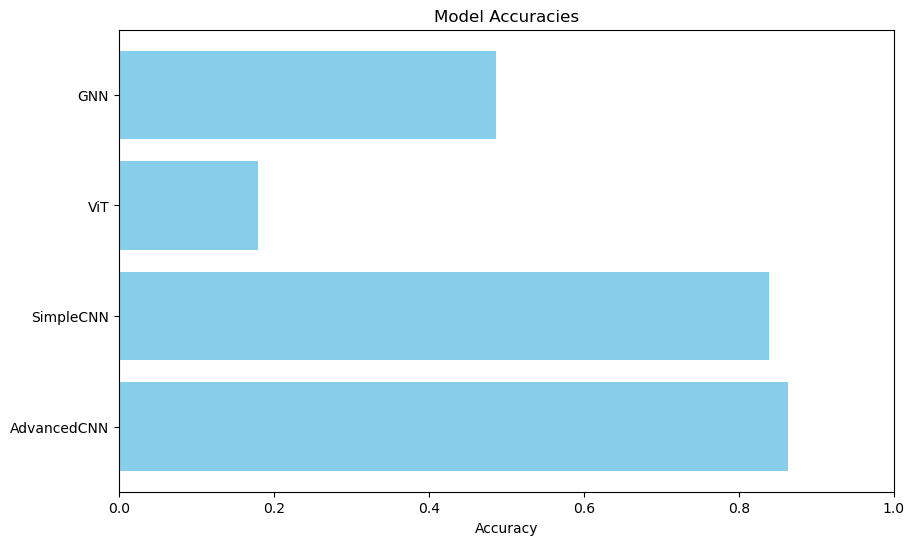

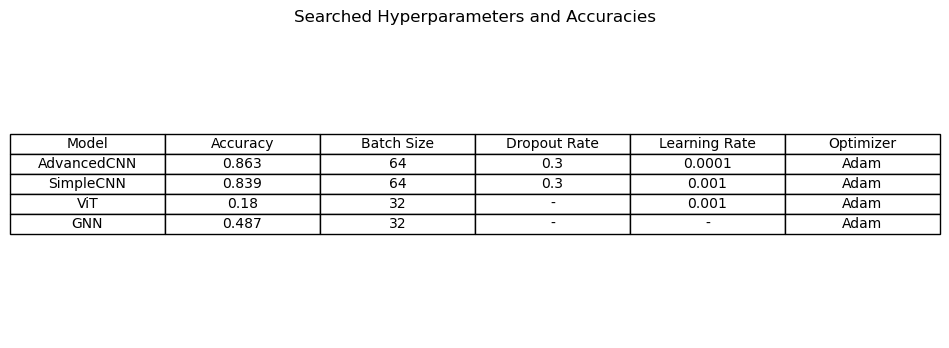

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    'Model': ['AdvancedCNN', 'SimpleCNN', 'ViT', 'GNN'],
    'Accuracy': [0.8630, 0.8390, 0.18, 0.4870],
    'Image Size': [128, 128, 128, 32],
    'Patch Size': ['-', '-', 16, '-'],
    'Num Classes': [6, 6, 6, 6],
    'Dim': ['-', '-', 512, '-'],
    'Depth': ['-', '-', 4, '-'],
    'Heads': ['-', '-', 8, '-'],
    'MLP Dim': ['-', '-', 1024, '-'],
    'Batch Size': [64, 64, 32, 32],
    'Dropout Rate': [0.3, 0.3, '-', '-'],
    'Learning Rate': [0.0001, 0.001, 0.001, '-'],
    'Optimizer': ['Adam', 'Adam', 'Adam', 'Adam'],
    'Resize': ['(128, 128)', '(128, 128)', '(128, 128)', '-'],
    'Normalization Mean': ['[0.485, 0.456, 0.406]', '[0.485, 0.456, 0.406]', '[0.485, 0.456, 0.406]', '-'],
    'Normalization Std': ['[0.229, 0.224, 0.225]', '[0.229, 0.224, 0.225]', '[0.229, 0.224, 0.225]', '-'],
    'Checkpoint Dir': ['./checkpoints/', './checkpoints/', './checkpoints/', './checkpoints/'],
    'Checkpoint Frequency': ['Every 500 batches', 'Every 500 batches', 'Every 500 batches', 'Every 500 batches']
}

###Convert data to DataFrame
df = pd.DataFrame(data)

###Plotting Accuracies
plt.figure(figsize=(10, 6))
plt.barh(df['Model'], df['Accuracy'], color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracies')
plt.xlim(0, 1)
plt.show()

import pandas as pd
import matplotlib.pyplot as plt

###Data with only the searched hyperparameters
data = {
    'Model': ['AdvancedCNN', 'SimpleCNN', 'ViT', 'GNN'],
    'Accuracy': [0.8630, 0.8390, 0.18, 0.4870],
    'Batch Size': ['64', '64', '32', '32'],
    'Dropout Rate': ['0.3', '0.3', '-', '-'],
    'Learning Rate': ['0.0001', '0.001', '0.001', '-'],
    'Optimizer': ['Adam', 'Adam', 'Adam', 'Adam']
}

###Convert data to DataFrame
df = pd.DataFrame(data)

###Displaying Hyperparameters as a Table
fig, ax = plt.subplots(figsize=(10, 4))  
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.title('Searched Hyperparameters and Accuracies')
plt.show()

The AdvancedCNN model achieved an accuracy of 86.3%, indicating its overall ability to correctly classify images across the test dataset. Precision (Macro) scored slightly higher at 86.69%, reflecting the model's ability to correctly predict each class, averaged equally across all classes. Recall (Macro) reached 86.47%, demonstrating the model's effectiveness in identifying all relevant instances for each class. Precision (Weighted) and Recall (Weighted) were 86.43% and 86.30%, respectively, showing that these metrics, which account for the imbalance in class occurrences, closely align with the macro scores.

Loading the best model from ./checkpoints/advanced_cnn/best_overall_model.pth
Test Accuracy: 0.8630
Precision (Macro): 0.8669
Recall (Macro): 0.8647
Precision (Weighted): 0.8643
Recall (Weighted): 0.8630


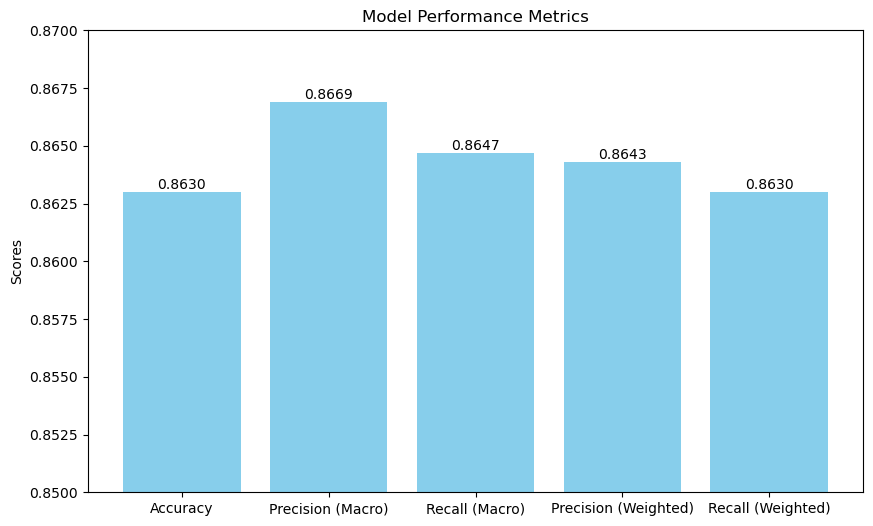

In [8]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score

### Function to evaluate the model on the test set and calculate precision & recall
def evaluate_model(model, test_loader):
    model.eval()  
    total_correct = 0
    total_samples = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            # Collect predictions and true labels for precision and recall calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = total_correct / total_samples
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Calculate precision and recall (macro-averaged and weighted)
    precision_macro = precision_score(all_labels, all_preds, average='macro')
    recall_macro = recall_score(all_labels, all_preds, average='macro')
    precision_weighted = precision_score(all_labels, all_preds, average='weighted')
    recall_weighted = recall_score(all_labels, all_preds, average='weighted')
    
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"Precision (Weighted): {precision_weighted:.4f}")
    print(f"Recall (Weighted): {recall_weighted:.4f}")
    
    return accuracy, precision_macro, recall_macro, precision_weighted, recall_weighted

### Load the best overall model
best_model_path = './checkpoints/advanced_cnn/best_overall_model.pth'
if os.path.exists(best_model_path):
    print(f"Loading the best model from {best_model_path}")
    
    ### Instantiate the model with the correct number of classes
    num_classes = len(test_dataset.label_to_index)
    model = AdvancedCNN(num_classes=num_classes)
    model = nn.DataParallel(model).to(device)
    
    ### Load the best model weights
    model.load_state_dict(torch.load(best_model_path))
    
    ### Evaluate the model on the test set and calculate precision and recall
    test_accuracy, precision_macro, recall_macro, precision_weighted, recall_weighted = evaluate_model(model, test_loader)
else:
    print("Best model not found. Ensure the best model is saved at the expected path.")
    
    
import matplotlib.pyplot as plt

# Data from the test results
metrics = ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'Precision (Weighted)', 'Recall (Weighted)']
values = [0.8630, 0.8669, 0.8647, 0.8643, 0.8630]

# Create the histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color='skyblue')

# Add the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', ha='center', va='bottom')

# Customize the plot
plt.title("Model Performance Metrics")
plt.ylabel("Scores")
plt.ylim(0.85, 0.87)

# Show the plot
plt.show()


### Conclusion & Future Work

The results from the experiment showcase the performance of various models—AdvancedCNN, SimpleCNN, Vision Transformer (ViT), and GCN (Graph Convolutional Network)—on the image classification task. The **AdvancedCNN** achieved the highest accuracy at **86.3%**, followed closely by the **SimpleCNN**, which reached an accuracy of **83.9%**. Both models were trained with a batch size of 64, a dropout rate of 0.3, and optimized using the Adam optimizer. The **GCN** model lagged behind, achieving only **48.7%** accuracy, indicating that the graph-based approach struggled with this particular dataset. The **ViT model** performed the worst, with an accuracy of **18%**, which suggests that the transformer architecture likely underperformed due to the relatively small size of the dataset, as transformers are known to excel with much larger data inputs. Overall, the results highlight the success of convolutional neural networks (especially deeper architectures) for this image classification task, while the transformer and graph-based approaches encountered difficulties.

Moving forward, there are several avenues for improving model performance and addressing the challenges encountered in this project. First, increasing the dataset size could potentially enhance the performance of the Vision Transformer (ViT). Transformers typically excel with large-scale datasets, and augmenting the data with more samples or using pre-trained transformer models on larger datasets may yield better results. Second, for the Graph Convolutional Network (GCN), further experimentation with different graph structures or incorporating additional spatial or contextual information into the graph nodes could help improve the accuracy. Adjusting the GCN architecture, such as increasing the depth of the network or introducing additional regularization techniques, could also be beneficial.

Additionally, exploring advanced optimization techniques, such as learning rate schedulers, weight decay adjustments, or using different optimizers like RMSprop or AdamW, could lead to better model convergence and generalization. Another area for exploration is the use of ensemble methods, combining the predictions of multiple models (e.g., CNNs, GCNs, and ViTs) to potentially improve overall accuracy by leveraging the strengths of each architecture.

Finally, fine-tuning hyperparameters such as the number of heads and depth in the transformer layers, along with experimenting with other attention mechanisms like the Swin Transformer or hybrid architectures, could help in achieving better performance in transformer-based models. Exploring these directions could further enhance the model's robustness and its applicability to different image classification tasks.